## Imports

In [1]:
%autosave 120

Autosaving every 120 seconds


In [2]:
# to install graphviz:
# sudo apt-get update
# sudo apt-get install graphviz xdg-utils

print("hi")
from transformer_lens.hook_points import HookPoint
print("tl")
import torch
from einops import rearrange
import torch
from tqdm.notebook import tqdm
from jaxtyping import Float
from dataclasses import dataclass, field
from copy import deepcopy
from typing import List, Dict
from functools import partial
from IPython.display import display, clear_output
import ipywidgets
import pathlib
import cloudpickle
from collections import defaultdict
from functools import partial
print("other")
torch.set_grad_enabled(False)

# from transformer lens
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        # Parse the PyTorch version to check if it's below version 2.0
        major_version = int(torch.__version__.split(".")[0])
        if major_version >= 2:
            return torch.device("mps")

    return torch.device("cpu")
device = get_device()
print("device", device)

# modified from neel nanda's examples
def imshow(tensor, renderer=None, xaxis="", yaxis="", font_size=None, show=True, color_continuous_midpoint=0.0, fix_size=False, **kwargs):
    import plotly.express as px
    import transformer_lens.utils as utils
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=color_continuous_midpoint, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs)
    if not font_size is None:
        if 'x' in kwargs:
            fig.update_layout(
              xaxis = dict(
                tickmode='array',
                tickvals = kwargs['x'],
                ticktext = kwargs['x'], 
                ),
               font=dict(size=font_size, color="black"))
        if 'y' in kwargs:
            fig.update_layout(
              yaxis = dict(
                tickmode='array',
                tickvals = kwargs['y'],
                ticktext = kwargs['y'], 
                ),
               font=dict(size=font_size, color="black"))
    if fix_size:
        # default settings aren't very good, these are better
        plot_args = {
            'width': 800,
            'height': 600,
            "autosize": False,
            'showlegend': True,
            'margin': {"l":0,"r":0,"t":100,"b":0}
        }
        if model.cfg.n_layers < len(kwargs['y']):
            plot_args['height'] *= model.cfg.D_conv
        
        fig.update_layout(**plot_args)
        fig.update_layout(legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ))
    if show:
        fig.show(renderer)
    else:
        return fig

def show(data, x, xaxis, yaxis, title, clipped):
    if clipped:
        imshow(data[:,2:], x=x[2:], xaxis=xaxis, yaxis=yaxis, title=title)
    else:
        imshow(data, x=x, xaxis=xaxis, yaxis=yaxis, title=title)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    import plotly.express as px
    import transformer_lens.utils as utils
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    import plotly.express as px
    import transformer_lens.utils as utils
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)


def bar_chart(data, x_labels, y_label, title, font_size=None):
    import pandas as pd
    import plotly.express as px
    # it requires a pandas dict with the columns and rows named, annoying
    # by default rows and columns are named with ints so we relabel them accordingly
    renames = dict([(i, x_labels[i]) for i in range(len(x_labels))])
    ps = pd.DataFrame(data.cpu().numpy()).rename(renames, axis='rows').rename({0: y_label}, axis='columns')
    fig = px.bar(ps, y=y_label, x=x_labels, title=title)
    if not font_size is None:
        fig.update_layout(
          xaxis = dict(
            tickmode='array',
            tickvals = x_labels,
            ticktext = x_labels, 
            ),
           font=dict(size=font_size, color="black"))
        
        #fig.update_xaxes(title_font=dict(size=font_size))
    
    fig.show()


hi
tl
other
device cuda


## Load Model

In [13]:
from mamba_lens import HookedMamba
from transformers.utils.hub import cached_file
from transformers.utils import WEIGHTS_NAME, CONFIG_NAME
import os
print(torch.cuda.is_available())
model_path = "state-spaces/mamba-370m"
print("model cached at", cached_file(model_path, WEIGHTS_NAME))
model = HookedMamba.from_pretrained(model_path, device='cuda')
from transformer_lens import HookedTransformer
#model = HookedTransformer.from_pretrained("gpt2-small")
torch.set_grad_enabled(False)

True
model cached at /home/dev/.cache/huggingface/hub/models--state-spaces--mamba-370m/snapshots/b6c47221dc4908532cc9773d469d6b8cbe3f0762/pytorch_model.bin


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


## Utility Functions

In [4]:
def get_pad_token(tokenizer):
    return tokenizer.pad_token_id

# given data that is [N,V] and indicies that are [N,K] with each index being an index into the V space
# this does what you'd want, it indexes them
# idk, see the test
def index_into(data, indices):
    num_data, num_per_data = indices.size()
    # we want
    # [0,0,0,...,] num per data of these
    # [1,1,1,...,] num per data of these
    # ...
    # [num_data-1, num_data-1, ...]
    first_axis_index = torch.arange(num_data, dtype=torch.long).view(num_data, 1)*torch.ones([num_data, num_per_data], dtype=torch.long)
    # now we flatten it so it has an index for each term aligned with our indices
    first_axis_index = first_axis_index.flatten()

    second_axis_index = indices.flatten()
    # now we can just index, and then view back to our original shape
    return data[first_axis_index, second_axis_index].view(num_data, num_per_data)

def eval_debug(model, data, correct, incorrect, constrain_to_answers, tags, batch_size, top_k=2, **kwargs):
    num_correct = 0
    num_incorrect = 0
    num_correct_tags = defaultdict(lambda: 0)
    num_incorrect_tags = defaultdict(lambda: 0)
    for batch_start in tqdm(list(range(0, correct.size()[0], batch_size))):
        batch_end = min(batch_start+batch_size, correct.size()[0])
        inputs = data[batch_start:batch_end]
        batch_logits = model(inputs, **kwargs)[:,-1]
        for b in range(batch_start, batch_end):
            logits = batch_logits[b-batch_start]
            input = model.tokenizer.decode(data[b])
            correct_answers = correct[b]
            incorrect_answers = incorrect[b]
            if constrain_to_answers:
                only_consider_answer_logits = torch.full(logits.size(), fill_value=-torch.inf, device=model.cfg.device)
                only_consider_answer_logits[correct_answers] = logits[correct_answers]
                only_consider_answer_logits[incorrect_answers] = logits[incorrect_answers]
                logits = only_consider_answer_logits
            prs = torch.nn.functional.softmax(logits, dim=0)
            top = torch.argsort(-logits)[:top_k]
            printed = False
            printed_prompt = False
            for i, tok in enumerate(top):
                if not i == 0 and tok in correct_answers:
                    if not printed_prompt:
                        if not tags is None:
                            print(tags[b])
                        print("prompt", input)
                        printed_prompt = True
                    print(f"  correct top {i} token {repr(model.tokenizer.decode([tok]))} logit {logits[tok]} prs {prs[tok]}")
                    printed = True
                    #print("correct")
                    #print(f"token {model.tokenizer.decode([tok])} logit {logits[tok]} prs {prs[tok]}")
                elif i == 0 and not tok in correct_answers:
                    if not printed_prompt:
                        if not tags is None:
                            print(tags[b])
                        print("prompt", input)
                        printed_prompt = True
                    print(f"  incorrect top {i} token {repr(model.tokenizer.decode([tok]))} logit {logits[tok]} prs {prs[tok]}")
                    printed = True
                if tok in correct_answers:
                    if i == 0:
                        num_correct += 1
                        if not tags is None:
                            num_correct_tags[tags[b]] += 1
                    break
                else:
                    if i == 0:
                        num_incorrect += 1
                        if not tags is None:
                            num_incorrect_tags[tags[b]] += 1
            
            if printed:
                print()
    return num_correct, num_incorrect, num_correct_tags, num_incorrect_tags

def eval(model, data, correct, incorrect, constrain_to_answers, batch_size=200, patch=False, **kwargs):
        if patch and batch_size % 2 != 0:
            raise ValueError(f"when patch=True, batch size ({batch_size}) must be a multiple of two (because every other input is patch input)")
        num_examples = correct.size()[0]
        total_num_correct = 0
        correct_prs_all = []
        incorrect_prs_all = []
        total_n_data = 0
        for batch_start in list(range(0, correct.size()[0], batch_size)):
            batch_end = min(batch_start+batch_size, correct.size()[0])
            batch_inputs = data[batch_start:batch_end]
            batch_correct = correct[batch_start:batch_end]
            batch_incorrect = incorrect[batch_start:batch_end]
            cur_batch_size = batch_inputs.size()[0]
            if patch:
                batch_correct = batch_correct[::2]
                batch_incorrect = batch_incorrect[::2]
            logits = model(batch_inputs, **kwargs)[:,-1]
            if patch:
                logits = logits[::2]
            pad = get_pad_token(tokenizer=model.tokenizer)
            logits[:,pad] = -torch.inf # manually set pad pr to -inf logit because sometimes we need to pad num correct or num incorrect
            
            n_data, n_correct = batch_correct.size()
            n_data, n_incorrect = batch_incorrect.size()

            total_n_data += n_data
    
            if constrain_to_answers:
                # [n_data, n_correct]
                correct_logits = index_into(logits, batch_correct)
                # [n_data, n_incorrect]
                incorrect_logits = index_into(logits, batch_incorrect)
                # [n_data, n_correct + n_incorrect]
                combined_logits = torch.concatenate([correct_logits, incorrect_logits], dim=1)
                combined_prs = torch.softmax(combined_logits, dim=1)
                biggest = torch.argsort(-combined_prs, dim=1)
                # if biggest pr is in the correct, we are correct, otherwise, we are not
                num_correct = torch.sum(biggest[:,0] < n_correct)
        
                correct_prs, incorrect_prs = combined_prs.split([n_correct, n_incorrect], dim=1)
            else:
                prs = torch.nn.functional.softmax(logits, dim=1)
                # [n_data, n_correct]
                correct_prs = index_into(prs, batch_correct)
                # [n_data, n_incorrect]
                incorrect_prs = index_into(prs, batch_incorrect)
                # [n_data, 1]
                top_tokens = torch.topk(logits, 1, dim=1).indices
                # [n_data, n_correct]
                is_correct = top_tokens == batch_correct
                # [n_data]
                has_any_correct = torch.any(is_correct, dim=1)
                # [1]
                num_correct = torch.sum(has_any_correct)
            correct_prs_all.append(correct_prs)
            incorrect_prs_all.append(incorrect_prs)
            total_num_correct += num_correct.item()
        incorrect_prs_all = torch.cat(incorrect_prs_all, dim=0)
        correct_prs_all = torch.cat(correct_prs_all, dim=0)
        # the sum(dim=1) is because we or of all the different possible probabilities by summing
        # then we'll just report the average
        return torch.mean(correct_prs_all.sum(dim=1)).item(), torch.mean(incorrect_prs_all.sum(dim=1)).item(), total_num_correct/float(total_n_data)


def add_padding_answers(tokenizer, answers):
    longest_len = len(max(answers, key=lambda x: len(x)))
    padded_answers = []
    pad_token = get_pad_token(tokenizer=tokenizer)
    for answer in answers:
        padded_answers.append(answer + [pad_token]*(longest_len-len(answer)))
    return padded_answers

def get_batched_data(data):
    batched_data = []
    batched_correct = []
    batched_incorrect = []

    bos = [model.tokenizer.bos_token_id]
    
    for i, (prompt, corrects, incorrects) in enumerate(data):
        if i < 7:
            print(prompt, corrects, incorrects)
        batched_data.append(torch.tensor(bos + model.tokenizer.encode(prompt), device=model.cfg.device))
        batched_correct.append([model.tokenizer.encode(correct)[0] for correct in corrects])
        batched_incorrect.append([model.tokenizer.encode(incorrect)[0] for incorrect in incorrects])
    try:
        batched_data = torch.stack(batched_data)
        batched_correct = torch.tensor(add_padding_answers(tokenizer=model.tokenizer, answers=batched_correct), device=model.cfg.device)
        batched_incorrect = torch.tensor(add_padding_answers(tokenizer=model.tokenizer, answers=batched_incorrect), device=model.cfg.device)
    except RuntimeError:
        typical_len = len(batched_data[0])
        for s in batched_data:
            if not len(s) == typical_len:
                print(len(s), "is len of this, typical len is", typical_len, "for sequence", model.to_str_tokens(s))
        raise
    return batched_data, batched_correct, batched_incorrect

# because every pair (i,i+1) is a patching (uncorrupted, corrupted),
# we want things to be symmetric,
# so we will double up our dataset
# by swapping each pair
def repeat_swapped_patch(vec):
    swapped_vecs = []
    for i in range(0, vec.size()[0], 2):
        swapped_vecs += [vec[i+1:i+2], vec[i:i+1]]
    return torch.cat([vec] + swapped_vecs, dim=0)


def wrap_run_with_hooks(model, fwd_hooks, bwd_hooks=[], **kwargs):
    def wrapper(input, fwd_hooks, bwd_hooks):
        return model.run_with_hooks(input, fwd_hooks=fwd_hooks, bwd_hooks=bwd_hooks, **kwargs)
    wrapper_with_hooks = partial(wrapper, fwd_hooks=fwd_hooks, bwd_hooks=bwd_hooks)
    wrapper_with_hooks.tokenizer = model.tokenizer
    wrapper_with_hooks.cfg = model.cfg
    return wrapper_with_hooks

## Generate Data

In [106]:
from docstring import docstring_prompt_generator_function
from importlib import reload
import random
import test_data
reload(test_data)
from test_data import IOI_generator, BABA_TEMPLATES, greater_than_data_generator, ABC_TEMPLATES, copy_generator, IOI_custom_generator
test_data.good_names = None

num_examples = 60

seed = 28
valid_seed = 37
test_seed = 47

batch_size = 500

# todo: move name tokens further apart so they can't use conv
data_type = 'docstring'

constrain_to_answers = True

if data_type == 'ioi':
    data = IOI_generator(templates=[BABA_TEMPLATES[1]], tokenizer=model.tokenizer, num_examples=num_examples, symmetric=True, seed=seed)
    valid_data = IOI_generator(templates=[BABA_TEMPLATES[1]], tokenizer=model.tokenizer, num_examples=num_examples, symmetric=True, seed=valid_seed)
    test_data = IOI_generator(templates=[BABA_TEMPLATES[1]], tokenizer=model.tokenizer, num_examples=num_examples, symmetric=True, seed=test_seed)
elif data_type == 'ioi custom':
    ioi_format = """
ABC AB C
ABC AC B""".strip()
    all_formats = list(test_data.extra_pruned_abc()) # this is all the one variable patchings
    #all_formats = [ioi_format] # use this if u just want your specific format
    for f in all_formats:
        print(f)
    if len(all_formats) > 1:
        print("WARNING: Using multiple formats")
    data, valid_data, test_data = [], [], []
    random.seed(seed)
    base_seeds = [random.randint(0,384828428428) for _ in range(len(all_formats))]
    random.seed(valid_seed)
    valid_seeds = [random.randint(0,384828428428) for _ in range(len(all_formats))]
    random.seed(test_seed)
    test_seeds = [random.randint(0,384828428428) for _ in range(len(all_formats))]
    for this_seed, this_valid_seed, this_test_seed, abc_format in zip(base_seeds, valid_seeds, test_seeds, all_formats):
        data += list(IOI_custom_generator(ioi_format=abc_format, tokenizer=model.tokenizer, num_examples=num_examples, seed=this_seed))
        print(data[-2])
        print(data[-1])
        print()
        valid_data += list(IOI_custom_generator(ioi_format=abc_format, tokenizer=model.tokenizer, num_examples=num_examples, seed=this_valid_seed))
        test_data += list(IOI_custom_generator(ioi_format=abc_format, tokenizer=model.tokenizer, num_examples=num_examples, seed=this_test_seed))
elif data_type == 'docstring':
    data = docstring_prompt_generator_function(tokenizer=model.tokenizer, num_examples=num_examples, corrupt='random_answer', seed=seed)
    valid_data = docstring_prompt_generator_function(tokenizer=model.tokenizer, num_examples=num_examples, corrupt='random_answer', seed=valid_seed)
    test_data = docstring_prompt_generator_function(tokenizer=model.tokenizer, num_examples=num_examples, corrupt='random_answer', seed=test_seed)
elif data_type == 'greater than':
    constrain_to_answers = False
    data = greater_than_data_generator(tokenizer=model.tokenizer, num_examples=num_examples, seed=seed)
    valid_data = greater_than_data_generator(tokenizer=model.tokenizer, num_examples=num_examples, seed=valid_seed)
    test_data = greater_than_data_generator(tokenizer=model.tokenizer, num_examples=num_examples, seed=test_seed)
elif data_type == 'copy':
    constrain_to_answers = False
    copy_seq_len = 4
    data = copy_generator(tokenizer=model.tokenizer, num_examples=num_examples, copy_seq_len=copy_seq_len, seed=seed)
    valid_data = copy_generator(tokenizer=model.tokenizer, num_examples=num_examples, copy_seq_len=copy_seq_len, seed=valid_seed)
    test_data = copy_generator(tokenizer=model.tokenizer, num_examples=num_examples, copy_seq_len=copy_seq_len, seed=test_seed)

print("data")
batched_data, batched_correct, batched_incorrect = get_batched_data(data)
print("\n\nvalid\n")
vbatched_data, vbatched_correct, vbatched_incorrect = get_batched_data(valid_data)
print("\n\ntest")
tbatched_data, tbatched_correct, tbatched_incorrect = get_batched_data(test_data)




relative_str = ' relative ' if constrain_to_answers else ' '

if data_type == 'ioi custom':
    data_tags = []
    for format in all_formats:
        data_tags += [format + "\n[" + format.split("\n")[0] + "]", format + "\n[" + format.split("\n")[1] + "]"] * (num_examples//2)
else:
    data_tags = None

data

def key(self, data, run, model, valid, expected, settings):
    """prison pack town

    :param model: show track
    :param valid: run support
    :param [' expected'] [' parent', ' state', ' action', ' file', ' instance', ' field', ' task', ' filename', ' model', ' valid', ' data', ' run', ' settings']

def key(self, data, run, model, valid, parent, settings):
    """prison pack town

    :param model: show track
    :param valid: run support
    :param [' parent'] [' state', ' action', ' file', ' instance', ' field', ' task', ' filename', ' model', ' valid', ' data', ' run', ' settings', ' expected']

def current(self, page, target, config, query, index, parent):
    """force doctor pair

    :param config: sex mile
    :param query: spot tube
    :param [' index'] [' title', ' values', ' results', ' read', ' ret', ' option', ' result', ' number', ' config', ' query', ' page', ' target', ' parent']

def current(self, page, target, config, query, title, parent):
    """force do

In [27]:

print("evaling data")
print(len(data_tags), batched_data.size()[0])
# constrain_to_answers will constrain generation to only outputting those answers
correct, incorrect, acc = eval(
                            model,
                            vbatched_data, vbatched_correct, vbatched_incorrect,
                            constrain_to_answers=constrain_to_answers,
                            batch_size=batch_size, patch=True)

# if you are doing constrain_to_answers, the prs will be relative (so within the given answers the pr will sum to 1)
# otherwise they will just be the prs given by softmax of the logits
print(f"baseline correct{relative_str}pr {correct} incorrect{relative_str}pr {incorrect} accuracy {acc}")

print("incorrect datapoints:")
# constrain_to_answers will constrain generation to only outputting those answers
num_correct, num_incorrect, num_correct_tags, num_incorrect_tags = eval_debug(
                            model,
                            batched_data, batched_correct, batched_incorrect,
                            constrain_to_answers=constrain_to_answers,
                            batch_size=batch_size,
                            tags=data_tags)
# it's okay to keep the incorrect ones around, their signal should be weak
print(f"done eval, there are {num_correct} correct (top_1) and {num_incorrect} incorrect")

if not data_tags is None:
    unique_tags = []
    for t in data_tags:
        if not t in unique_tags:
            unique_tags.append(t)
    for t in unique_tags:
        print("data format")
        print(t)
        print("has")
        acc = num_correct_tags[t] / float(num_correct_tags[t] + num_incorrect_tags[t])
        print(f"  {num_correct_tags[t]} correct and {num_incorrect_tags[t]} incorrect (so accuracy of {acc})")

evaling data
300 300
baseline correct relative pr 0.7914594411849976 incorrect relative pr 0.20854060351848602 accuracy 0.92
incorrect datapoints:


  0%|          | 0/1 [00:00<?, ?it/s]

CAB AB C
DAB AB D
[DAB AB D]
prompt <|endoftext|>Lately, Dallas, Catherine, and Christie had fun at the school. Catherine and Christie gave a basketball to
  incorrect top 0 token ' Catherine' logit 9.798842430114746 prs 0.5340464115142822
  correct top 1 token ' Dallas' logit 9.465944290161133 prs 0.3828275501728058

CAB AB C
DAB AB D
[DAB AB D]
prompt <|endoftext|>Lately, Carolina, Stephanie, and Virginia had fun at the hospital. Stephanie and Virginia gave a computer to
  incorrect top 0 token ' Stephanie' logit 12.444290161132812 prs 0.6804540753364563
  correct top 1 token ' Carolina' logit 11.495333671569824 prs 0.2634342908859253

ACB AB C
ADB AB D
[ADB AB D]
prompt <|endoftext|>Lately, Shannon, Erin, and Kirby had fun at the house. Shannon and Kirby gave a bone to
  incorrect top 0 token ' Shannon' logit 16.567655563354492 prs 0.5040342211723328
  correct top 1 token ' Erin' logit 16.4916934967041 prs 0.4671647846698761

ACB AB C
ADB AB D
[ADB AB D]
prompt <|endoftext|>Lately, 

## Patching

See [MambaLens](https://github.com/Phylliida/MambaLens) for a list of all the hooks available.

set `fast_conv=True` unless you are patching on conv

set `fast_ssm=True` unless you are patching on `h`, `delta`, `A_bar`, `B_bar`, or `y`

(you can set them both to False always, it'll just be slower)

There are a few special ones:

## `skip h`

This sets the hidden state contribution at the target position and layer to 0.

In other words, where normally the hidden state at that position would be

$$h_{pos+1} = Ah_{pos} + Bx$$

Now it is just

$$h_{pos+1} = Ah_{pos}$$

## `h_n`

Patches on the N different E-sized hidden states

Note that patching on `h_n` is hardcoded to layer 39 via

```
H_N_PATCHING_LAYER = 39
```

You can change this to pick a different layer

In [19]:
# modified from neel nanda's examples

H_N_PATCHING_LAYER = 39

# default settings aren't very good, these are better
plot_args = {
    'width': 800,
    'height': 600,
    "autosize": False,
    'showlegend': True,
    'margin': {"l":0,"r":0,"t":100,"b":0}
}

#limited_layers = [0, 3, 10, 14, 15, 17, 18, 21, 22, 25, 26, 27, 28, 33, 36, 39, 40, 45, 46]
limited_layers = list(range(model.cfg.n_layers))
limited_layers = list(range(40)) + [40, 45, 46]

# grab first two data points as patching inputs
# the data generators will pair things nicely
# you can also just replace these with two strings
prompt_uncorrupted = model.tokenizer.decode(batched_data[0][1:])
prompt_corrupted = model.tokenizer.decode(batched_data[1][1:])

answer_tokens = sorted(list(set([x.item() for x in batched_correct[0]] + [x.item() for x in batched_correct[1]] + [x.item() for x in batched_incorrect[0]] + [x.item() for x in batched_incorrect[1]])))
uncorrupted_answer = model.tokenizer.decode([batched_correct[0,0]])
corrupted_answer = model.tokenizer.decode([batched_correct[1,0]])

# constrain_to_answers will constrain generation to only outputting those answers
correct, incorrect, acc = eval(
                            wrap_run_with_hooks(model=model, fwd_hooks=[], only_use_these_layers=limited_layers),
                            vbatched_data, vbatched_correct, vbatched_incorrect,
                            constrain_to_answers=constrain_to_answers)

# if you are doing constrain_to_answers, the prs will be relative (so within the given answers the pr will sum to 1)
# otherwise they will just be the prs given by softmax of the logits
print(f"baseline correct{relative_str}pr {correct} incorrect{relative_str}pr {incorrect} accuracy {acc}")

prompt_uncorrupted_tokens = model.to_tokens(prompt_uncorrupted)
prompt_corrupted_tokens = model.to_tokens(prompt_corrupted)

# logits should be [B,L,V] 
def uncorrupted_logit_minus_corrupted_logit(logits, uncorrupted_answer, corrupted_answer):
    uncorrupted_index = model.to_single_token(uncorrupted_answer)
    corrupted_index = model.to_single_token(corrupted_answer)
    return logits[0, -1, uncorrupted_index] - logits[0, -1, corrupted_index]

# prs should be [B,L,V] 
def uncorrupted_pr_minus_corrupted_pr(prs, uncorrupted_answer, corrupted_answer):
    uncorrupted_index = model.to_single_token(uncorrupted_answer)
    corrupted_index = model.to_single_token(corrupted_answer)
    return prs[0, -1, uncorrupted_index] - prs[0, -1, corrupted_index]

# [B,L,V]
corrupted_logits, corrupted_activations = model.run_with_cache(prompt_corrupted_tokens, only_use_these_layers=limited_layers)
corrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=corrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
corrupted_prs = torch.softmax(corrupted_logits, dim=2)
corrupted_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=corrupted_prs, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

# [B,L,V]
uncorrupted_logits = model(prompt_uncorrupted_tokens, only_use_these_layers=limited_layers)
uncorrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=uncorrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
uncorrupted_prs = torch.softmax(uncorrupted_logits, dim=2)
uncorrupted_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=uncorrupted_prs, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

uncorrupted_index = model.to_single_token(uncorrupted_answer)
corrupted_index = model.to_single_token(corrupted_answer)
print(f'uncorrupted prompt\n{prompt_uncorrupted}')
print(f"{repr(uncorrupted_answer)} logit {uncorrupted_logits[0,-1,uncorrupted_index]}")
print(f"{repr(uncorrupted_answer)} pr {uncorrupted_prs[0,-1,uncorrupted_index]}")
print(f"{repr(corrupted_answer)} logit {uncorrupted_logits[0,-1,corrupted_index]}")
print(f"{repr(corrupted_answer)} pr {uncorrupted_prs[0,-1,corrupted_index]}")
print(f'\ncorrupted prompt\n{prompt_corrupted}')
print(f"{repr(uncorrupted_answer)} logit {corrupted_logits[0,-1,uncorrupted_index]}")
print(f"{repr(uncorrupted_answer)} pr {corrupted_prs[0,-1,uncorrupted_index]}")
print(f"{repr(corrupted_answer)} logit {corrupted_logits[0,-1,corrupted_index]}")
print(f"{repr(corrupted_answer)} pr {corrupted_prs[0,-1,corrupted_index]}")

# We make a tensor to store the results for each patching run. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
L = len(prompt_uncorrupted_tokens[0])
if len(prompt_corrupted_tokens[0]) != len(prompt_uncorrupted_tokens[0]):
    raise Exception("Prompts are not the same length") # feel free to comment this out, you can patch for different sized prompts its just a lil sus

# diff is logit of uncorrupted_answer - logit of corrupted_answer
# we expect corrupted_diff to have a negative value (as corrupted should put high pr on corrupted_answer)
# we expect uncorrupted to have a positive value (as uncorrupted should put high pr on uncorrupted_answer)
# thus we can treat these as (rough) min and max possible values
min_logit_diff = corrupted_logit_diff
max_logit_diff = uncorrupted_logit_diff

min_pr_diff = corrupted_pr_diff
max_pr_diff = uncorrupted_pr_diff

# make token labels that describe the patch
corrupted_str_tokens = model.to_str_tokens(prompt_corrupted_tokens)
uncorrupted_str_tokens = model.to_str_tokens(prompt_uncorrupted_tokens)
token_labels = []
for index, (corrupted_token, uncorrupted_token) in enumerate(zip(corrupted_str_tokens, uncorrupted_str_tokens)):
    if corrupted_token == uncorrupted_token:
        token_labels.append(f"{corrupted_token}_{index}")
    else:
        token_labels.append(f"{uncorrupted_token}->{corrupted_token}_{index}")

def run_patching(patching_type, patching_hook_name_func, patching_hook_func, batch_size, show_options, show_plot=True, **kwargs):
    torch.cuda.empty_cache()
    hook_title = patching_hook_name_func(layer='{layer}', position='{position}')
    print(f"running patching {patching_type}, using hook {hook_title}")
    global patching_result_logits, patching_result_prs # if you want to access it once this is done running
    n_layers = len(limited_layers)

    num_results = n_layers
    if patching_type == H_N_PATCHING:
        print(f"on layer H_N_PATCHING_LAYER={H_N_PATCHING_LAYER}")
        N = model.cfg.N
        num_results = N
    elif patching_type == CONV_FILTERS_PATCHING:
        D_conv = model.cfg.D_conv
        num_results = (D_conv-1)*n_layers # -1 because the zero one is always zero so we ignore it
    
    patching_result_normalized_logits = torch.zeros((num_results, L), device=model.cfg.device)
    patching_result_normalized_prs = torch.zeros((num_results, L), device=model.cfg.device)

    num_answers = len(answer_tokens)
    patching_result_logits = torch.zeros((num_results, L, num_answers), device=model.cfg.device)
    patching_result_prs = torch.zeros((num_results, L, num_answers), device=model.cfg.device)
    
    hooks = []
    # skipping h needs A_bar stored, so also add that hook
    if patching_type == SKIPPING_H_PATCHING:
        for i, layer in list(enumerate(limited_layers)):
            hooks.append((f'blocks.{layer}.hook_A_bar', partial(A_bar_storage_hook_for_skipping_h, layer=layer)))

    # skipping layer needs layer_input (resid_pre) stored, so also add that hook
    if patching_type == LAYER_SKIPPING:
        for i, layer in list(enumerate(limited_layers)):
            hooks.append((f'blocks.{layer}.hook_resid_pre', partial(layer_input_storage_hook, layer=layer)))
    
    # conv filters needs conv_input (hook_in_proj) stored, so also add that hook
    if patching_type == CONV_FILTERS_PATCHING:
        for i, layer in list(enumerate(limited_layers)):
            hooks.append((f'blocks.{layer}.hook_in_proj', partial(conv_input_storage_hook, layer=layer)))
    
    if patching_type == H_N_PATCHING:
        batch = 0
        indices = []
        for n in range(N):
            for position in range(L):
                patching_hook_name = patching_hook_name_func(layer=H_N_PATCHING_LAYER, position=position)
                if batch_size != BATCH_SIZE_ALL: batch = batch % int(batch_size)
                patching_hook = partial(patching_hook_func, layer=H_N_PATCHING_LAYER, position=position, n=n, batch=batch)
                batch += 1
                indices.append((n,position))
                hooks.append((patching_hook_name, patching_hook))
    elif patching_type == CONV_FILTERS_PATCHING:
        batch = 0
        indices = []
        D_conv = model.cfg.D_conv
        ind = 0
        for i, layer in list(enumerate(limited_layers)):
            for conv_filter_i in range(D_conv):
                if conv_filter_i == 0: continue # this is always zero for some reason
                for position in range(L):
                    patching_hook_name = patching_hook_name_func(layer=layer, position=position)
                    if batch_size != BATCH_SIZE_ALL: batch = batch % int(batch_size)
                    patching_hook = partial(patching_hook_func, layer=layer, position=position, batch=batch, conv_filter_i=conv_filter_i)
                    batch += 1
                    indices.append((ind,position))
                    hooks.append((patching_hook_name, patching_hook))
                ind += 1
    else:
        batch = 0
        indices = []
        for i, layer in list(enumerate(limited_layers)):
            for position in range(L):
                patching_hook_name = patching_hook_name_func(layer=layer, position=position)
                if batch_size != BATCH_SIZE_ALL: batch = batch % int(batch_size)
                patching_hook = partial(patching_hook_func, layer=layer, position=position, batch=batch)
                batch += 1
                indices.append((i,position))
                hooks.append((patching_hook_name, patching_hook))

    
    if batch_size != BATCH_SIZE_ALL:
        V = model.cfg.V
        patched_logits = torch.zeros([len(indices), L, V])
        for batch_start in tqdm(list(range(0, len(indices), int(batch_size)))):
            batch_end = min(len(indices), batch_start+int(batch_size))
            batch_hooks = hooks[batch_start:batch_end]
            cur_batch_size = batch_end-batch_start
            patched_logits[batch_start:batch_end] = model.run_with_hooks(prompt_uncorrupted_tokens.expand(cur_batch_size,L), fwd_hooks=batch_hooks, only_use_these_layers=limited_layers, **kwargs)
    else:
        # [B,L,V]
        patched_logits = model.run_with_hooks(prompt_uncorrupted_tokens.expand(batch,L), fwd_hooks=hooks, only_use_these_layers=limited_layers, **kwargs)
   
    # [B,L,V]
    patched_prs = torch.softmax(patched_logits, dim=2)
    print("finished patching, plotting...")
    for b, (i,position) in enumerate(indices):
        if corrupted_answer != uncorrupted_answer:
            patched_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=patched_logits[b:b+1],
                                                                         uncorrupted_answer=uncorrupted_answer,
                                                                         corrupted_answer=corrupted_answer)
            # normalize it so
            # 0 means min_logit_diff (so 0 means that it is acting like the corrupted model)
            # 1 means max_logit_diff (so 1 means that it is acting like the uncorrupted model)
            normalized_patched_logit_diff = (patched_logit_diff-min_logit_diff)/(max_logit_diff - min_logit_diff)
            # now flip them, since most interventions will do nothing and thus act like uncorrupted model, visually its better to have that at 0
            # so now
            # 0 means that it is acting like the uncorrupted model
            # 1 means that it is acting like the corrupted model
            normalized_patched_logit_diff = 1.0 - normalized_patched_logit_diff
            patching_result_normalized_logits[i, position] = normalized_patched_logit_diff
            
            # same for pr
            patched_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=patched_prs[b:b+1],
                                                                uncorrupted_answer=uncorrupted_answer,
                                                                corrupted_answer=corrupted_answer)
            normalized_patched_pr_diff = 1.0-(patched_pr_diff-min_pr_diff)/(max_pr_diff - min_pr_diff)
            patching_result_normalized_prs[i, position] = normalized_patched_pr_diff

        for k, answer_token in enumerate(answer_tokens):
            patching_result_logits[i, position, k] = patched_logits[b,-1,answer_token]
            patching_result_prs[i, position, k] = patched_prs[b,-1,answer_token]
    
        
    if patching_type == H_N_PATCHING:
        layer_labels = [str(n) for n in range(N)]
    elif patching_type == CONV_FILTERS_PATCHING:
        layer_labels = []
        for layer in limited_layers:
            for conv_i in range(1, D_conv):
                layer_labels.append(f"layer {layer} conv {conv_i-D_conv+1}")
    else:
        layer_labels = [str(layer) for layer in limited_layers]
    figs = []
    if corrupted_answer != uncorrupted_answer:
        if show_options in [SHOW_LOGITS, SHOW_BOTH]:
            figs.append(imshow(patching_result_normalized_logits, show=False, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Normalized logit difference after patching {patching_type} using hook {hook_title}", font_size=8))
        if show_options in [SHOW_PR, SHOW_BOTH]:
            figs.append(imshow(patching_result_normalized_prs, show=False, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Normalized pr difference after patching {patching_type} using hook {hook_title}", font_size=8))
    
    for k, answer_token in enumerate(answer_tokens):
        if show_options in [SHOW_LOGITS, SHOW_BOTH]:
            figs.append(imshow(patching_result_logits[:,:,k], color_continuous_midpoint=None, show=False, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Logit of uncorrupted answer {repr(model.tokenizer.decode([answer_token]))} after patching {patching_type} using hook {hook_title}", font_size=8))
        if show_options in [SHOW_PR, SHOW_BOTH]:
            figs.append(imshow(patching_result_prs[:,:,k], show=False, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Pr of uncorrupted answer {repr(model.tokenizer.decode([answer_token]))} after patching {patching_type} using hook {hook_title}", font_size=8)) 

    for fig in figs:
        plot_args_copy = dict(list(plot_args.items()))
        if patching_type == CONV_FILTERS_PATCHING:
            plot_args_copy['height'] *= D_conv
        fig.update_layout(**plot_args_copy)
        fig.update_layout(legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ))
        fig.show()

## hooks for conv filter patching
def conv_input_storage_hook(
    conv_input: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L E"]:
    global progress # it's slow enough that progress bar is useful
    if layer == 0:
        progress = tqdm(total=len(limited_layers))
    else:
        progress.update(1)
    global storage
    storage = {}
    storage['conv_input'] = conv_input
    return conv_input

def conv_patching_hook(
    conv_output: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    layer: int,
    position: int,
    batch: int,
    conv_filter_i: int,
) -> Float[torch.Tensor, "B L E"]:
    global storage
    conv_input = storage['conv_input']
    B, L, E = conv_input.size()
    conv_input = rearrange(conv_input, 'B L E -> B E L')
    conv_input_corrupted = rearrange(corrupted_activations[f'blocks.{layer}.hook_in_proj'], 'B L E -> B E L')
    
    ### This is identical to what the conv is doing
    # pad zeros in front
    # [B,E,D_CONV-1+L]
    D_CONV = model.cfg.d_conv
    padded_input = torch.nn.functional.pad(conv_input, (D_CONV-1,0), mode='constant', value=0)
    padded_input_corrupted = torch.nn.functional.pad(conv_input_corrupted, (D_CONV-1,0), mode='constant', value=0)
    output = torch.zeros([B,E,L], device=model.cfg.device)
    # [E,1,D_CONV]
    conv_weight = model.blocks[layer].conv1d.weight
    # [E]
    conv_bias = model.blocks[layer].conv1d.bias
    # this is inefficient because its recomputing things every time
    # but I don't want to have to rely on the ordering of hooks because that's sus
    # so this is good enough
    for i in range(D_CONV):
        filter_str = f'filter_{i}'
        if not filter_str in storage:
            # [B,E,L]                      [E,1]                      [B,E,L]
            filter_contribution = conv_weight[:,0,i].view(E,1)*padded_input[:,:,i:i+L]
            storage[filter_str] = filter_contribution
        filter_contribution = storage[filter_str]
        if i == conv_filter_i:
            # [1,E,L]                                   [E,1]                          # [1,E,L]
            corrupted_filter_contribution = conv_weight[:,0,i].view(E,1)*padded_input_corrupted[:,:,i:i+L]
            # [E]                                                    [E]
            filter_contribution[batch,:,position] = corrupted_filter_contribution[0,:,position]
        storage[filter_str] = filter_contribution
        output += filter_contribution
        #output += conv_weight[:,0,i].view(E,1)*conv_input
        #if i == D_CONV-1:
        #    output += conv_weight[:,0,i].view(E,1)*conv_input

    # bias is not dependent on input so no reason to patch on it, just apply it as normal
    output += conv_bias.view(E, 1)
    
    output = rearrange(output, 'B E L -> B L E')
    return output



## hooks for layer skipping
def layer_input_storage_hook(
    layer_input: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L D"]:
    global storage
    storage = {}
    storage['layer_input'] = layer_input
    return layer_input

def layer_output_skipping_hook(
    layer_output: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    position: int,
    layer: int,
    batch: int,
) -> Float[torch.Tensor, "B L D"]:
    global storage
    layer_input = storage['layer_input']
    # intervene on the batch at the position
    layer_output[batch,position,:] = layer_input[batch,position,:]
    return layer_output


## hooks for h skipping
def A_bar_storage_hook_for_skipping_h(
    A_bar: Float[torch.Tensor, "B L E N"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L E N"]:
    global storage
    storage = {}
    storage['A_bar'] = A_bar
    return A_bar

def skipping_h_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    position: int,
    layer: int,
    batch: int,
) -> Float[torch.Tensor, "B E N"]:
    #print("fetching", storage[grab_pos][0,0,0:5], "from position", grab_pos)
    #print("my value (being ignore) is", h[0,0,0:5])
    #print(f"skipping ahead h at position {position}")
    global storage
    B,E,N = h.size()
    grab_pos = position-1
    if grab_pos < 0:
        h[batch,:,:] = torch.zeros((E,N), device=model.cfg.device)
    else:
        B,E,N = h.size()
        A_contribution = torch.ones((E,N), device=model.cfg.device)
        for missed_pos in range(grab_pos+1, position+1):
            A_contribution *= storage['A_bar'][batch,missed_pos,:,:]
        h_stored = storage[grab_pos][batch,:,:]
        h[batch,:,:] = A_contribution*h_stored
        #return A_contribution*storage[grab_pos]
    storage[position] = h
    return h


## Regular patching hooks
def position_patching_hook( # also works for B L E, B L E N, and B L N sized things
    x: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    position: int,
    layer: int, # we don't care about this
    batch: int,
) -> Float[torch.Tensor, "B L D"]:
    # only intervene on the specific pos
    corrupted_x = corrupted_activations[hook.name]
    x[batch, position, :] = corrupted_x[0, position, :]
    return x

def h_patching_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    position: int,
    layer: int,
    batch: int,
) -> Float[torch.Tensor, "B E N"]:
    corrupted_h = corrupted_activations[hook.name]
    h[batch] = corrupted_h[0]
    return h

def h_n_patching_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    position: int,
    layer: int,
    n: int,
    batch: int,
) -> Float[torch.Tensor, "B E N"]:
    corrupted_h = corrupted_activations[hook.name]
    h[batch,:,n] = corrupted_h[0,:,n]
    return h

SKIPPING_H_PATCHING = 'skipping h'
H_N_PATCHING = 'h_n'
LAYER_SKIPPING = 'skipping layer'
CONV_FILTERS_PATCHING = 'conv filters'

patching_types = {
    'normalized input': (lambda layer, position: f'blocks.{layer}.hook_normalized_input', position_patching_hook),
    'layer input': (lambda layer, position: f'blocks.{layer}.hook_resid_pre', position_patching_hook),
    'skip': (lambda layer, position: f'blocks.{layer}.hook_skip', position_patching_hook), 
    'in proj': (lambda layer, position: f'blocks.{layer}.hook_in_proj', position_patching_hook), 
    CONV_FILTERS_PATCHING: (lambda layer, position: f'blocks.{layer}.hook_conv', conv_patching_hook),
    'conv': (lambda layer, position: f'blocks.{layer}.hook_conv', position_patching_hook), 
    'delta 1': (lambda layer, position: f'blocks.{layer}.hook_delta_1', position_patching_hook), 
    'delta 2': (lambda layer, position: f'blocks.{layer}.hook_delta_2', position_patching_hook), 
    'delta': (lambda layer, position: f'blocks.{layer}.hook_delta', position_patching_hook), 
    'A_bar': (lambda layer, position: f'blocks.{layer}.hook_A_bar', position_patching_hook), 
    'B': (lambda layer, position: f'blocks.{layer}.hook_B', position_patching_hook), 
    'B_bar': (lambda layer, position: f'blocks.{layer}.hook_B_bar', position_patching_hook), 
    'C': (lambda layer, position: f'blocks.{layer}.hook_C', position_patching_hook), 
    'ssm input': (lambda layer, position: f'blocks.{layer}.hook_ssm_input', position_patching_hook),
    SKIPPING_H_PATCHING: (lambda layer, position: f'blocks.{layer}.hook_h.{position}', skipping_h_hook),
    'h': (lambda layer, position: f'blocks.{layer}.hook_h.{position}', h_patching_hook),
    H_N_PATCHING: (lambda layer, position: f'blocks.{layer}.hook_h.{position}', h_n_patching_hook),
    'y': (lambda layer, position: f'blocks.{layer}.hook_y', position_patching_hook),
    'ssm output': (lambda layer, position: f'blocks.{layer}.hook_ssm_output', position_patching_hook),
    'after skip': (lambda layer, position: f'blocks.{layer}.hook_after_skip', position_patching_hook),
    'out proj': (lambda layer, position: f'blocks.{layer}.hook_out_proj', position_patching_hook),
    'resid post': (lambda layer, position: f'blocks.{layer}.hook_resid_post', position_patching_hook),
    LAYER_SKIPPING: (lambda layer, position: f'blocks.{layer}.hook_resid_post', layer_output_skipping_hook),
}

patching_types_keys = list(patching_types.keys())

def choose_patching_type(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_patching_type.patching_type = change['new'] # hack, gives this function the patching_type attribute

choose_patching_type.patching_type = patching_types_keys[0]

patching_type_dropdown = ipywidgets.Dropdown(
    options=patching_types_keys,
    value=patching_types_keys[0],
    description='Patching Type',
)
patching_type_dropdown.observe(choose_patching_type)
display(patching_type_dropdown)

BATCH_SIZE_ALL = 'all'
batch_size_keys = [BATCH_SIZE_ALL] + [str(b) for b in range(model.cfg.n_layers*model.cfg.D_conv*L)]

def choose_batch_size(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_batch_size.batch_size = change['new']

choose_batch_size.batch_size = batch_size_keys[0]

choose_batch_size_dropdown = ipywidgets.Dropdown(
    options=batch_size_keys,
    value=batch_size_keys[0],
    description='batch size',
)
choose_batch_size_dropdown.observe(choose_batch_size)
display(choose_batch_size_dropdown)

fast_conv_keys = ['True', 'False']

def choose_fast_conv(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_fast_conv.fast_conv = change['new'] == 'True'

choose_fast_conv.fast_conv = fast_conv_keys[0] == 'True'

choose_fast_conv_dropdown = ipywidgets.Dropdown(
    options=fast_conv_keys,
    value=fast_conv_keys[0],
    description='fast conv',
)
choose_fast_conv_dropdown.observe(choose_fast_conv)
display(choose_fast_conv_dropdown)


fast_ssm_keys = ['False', 'True']

def choose_fast_ssm(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_fast_ssm.fast_ssm = change['new'] == 'True'

choose_fast_ssm.fast_ssm = fast_ssm_keys[0] == 'True'

choose_fast_ssm_dropdown = ipywidgets.Dropdown(
    options=fast_ssm_keys,
    value=fast_ssm_keys[0],
    description='fast ssm',
)
choose_fast_ssm_dropdown.observe(choose_fast_ssm)
display(choose_fast_ssm_dropdown)

SHOW_PR = 'Pr'
SHOW_LOGITS = 'Logits'
SHOW_BOTH = 'Both'
show_options = [SHOW_LOGITS, SHOW_PR, SHOW_BOTH]

def choose_show_options(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_show_options.show_options = change['new']

choose_show_options.show_options = show_options[0]

show_options_dropdown = ipywidgets.Dropdown(
    options=show_options,
    value=show_options[0],
    description='logits or pr',
)
show_options_dropdown.observe(choose_show_options)
display(show_options_dropdown)

def do_patching(arg, show_plot=True):
    with output: # this lets the stuff we output here be visible
        clear_output()
        patching_type = choose_patching_type.patching_type
        hook_name_func, hook_func = patching_types[patching_type]
        return run_patching(
                     patching_type=patching_type,
                     patching_hook_name_func=hook_name_func,
                     patching_hook_func=hook_func,
                     batch_size=choose_batch_size.batch_size,
                     fast_ssm=choose_fast_ssm.fast_ssm,
                     fast_conv=choose_fast_conv.fast_conv,
                     show_options=choose_show_options.show_options,
                     show_plot=show_plot)

patching_button = ipywidgets.Button(description = 'Run Patching')
patching_button.on_click(do_patching)
display(patching_button)

# you can't just display stuff inside a widget callback, you need a wrap any display code in this
output = ipywidgets.Output()
display(output)

IndexError: index 100 is out of bounds for dimension 0 with size 100

## Attention map like stuff

In [25]:

def cosine_similarity(vec1, vec2):
    B = vec1.size()[0]
    vec1 = vec1.reshape(B,-1)
    vec2 = vec2.reshape(B,-1)
    my_mag = torch.linalg.norm(vec1, ord=2, dim=1)
    my_mag[my_mag == 0] = 1.0 # prevent divide by zero
    other_mag = torch.linalg.norm(vec2, ord=2, dim=1)
    other_mag[other_mag == 0] = 1.0 # prevent divide by zero
    prod = vec1 * vec2
    dot_prod = prod.sum(dim=1)
    sims = dot_prod * (1.0/my_mag) * (1.0/other_mag)
    return torch.mean(sims, dim=0)


B,L = batched_data.size()
limited_layers = list(range(model.cfg.n_layers))
n_layers = len(limited_layers)
names_filter = []
for layer in limited_layers:
    names_filter.append(f'blocks.{layer}.hook_A_bar')
    names_filter.append(f'blocks.{layer}.hook_B_bar')
    names_filter.append(f'blocks.{layer}.hook_ssm_input')
    for l in range(L):
        names_filter.append(f'blocks.{layer}.hook_h.{l}')
        
logits, activations = model.run_with_cache(batched_data, names_filter=names_filter)

h_similarities = torch.zeros([n_layers, L, L])
x_b_similarities = torch.zeros([n_layers, L, L])
h_to_x_b_similarities = torch.zeros([n_layers, L, L])
h_to_x_b_similarities_catchup = torch.zeros([n_layers, L, L])
E,N = model.cfg.E, model.cfg.N
for i, layer in tqdm(list(enumerate(limited_layers))):
    # [B,L,E,N]
    A_bar = activations[f'blocks.{layer}.hook_A_bar']
    # [B,L,E,N]
    B_bar = activations[f'blocks.{layer}.hook_B_bar']
    # [B,L,E]
    x = activations[f'blocks.{layer}.hook_ssm_input']
    # [B,L,E,N]
    x_b = x.view(B,L,E,1)*B_bar
    for pos in range(L):
        my_h = activations[f'blocks.{layer}.hook_h.{pos}']
        my_x_b = x_b[:,pos,:,:]
        for other_pos in range(L):
            other_h = activations[f'blocks.{layer}.hook_h.{other_pos}']
            other_x_b = x_b[:,other_pos,:,:]
            h_similarities[i,pos,other_pos] = cosine_similarity(my_h, other_h)
            x_b_similarities[i,pos,other_pos] = cosine_similarity(my_x_b, other_x_b)
            h_to_x_b_similarities[i,pos,other_pos] = cosine_similarity(my_x_b, other_h)
            my_x_b_catchuped = my_x_b
            for catchup_pos in range(pos+1, other_pos+1):
                my_x_b_catchuped = my_x_b_catchuped * A_bar[:,catchup_pos]
            h_to_x_b_similarities_catchup[i,pos,other_pos] = cosine_similarity(my_x_b_catchuped, other_h)
            #if pos == other_pos: continue
            #other_h = h_from_x[:,other_pos,:,:]
            #for catchup_pos in range(other_pos+1, pos+1):
            #    other_h_catchuped = other_h_catchuped * A_bar[:,catchup_pos]
            # [B,E,N]

            #my_mag = torch.linalg.norm(my_h_catchuped.reshape(B,E*N), ord=2, dim=1)
            #my_mag[my_mag == 0] = 1.0 # prevent divide by zero
            #other_mag = torch.linalg.norm(other_h_catchuped.reshape(B,E*N), ord=2, dim=1)
            #other_mag[other_mag == 0] = 1.0 # prevent divide by zero
            # [B]
            # [B]
            #cosine_similarity = dot_prod * (1.0/other_mag) * (1.0/my_mag)
            #
# cleanup
del activations
del logits
torch.cuda.empty_cache()

  0%|          | 0/48 [00:00<?, ?it/s]

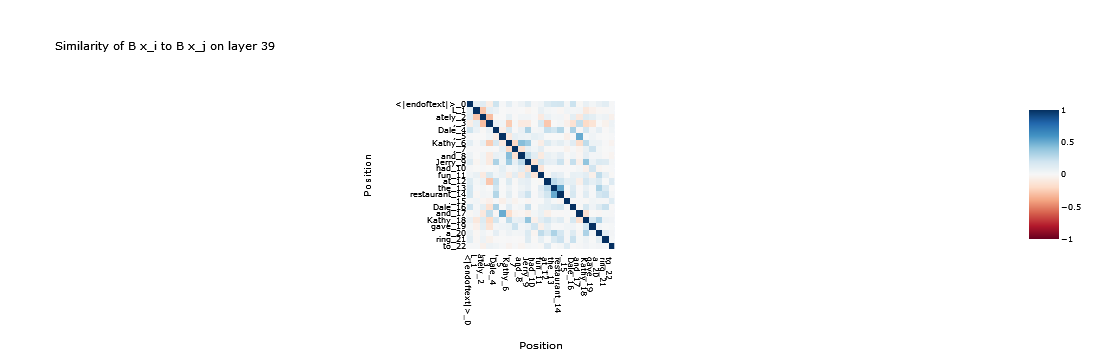

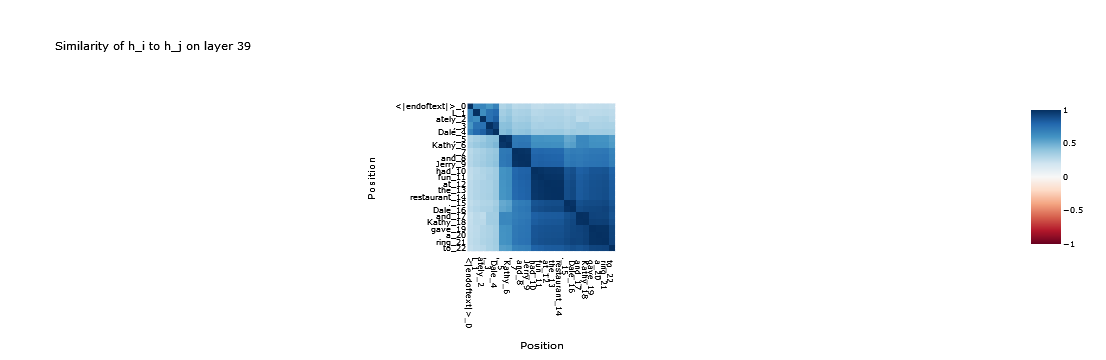

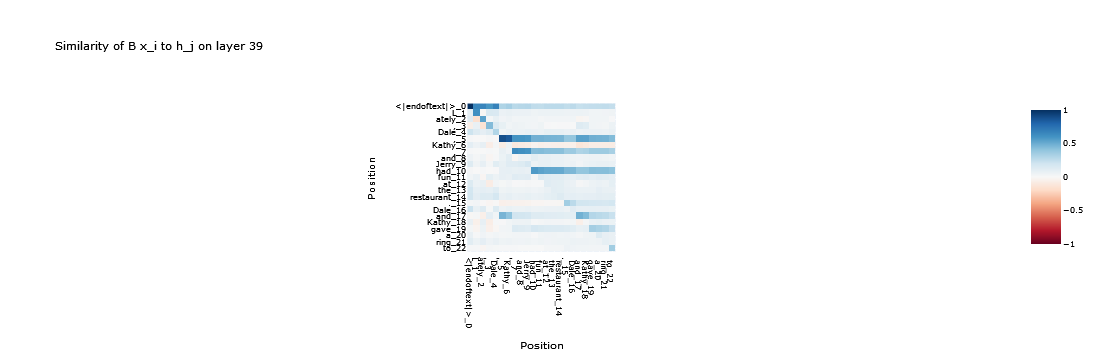

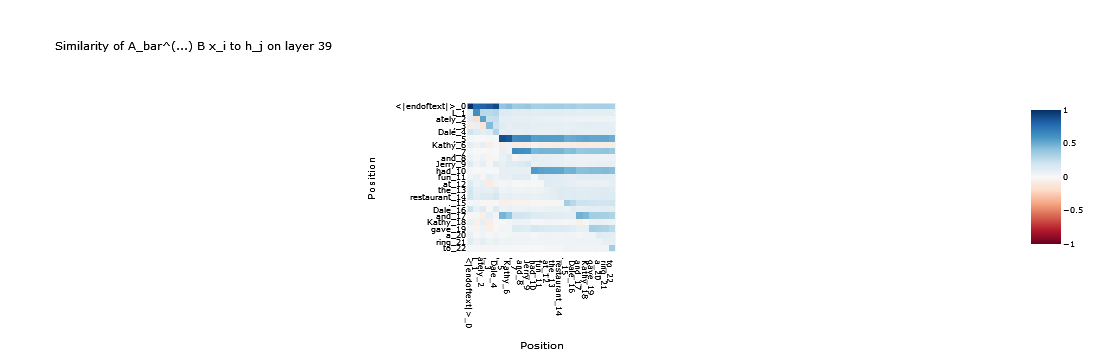

In [26]:

prompt = model.tokenizer.decode(batched_data[0][1:])
prompt_tokens = model.to_tokens(prompt)[0]
L = prompt_tokens.size()[0]
prompt_str_tokens = model.to_str_tokens(prompt_tokens)

token_labels = []
for index, str_token in enumerate(prompt_str_tokens):
    token_labels.append(f"{str_token}_{index}")

# for each pos
'''
layer_labels = [str(layer) for layer in limited_layers]
for pos in tqdm(list(range(L))):
    fig = imshow(h_to_x_b_similarities[:,pos], show=False, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Similarity to hidden state of token = {token_labels[pos]}", font_size=8)
    fig.update_layout(**plot_args)
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ))
    fig.show()
'''
LAYER = 39
imshow(x_b_similarities[LAYER], show=False, x=token_labels, y=token_labels, xaxis="Position", yaxis="Position", title=f"Similarity of B x_i to B x_j on layer {LAYER}", font_size=8).show()
imshow(h_similarities[LAYER], show=False, x=token_labels, y=token_labels, xaxis="Position", yaxis="Position", title=f"Similarity of h_i to h_j on layer {LAYER}", font_size=8).show()
imshow(h_to_x_b_similarities[LAYER], show=False, x=token_labels, y=token_labels, xaxis="Position", yaxis="Position", title=f"Similarity of B x_i to h_j on layer {LAYER}", font_size=8).show()
imshow(h_to_x_b_similarities_catchup[LAYER], show=False, x=token_labels, y=token_labels, xaxis="Position", yaxis="Position", title=f"Similarity of A_bar^(...) B x_i to h_j on layer {LAYER}", font_size=8).show()



## Interpreting Convs

In [17]:
TOP_N = 200


def get_conv_sims(all_tokens, layer_input_func):
    V,L,D,E = all_tokens.size()[0], 1, model.cfg.D, model.cfg.E
    D_conv = model.cfg.D_conv
    sims = torch.zeros([model.cfg.n_layers,V,D_conv+1], device=model.cfg.device)
    cosine_sims = torch.zeros([model.cfg.n_layers,V,D_conv+1], device=model.cfg.device)
    
    # todo: can we do the same thing for skip connection and B_bar (and maybe A_bar?)
    for INTERPRET_LAYER in tqdm(list(range(model.cfg.n_layers))):
        # [V,1,E]
        conv_input = layer_input_func(all_tokens=all_tokens, layer=INTERPRET_LAYER)
        # [E,1,D_CONV]
        conv_filters = model.blocks[INTERPRET_LAYER].conv1d.weight
        # [V,D]
        conv_input_vecs = conv_input[:,0,:]
        # [V,1]
        conv_input_vecs_mag = torch.linalg.norm(conv_input_vecs, ord=2, dim=1, keepdim=True)
        conv_input_vecs_mag[conv_input_vecs_mag==0] = 1.0 # prevent divide by zero
        # [V,D]                     [V,D]             [V,1]
        conv_input_normalized = conv_input_vecs * 1.0/conv_input_vecs_mag
        
        for conv_i in range(D_conv+1):
            if conv_i < D_conv:
                # [E,1]
                filter = conv_filters[:,0,conv_i].view(E,1)
            else:
                filter = model.blocks[INTERPRET_LAYER].conv1d.bias.view(E,1)
            # [V,L,1]  [V,L,E]   x [E,1]  # basically just [L,E] x [E,1] matmul for every V
            filter_sims    = conv_input @ filter
            # [V]                                  [V]
            sims[INTERPRET_LAYER,:,conv_i] = filter_sims[:,0,0]
        
            # [1]
            filter_mag = torch.linalg.norm(filter.view(E), ord=2, dim=0, keepdim=True)
            filter_mag[filter_mag==0] = 1.0 # no divide by zero
            # [E,1]              [E,1]      [1]
            filter_normalized = filter / filter_mag
            # [V,L,1]  [V,L,E]   x [E,1]  # basically just [L,E] x [E,1] matmul for every V
            filter_cosine_sims    = conv_input_normalized.view(V,1,E) @ filter_normalized
            cosine_sims[INTERPRET_LAYER,:,conv_i] = filter_cosine_sims[:,0,0]
    return sims, cosine_sims

def simple_projected_input(all_tokens, layer):
    # [V,L,D]
    V = all_tokens.size()[0]
    L = 1
    D = model.cfg.D
    input = model.embedding.weight[all_tokens].view(V,L,D)
    # [V,L,D]                                  [V,L,D]
    normalized_input = model.blocks[layer].norm(input)
    # [V,L,E]                        [D->E]     [V,L,D]
    conv_input = model.blocks[layer].in_proj(normalized_input)
    return conv_input

all_tokens = torch.arange(model.cfg.V, device=model.cfg.device)
print(all_tokens.size())
sims, cosine_sims = get_conv_sims(all_tokens=all_tokens, layer_input_func=simple_projected_input)

import pathlib

pathlib.Path("conv interp").mkdir(parents=True, exist_ok=True)
D_conv = model.cfg.D_conv
for INTERPRET_LAYER in range(model.cfg.n_layers):
    with open(f"conv interp/layer {INTERPRET_LAYER} conv sims all.txt", "w") as f:
        def write(s):
            f.write(s + "\n")
        write(f"layer {INTERPRET_LAYER}")
        for conv_i in range(D_conv+1):
            if conv_i == 0: continue # this one is always zeros for some reason
            if conv_i < D_conv:
                write(f"    conv filter {conv_i}")
            else:
                write(f"    bias")
            write(f"      unnormalized sims:")
            top_n = torch.argsort(-sims[INTERPRET_LAYER,:,conv_i])
            for i, tok_i in enumerate(top_n[:TOP_N]):
                tok = all_tokens[tok_i]
                write(f"        top {i} is {tok}={repr(model.tokenizer.decode([tok]))} with sim {sims[INTERPRET_LAYER,tok_i,conv_i]}")
            write(f"      cosine sims:")
            top_n = torch.argsort(-cosine_sims[INTERPRET_LAYER,:,conv_i])
            for i, tok_i in enumerate(top_n[:TOP_N]):
                tok = all_tokens[tok_i]
                write(f"        top {i} is {tok}={repr(model.tokenizer.decode([tok]))} with sim {cosine_sims[INTERPRET_LAYER,tok_i,conv_i]}")
        

torch.Size([50280])


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

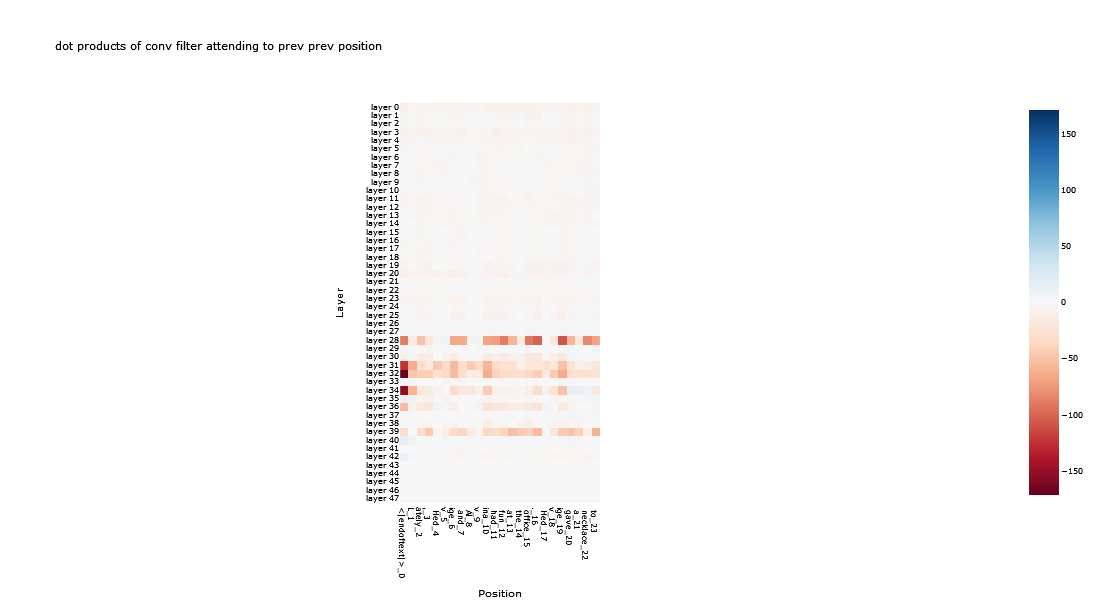

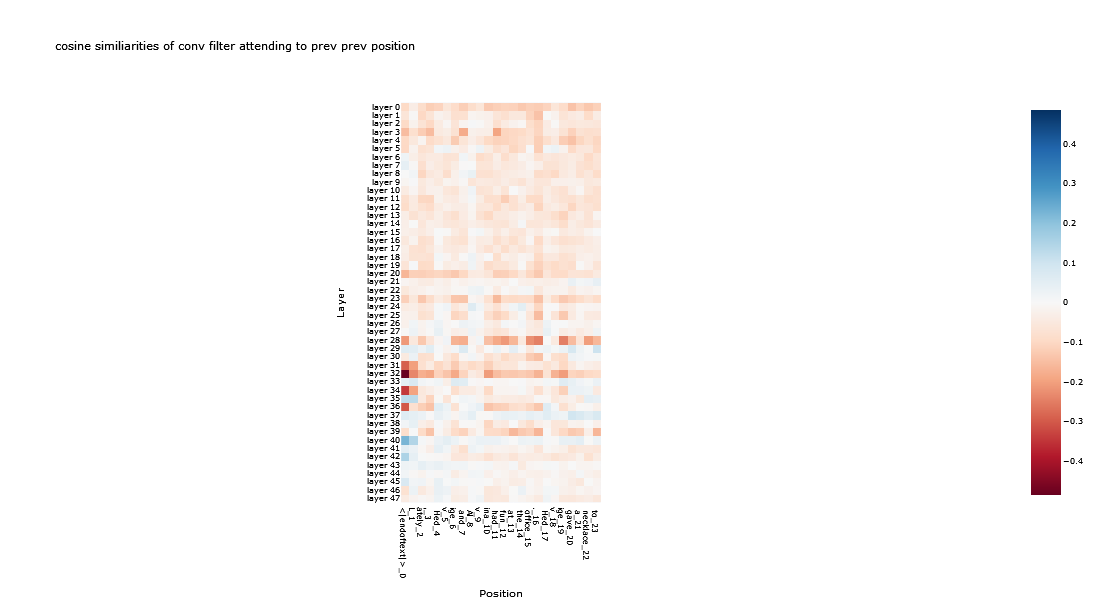

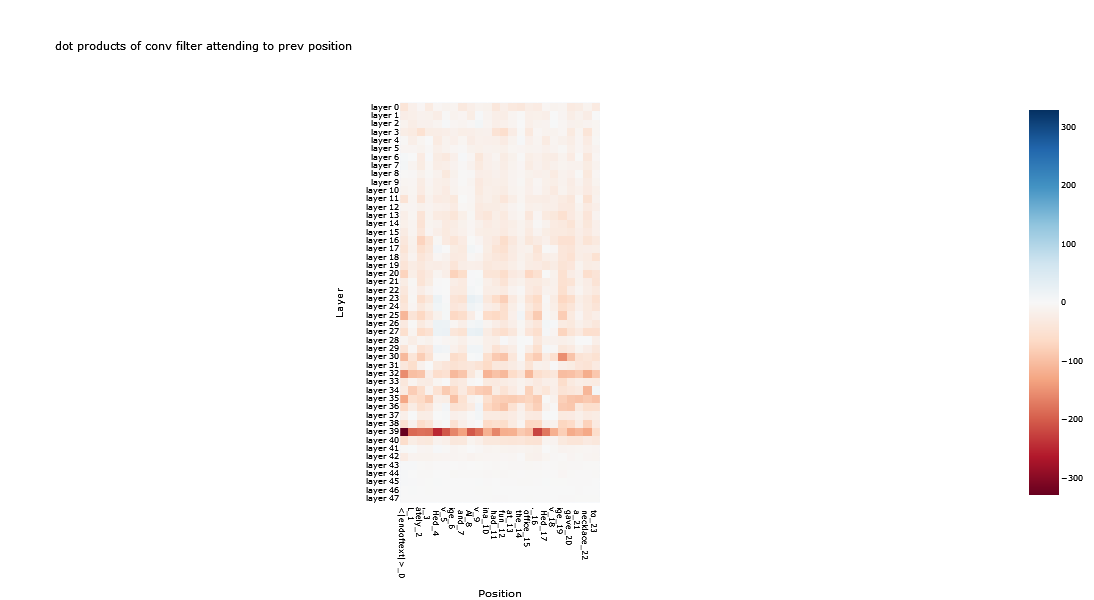

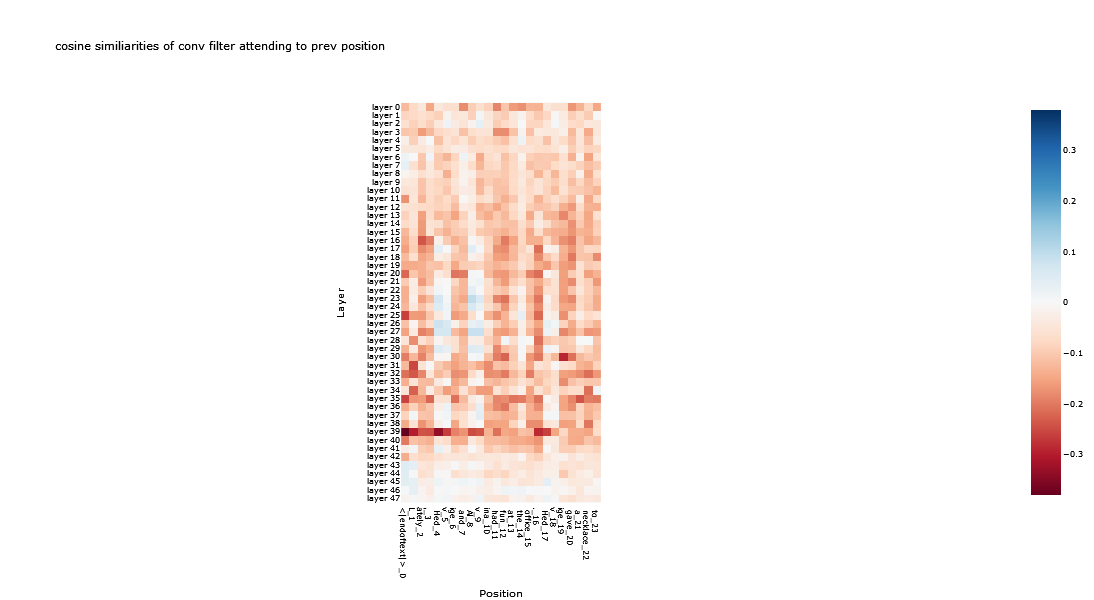

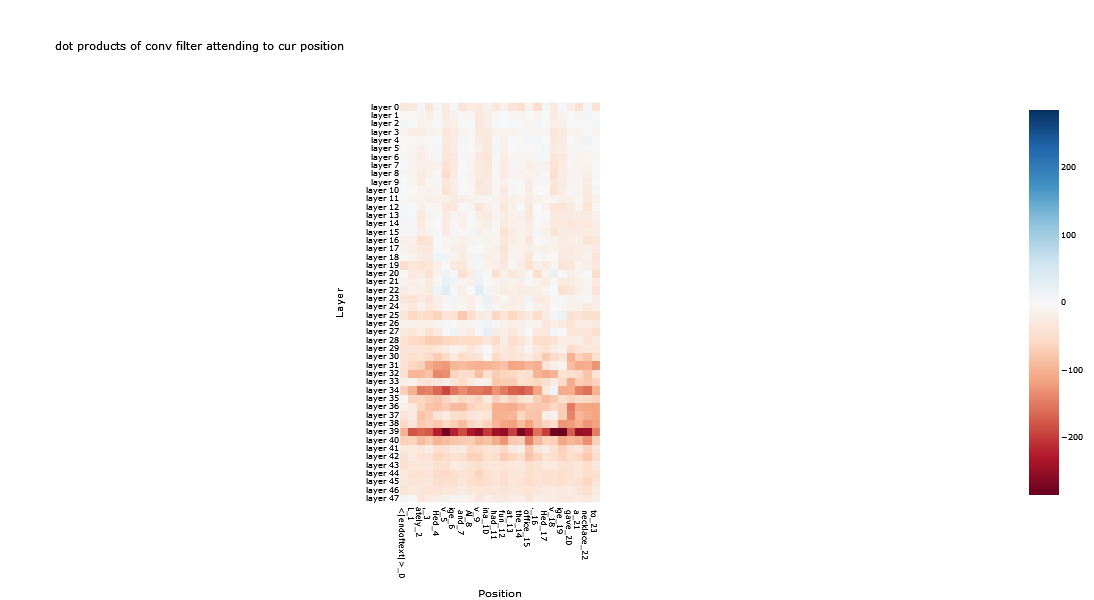

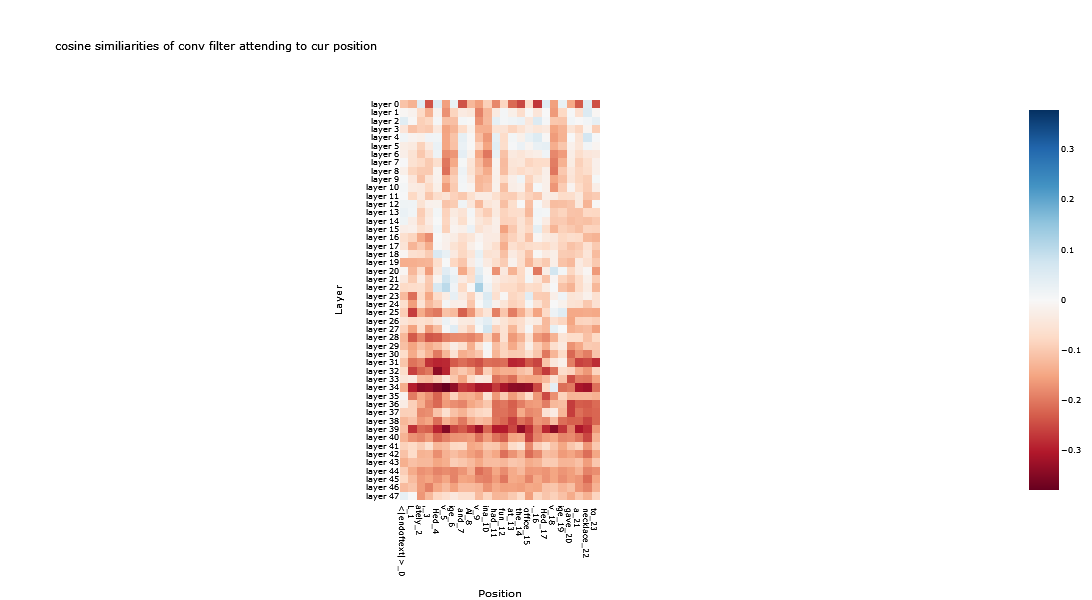

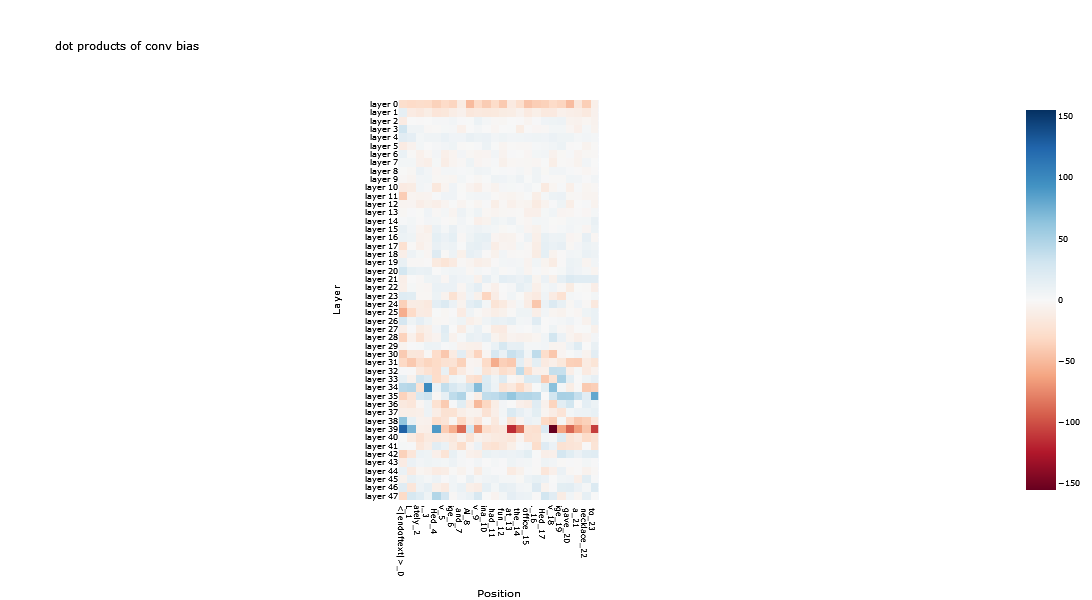

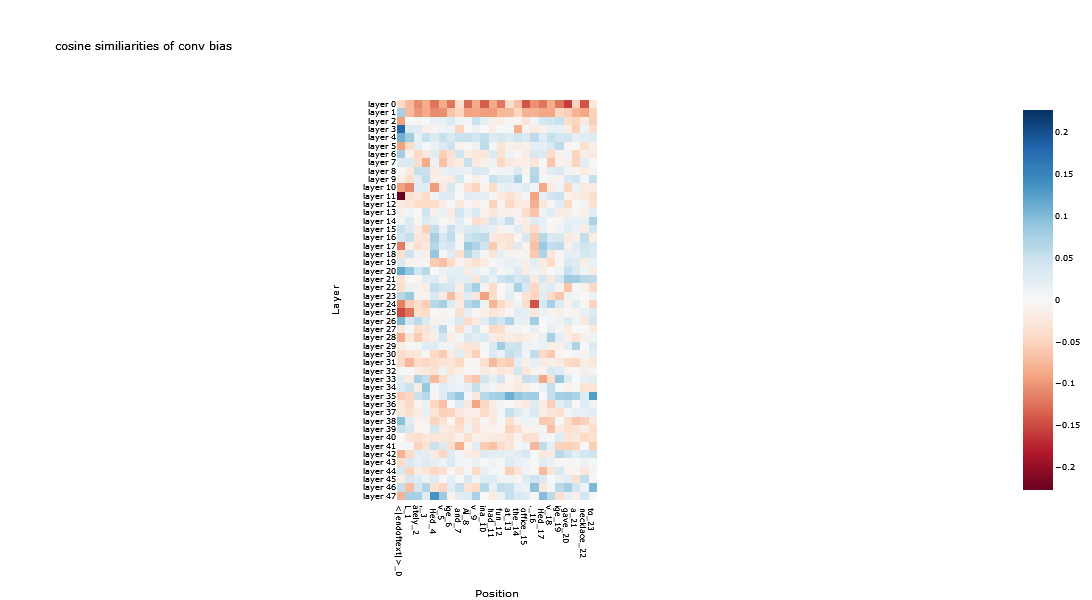

In [18]:
prompt = model.tokenizer.decode(batched_data[0][1:])
prompt_tokens = model.to_tokens(prompt)[0]
L = prompt_tokens.size()[0]
prompt_str_tokens = model.to_str_tokens(prompt_tokens)

token_labels = []
for index, str_token in enumerate(prompt_str_tokens):
    token_labels.append(f"{str_token}_{index}")

in_proj_names = []
for layer in range(model.cfg.n_layers):
    in_proj_names.append(f'blocks.{layer}.hook_in_proj')
logits, activations = model.run_with_cache(prompt_tokens.view(1,-1), names_filter=in_proj_names)

def hooked_layer_inputs(all_tokens, layer):
    # [B,L,E]
    conv_input = activations[f'blocks.{layer}.hook_in_proj']
    B,L,E = conv_input.size()
    return conv_input[0].view(L,1,E)
    
all_tokens = prompt_tokens

sims, cosine_sims = get_conv_sims(all_tokens=prompt_tokens, layer_input_func=hooked_layer_inputs)

conv_name_lookup = ['conv filter attending to cur position', 'conv bias']
for i in range(D_conv-1):
    conv_name_lookup = ["conv filter attending to " + " ".join(['prev']*(i+1)) + " position"] + conv_name_lookup
layer_labels = [f"layer {i}" for i in range(model.cfg.n_layers)]
for conv_i in range(D_conv+1):
    if conv_i == 0: continue # the first conv is always zero for some reason
    conv_str = f"{conv_name_lookup[conv_i]}"
    imshow(sims[:,:,conv_i], fix_size=True, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"dot products of {conv_str}", font_size=8)
    imshow(cosine_sims[:,:,conv_i], fix_size=True, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"cosine similiarities of {conv_str}", font_size=8)



## Batched Patching

In [91]:
# modified from neel nanda's examples

# this is useful because sometimes if you spam ctrl-c too many times some hooks will stay around
model.remove_all_hook_fns()

H_N_PATCHING_LAYER = 39
BATCH_SIZE = 10000

# default settings aren't very good, these are better
plot_args = {
    'width': 800,
    'height': 600,
    "autosize": False,
    'showlegend': True,
    'margin': {"l":0,"r":0,"t":100,"b":0}
}

#limited_layers = [0, 3, 10, 14, 15, 17, 18, 21, 22, 25, 26, 27, 28, 33, 36, 39, 40, 45, 46]
limited_layers = list(range(model.cfg.n_layers))
#limited_layers = [0, 3, 7, 10, 11, 14, 15, 16, 17, 19, 21, 23, 25, 26, 27, 28, 30, 33, 34, 39, 40, 45, 46, 47]
#limited_layers = [0, 7, 10, 11, 14, 15, 16, 17, 19, 23, 25, 27, 28, 33, 34, 39, 45, 46, 47]
#limited_layers = list(range(40)) + [40, 45, 46]
limited_layers = [0, 1, 7, 12, 16, 18, 20, 21, 24, 28, 33, 39, 44, 45]

limited_layers = [0, 8, 9, 11, 12, 14, 15, 18, 20, 21, 24, 25, 26, 27, 28, 33, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]

# grab first two data points as patching inputs
# the data generators will pair things nicely
# you can also just replace these with two strings
prompt_uncorrupted = model.tokenizer.decode(batched_data[0][1:])
prompt_corrupted = model.tokenizer.decode(batched_data[1][1:])

answer_tokens = sorted(list(set([x.item() for x in batched_correct[0]] + [x.item() for x in batched_correct[1]] + [x.item() for x in batched_incorrect[0]] + [x.item() for x in batched_incorrect[1]])))
uncorrupted_answer = model.tokenizer.decode([batched_correct[0,0]])
corrupted_answer = model.tokenizer.decode([batched_correct[1,0]])

# constrain_to_answers will constrain generation to only outputting those answers
correct, incorrect, acc = eval(
                            wrap_run_with_hooks(model=model, fwd_hooks=[], only_use_these_layers=limited_layers),
                            vbatched_data, vbatched_correct, vbatched_incorrect,
                            constrain_to_answers=constrain_to_answers)

# if you are doing constrain_to_answers, the prs will be relative (so within the given answers the pr will sum to 1)
# otherwise they will just be the prs given by softmax of the logits
print(f"baseline correct{relative_str}pr {correct} incorrect{relative_str}pr {incorrect} accuracy {acc}")

prompt_uncorrupted_tokens = model.to_tokens(prompt_uncorrupted)
prompt_corrupted_tokens = model.to_tokens(prompt_corrupted)

# logits should be [B,L,V] 
def uncorrupted_logit_minus_corrupted_logit(logits, uncorrupted_answer, corrupted_answer):
    uncorrupted_index = model.to_single_token(uncorrupted_answer)
    corrupted_index = model.to_single_token(corrupted_answer)
    return logits[0, -1, uncorrupted_index] - logits[0, -1, corrupted_index]

# prs should be [B,L,V] 
def uncorrupted_pr_minus_corrupted_pr(prs, uncorrupted_answer, corrupted_answer):
    uncorrupted_index = model.to_single_token(uncorrupted_answer)
    corrupted_index = model.to_single_token(corrupted_answer)
    return prs[0, -1, uncorrupted_index] - prs[0, -1, corrupted_index]

# [B,L,V]
corrupted_logits, corrupted_activations = model.run_with_cache(prompt_corrupted_tokens, only_use_these_layers=limited_layers)
corrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=corrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
corrupted_prs = torch.softmax(corrupted_logits, dim=2)
corrupted_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=corrupted_prs, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

# [B,L,V]
uncorrupted_logits = model(prompt_uncorrupted_tokens, only_use_these_layers=limited_layers)
uncorrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=uncorrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
uncorrupted_prs = torch.softmax(uncorrupted_logits, dim=2)
uncorrupted_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=uncorrupted_prs, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

uncorrupted_index = model.to_single_token(uncorrupted_answer)
corrupted_index = model.to_single_token(corrupted_answer)
print(f'uncorrupted prompt\n{prompt_uncorrupted}')
print(f"{repr(uncorrupted_answer)} logit {uncorrupted_logits[0,-1,uncorrupted_index]}")
print(f"{repr(uncorrupted_answer)} pr {uncorrupted_prs[0,-1,uncorrupted_index]}")
print(f"{repr(corrupted_answer)} logit {uncorrupted_logits[0,-1,corrupted_index]}")
print(f"{repr(corrupted_answer)} pr {uncorrupted_prs[0,-1,corrupted_index]}")
print(f'\ncorrupted prompt\n{prompt_corrupted}')
print(f"{repr(uncorrupted_answer)} logit {corrupted_logits[0,-1,uncorrupted_index]}")
print(f"{repr(uncorrupted_answer)} pr {corrupted_prs[0,-1,uncorrupted_index]}")
print(f"{repr(corrupted_answer)} logit {corrupted_logits[0,-1,corrupted_index]}")
print(f"{repr(corrupted_answer)} pr {corrupted_prs[0,-1,corrupted_index]}")

# We make a tensor to store the results for each patching run. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
L = len(prompt_uncorrupted_tokens[0])
if len(prompt_corrupted_tokens[0]) != len(prompt_uncorrupted_tokens[0]):
    raise Exception("Prompts are not the same length") # feel free to comment this out, you can patch for different sized prompts its just a lil sus



# make token labels that describe the patch
corrupted_str_tokens = model.to_str_tokens(prompt_corrupted_tokens)
uncorrupted_str_tokens = model.to_str_tokens(prompt_uncorrupted_tokens)
token_labels = []
for index, (corrupted_token, uncorrupted_token) in enumerate(zip(corrupted_str_tokens, uncorrupted_str_tokens)):
    if corrupted_token == uncorrupted_token:
        token_labels.append(f"{corrupted_token}_{index}")
    else:
        token_labels.append(f"{uncorrupted_token}->{corrupted_token}_{index}")

def run_patching(patching_type, patching_hook_name_func, patching_hook_func, batch_size, show_options, layers_to_patch_on, patch_positions=None, show_plot=True, **kwargs):
    torch.cuda.empty_cache()
    hook_title = patching_hook_name_func(layer='{layer}', position='{position}')
    print(f"running patching {patching_type}, using hook {hook_title}")
    global patching_result_logits, patching_result_prs # if you want to access it once this is done running
    n_layers = len(layers_to_patch_on)

    num_results = n_layers
    if patching_type == ACDC_LAYER_EDGE_PATCHING:
        num_results = n_layers
    elif patching_type == H_N_PATCHING:
        print(f"on layer H_N_PATCHING_LAYER={H_N_PATCHING_LAYER}")
        N = model.cfg.N
        num_results = N
    elif patching_type == CONV_FILTERS_PATCHING:
        D_conv = model.cfg.D_conv
        num_results = (D_conv-1)*n_layers # -1 because the zero one is always zero so we ignore it
    
    num_data_points = batched_data.size()[0]//2

    if patch_positions is None:
        patch_positions = list(range(L))
        
    num_positions = len(patch_positions)

    if patching_type == ACDC_LAYER_EDGE_PATCHING:
        num_positions = n_layers # does layer x layer
    
    patching_result_normalized_logits = torch.zeros((num_data_points, num_results, num_positions), device=model.cfg.device)
    patching_result_normalized_prs = torch.zeros((num_data_points, num_results, num_positions), device=model.cfg.device)

    num_answers = len(answer_tokens)
    patching_result_logits = torch.zeros((num_data_points, num_results, num_positions, num_answers), device=model.cfg.device)
    patching_result_prs = torch.zeros((num_data_points, num_results, num_positions, num_answers), device=model.cfg.device)
    
    hooks = []

    if patching_type == ACDC_LAYER_EDGE_PATCHING:
        for i, layer in enumerate(layers_to_patch_on):
            hooks.append((f'blocks.{layer}.hook_out_proj', partial(layer_output_storage_acdc_layer_edge_hook, layer=layer)))
        
    # skipping h needs A_bar stored, so also add that hook
    if patching_type == SKIPPING_H_PATCHING:
        for i, layer in enumerate(layers_to_patch_on):
            hooks.append((f'blocks.{layer}.hook_A_bar', partial(A_bar_storage_hook_for_skipping_h, layer=layer)))

    # skipping layer needs layer_input (resid_pre) stored, so also add that hook
    if patching_type == LAYER_SKIPPING:
        for i, layer in enumerate(layers_to_patch_on):
            hooks.append((f'blocks.{layer}.hook_resid_pre', partial(layer_input_storage_hook, layer=layer)))
    
    # conv filters needs conv_input (hook_in_proj) stored, so also add that hook
    if patching_type == CONV_FILTERS_PATCHING:
        for i, layer in enumerate(layers_to_patch_on):
            hooks.append((f'blocks.{layer}.hook_in_proj', partial(conv_input_storage_hook, layer=layer)))

    BATCH_OFFSET = 2 # first two are for uncorrupted and corrupted

    if patching_type == ACDC_LAYER_EDGE_PATCHING:
        batch = 0
        indices = []
        for i,input_layer in enumerate(layers_to_patch_on):
            for j,output_layer in enumerate(layers_to_patch_on):
                patching_hook_name = patching_hook_name_func(layer=output_layer, position=None)
                if input_layer >= output_layer: continue # only do i->j where i < j
                patching_hook = partial(patching_hook_func, input_layer=input_layer, output_layer=output_layer, batch=batch+BATCH_OFFSET)
                indices.append((i,j))
                hooks.append((patching_hook_name, patching_hook))
                batch += 1
                if batch_size != BATCH_SIZE_ALL: batch = batch % int(batch_size)
    elif patching_type == H_N_PATCHING:
        batch = 0
        indices = []
        for n in range(N):
            for position in patch_positions:
                patching_hook_name = patching_hook_name_func(layer=H_N_PATCHING_LAYER, position=position)
                patching_hook = partial(patching_hook_func, layer=H_N_PATCHING_LAYER, position=position, n=n, batch=batch+BATCH_OFFSET)
                indices.append((n,position))
                hooks.append((patching_hook_name, patching_hook))
                batch += 1
                if batch_size != BATCH_SIZE_ALL: batch = batch % int(batch_size)
    elif patching_type == CONV_FILTERS_PATCHING:
        batch = 0
        indices = []
        D_conv = model.cfg.D_conv
        ind = 0
        for i, layer in enumerate(layers_to_patch_on):
            for conv_filter_i in range(D_conv):
                if conv_filter_i == 0: continue # this is always zero for some reason
                for position in patch_positions:
                    patching_hook_name = patching_hook_name_func(layer=layer, position=position)
                    patching_hook = partial(patching_hook_func, layer=layer, position=position, batch=batch+BATCH_OFFSET, conv_filter_i=conv_filter_i)
                    indices.append((ind,position))
                    hooks.append((patching_hook_name, patching_hook))
                    batch += 1
                    if batch_size != BATCH_SIZE_ALL: batch = batch % int(batch_size)
                ind += 1
    else:
        batch = 0
        indices = []
        for i, layer in enumerate(layers_to_patch_on):
            for position in patch_positions:
                patching_hook_name = patching_hook_name_func(layer=layer, position=position)
                patching_hook = partial(patching_hook_func, layer=layer, position=position, batch=batch+BATCH_OFFSET)
                indices.append((i,position))
                hooks.append((patching_hook_name, patching_hook))
                batch += 1
                if batch_size != BATCH_SIZE_ALL: batch = batch % int(batch_size)

    for uncorrupted_i in tqdm(list(range(0,batched_data.size()[0],2))):
        corrupted_i = uncorrupted_i+1
        result_i = uncorrupted_i//2
        # [1+len(indicies),L]
        uncorrupted_data = batched_data[uncorrupted_i:uncorrupted_i+1]
        corrupted_data = batched_data[corrupted_i:corrupted_i+1]
            
        if batch_size != BATCH_SIZE_ALL:
            run_data = torch.cat([uncorrupted_data, corrupted_data, uncorrupted_data.repeat((int(batch_size),1))], dim=0)
            V = model.cfg.V
            patched_logits = torch.zeros([len(indices)+2, L, V])
            for batch_start in tqdm(list(range(0, len(indices), int(batch_size)))):
                batch_end = min(len(indices), batch_start+int(batch_size))
                batch_hooks = hooks[batch_start:batch_end]
                cur_batch_size = batch_end-batch_start
                output_logits = model.run_with_hooks(run_data, fwd_hooks=batch_hooks, only_use_these_layers=limited_layers, **kwargs)
                if batch_start == 0:
                    patched_logits[0:2] = output_logits[:2]
                patched_logits[batch_start+2:batch_end+2] = output_logits[2:][:cur_batch_size] # skip the first two which are for uncorrupted and corrupted
        else:
            run_data = torch.cat([uncorrupted_data, corrupted_data, uncorrupted_data.repeat((len(indices),1))], dim=0)
            # [B,L,V]
            patched_logits = model.run_with_hooks(run_data, fwd_hooks=hooks, only_use_these_layers=limited_layers, **kwargs)
       
        # [B,L,V]
        patched_prs = torch.softmax(patched_logits, dim=2)

        # [B,L,V]
        uncorrupted_logits = patched_logits[0:1]
        uncorrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=uncorrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
        uncorrupted_prs = torch.softmax(uncorrupted_logits, dim=2)
        uncorrupted_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=uncorrupted_prs, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)

        # [B,L,V]
        corrupted_logits = patched_logits[1:2]
        corrupted_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=corrupted_logits, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
        corrupted_prs = torch.softmax(corrupted_logits, dim=2)
        corrupted_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=corrupted_prs, uncorrupted_answer=uncorrupted_answer, corrupted_answer=corrupted_answer)
        
        
        for b_, (i,position) in enumerate(indices):
            b = b_+2 # the first and second position is reserved for uncorrupted and corrupted, respectively
            if corrupted_answer != uncorrupted_answer:
                # diff is logit of uncorrupted_answer - logit of corrupted_answer
                # we expect corrupted_diff to have a negative value (as corrupted should put high pr on corrupted_answer)
                # we expect uncorrupted to have a positive value (as uncorrupted should put high pr on uncorrupted_answer)
                # thus we can treat these as (rough) min and max possible values

                min_logit_diff = corrupted_logit_diff
                max_logit_diff = uncorrupted_logit_diff
                
                min_pr_diff = corrupted_pr_diff
                max_pr_diff = uncorrupted_pr_diff

                
                patched_logit_diff = uncorrupted_logit_minus_corrupted_logit(logits=patched_logits[b:b+1],
                                                                             uncorrupted_answer=uncorrupted_answer,
                                                                             corrupted_answer=corrupted_answer)
                # normalize it so
                # 0 means min_logit_diff (so 0 means that it is acting like the corrupted model)
                # 1 means max_logit_diff (so 1 means that it is acting like the uncorrupted model)
                normalized_patched_logit_diff = (patched_logit_diff-min_logit_diff)/(max_logit_diff - min_logit_diff)
                # now flip them, since most interventions will do nothing and thus act like uncorrupted model, visually its better to have that at 0
                # so now
                # 0 means that it is acting like the uncorrupted model
                # 1 means that it is acting like the corrupted model
                normalized_patched_logit_diff = 1.0 - normalized_patched_logit_diff
                patching_result_normalized_logits[uncorrupted_i//2, i, position] += normalized_patched_logit_diff
                
                # same for pr
                patched_pr_diff = uncorrupted_pr_minus_corrupted_pr(prs=patched_prs[b:b+1],
                                                                    uncorrupted_answer=uncorrupted_answer,
                                                                    corrupted_answer=corrupted_answer)
                normalized_patched_pr_diff = 1.0-(patched_pr_diff-min_pr_diff)/(max_pr_diff - min_pr_diff)
                patching_result_normalized_prs[uncorrupted_i//2, i, position] += normalized_patched_pr_diff
    
            for k, answer_token in enumerate(answer_tokens):
                patching_result_logits[uncorrupted_i//2, i, position, k] += patched_logits[b,-1,answer_token]
                patching_result_prs[uncorrupted_i//2, i, position, k] += patched_prs[b,-1,answer_token]

    if show_plot:
        print("done patching, displaying results...")
 
        if patching_type == H_N_PATCHING:
            layer_labels = [str(n) for n in range(N)]
        elif patching_type == CONV_FILTERS_PATCHING:
            layer_labels = []
            for layer in layers_to_patch_on:
                for conv_i in range(1, D_conv):
                    layer_labels.append(f"layer {layer} conv {conv_i-D_conv+1}")
        else:
            layer_labels = [str(layer) for layer in layers_to_patch_on]
        figs = []
        points_per_data_format = num_data_points//len(all_formats)
        for data_i, data_start in enumerate(range(0, num_data_points, points_per_data_format)):
            data_end = data_start+points_per_data_format

            # make token labels that describe the patch
            uncorrupted_str_tokens = model.to_str_tokens(batched_data[data_start*2])
            corrupted_str_tokens = model.to_str_tokens(batched_data[data_start*2+1])
            token_labels = []
            for index, (corrupted_token, uncorrupted_token) in enumerate(zip(corrupted_str_tokens, uncorrupted_str_tokens)):
                if corrupted_token == uncorrupted_token:
                    token_labels.append(f"{corrupted_token}_{index}")
                else:
                    token_labels.append(f"{uncorrupted_token}->{corrupted_token}_{index}")

            # this just does layer x layer
            if patching_type == ACDC_LAYER_EDGE_PATCHING:
                token_labels = [str(layer) for layer in layers_to_patch_on] 
            
            # this annotation describes the patching format on the side
            ANNOTATION_FONT_SIZE = 10
            def add_annotation(fig, annotation):
                for i, line in enumerate(annotation.split("\n")):
                    fig.add_annotation(dict(font=dict(color='black',size=ANNOTATION_FONT_SIZE),
                                        x=0,
                                        y=0.9-i*0.05,
                                        showarrow=False,
                                        text=line,
                                        textangle=0,
                                        xanchor='left',
                                        yanchor='bottom',
                                        xref="paper",
                                        yref="paper"))
            
            if corrupted_answer != uncorrupted_answer:
                if show_options in [SHOW_LOGITS, SHOW_BOTH]:
                    figs.append(imshow(patching_result_normalized_logits[data_start:data_end].mean(dim=0), show=False, fix_size=True, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Normalized logit difference after patching {patching_type} using hook {hook_title}", font_size=8))
                    add_annotation(figs[-1], all_formats[data_i])
                if show_options in [SHOW_PR, SHOW_BOTH]:
                    figs.append(imshow(patching_result_normalized_prs[data_start:data_end].mean(dim=0), show=False, fix_size=True, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Normalized pr difference after patching {patching_type} using hook {hook_title}", font_size=8))
                    add_annotation(figs[-1], all_formats[data_i])
            data_format = all_formats[data_i]
            format_path = "patching_outputs/" + data_format.replace("\n", "   ")
            pathlib.Path(format_path).mkdir(parents=True, exist_ok=True)
            figs[-1].write_image(format_path + "/" + patching_type + ".png")

        if show_options in [SHOW_LOGITS, SHOW_BOTH]:
            figs.append(imshow(patching_result_normalized_logits.mean(dim=0), show=False, fix_size=True, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Normalized logit difference after patching {patching_type} using hook {hook_title}", font_size=8))
            add_annotation(figs[-1], "average")
        if show_options in [SHOW_PR, SHOW_BOTH]:
            figs.append(imshow(patching_result_normalized_prs.mean(dim=0), show=False, fix_size=True, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Normalized pr difference after patching {patching_type} using hook {hook_title}", font_size=8))
            add_annotation(figs[-1], "average")
        
        for k, answer_token in enumerate(answer_tokens):
            if show_options in [SHOW_LOGITS, SHOW_BOTH]:
                figs.append(imshow(patching_result_logits.mean(dim=0)[:,:,k], fix_size=True, color_continuous_midpoint=None, show=False, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Logit of uncorrupted answer {repr(model.tokenizer.decode([answer_token]))} after patching {patching_type} using hook {hook_title}", font_size=8))
            if show_options in [SHOW_PR, SHOW_BOTH]:
                figs.append(imshow(patching_result_prs.mean(dim=0)[:,:,k], fix_size=True, show=False, x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Pr of uncorrupted answer {repr(model.tokenizer.decode([answer_token]))} after patching {patching_type} using hook {hook_title}", font_size=8)) 
    
        for fig in figs:
            fig.show()
    return patching_result_normalized_logits, patching_result_normalized_prs, patching_result_logits, patching_result_prs

CORRUPTED_BATCH = 1

## hooks for conv filter patching
def conv_input_storage_hook(
    conv_input: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L E"]:
    global storage
    storage = {}
    storage['conv_input'] = conv_input
    return conv_input

def conv_patching_hook(
    conv_output: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    layer: int,
    position: int,
    batch: int,
    conv_filter_i: int,
) -> Float[torch.Tensor, "B L E"]:
    
    global storage
    conv_input = storage['conv_input']
    B, L, E = conv_input.size()
    conv_input = rearrange(conv_input, 'B L E -> B E L')
    
    ### This is identical to what the conv is doing
    # pad zeros in front
    # [B,E,D_CONV-1+L]
    D_CONV = model.cfg.d_conv
    padded_input = torch.nn.functional.pad(conv_input, (D_CONV-1,0), mode='constant', value=0)
    output = torch.zeros([B,E,L], device=model.cfg.device)
    # [E,1,D_CONV]
    conv_weight = model.blocks[layer].conv1d.weight
    # [E]
    conv_bias = model.blocks[layer].conv1d.bias
    # this is inefficient because its recomputing things every time
    # but I don't want to have to rely on the ordering of hooks because that's sus
    # so this is good enough
    for i in range(D_CONV):
        filter_str = f'filter_{i}'
        if not filter_str in storage:
            # [B,E,L]                      [E,1]                      [B,E,L]
            filter_contribution = conv_weight[:,0,i].view(E,1)*padded_input[:,:,i:i+L]
            storage[filter_str] = filter_contribution
        filter_contribution = storage[filter_str]
        if i == conv_filter_i:
            # [E,L]                                   [E,1]                             [E,L]
            corrupted_filter_contribution = conv_weight[:,0,i].view(E,1)*padded_input[CORRUPTED_BATCH,:,i:i+L]
            # [E]                                                    [E]
            filter_contribution[batch,:,position] = corrupted_filter_contribution[:,position]
        storage[filter_str] = filter_contribution
        output += filter_contribution
        #output += conv_weight[:,0,i].view(E,1)*conv_input
        #if i == D_CONV-1:
        #    output += conv_weight[:,0,i].view(E,1)*conv_input

    # bias is not dependent on input so no reason to patch on it, just apply it as normal
    output += conv_bias.view(E, 1)
    
    output = rearrange(output, 'B E L -> B L E')
    return output



## hooks for ACDC layer edge step
def layer_input_acdc_layer_edge_hook(
    layer_input: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    input_layer: int,
    output_layer: int,
    batch: int,
) -> Float[torch.Tensor, "B L D"]:
    global storage
    input_resid_uncorrupted = storage[input_layer][0]
    input_resid_corrupted = storage[input_layer][1]
    layer_input_out = layer_input.clone()
    # remove the uncorrupted and add the corrupted
    layer_input[batch] = layer_input[batch]-input_resid_uncorrupted+input_resid_corrupted
    return layer_input

# hook_out_proj is the term added to the resid
def layer_output_storage_acdc_layer_edge_hook(
    layer_output: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L D"]:
    global storage
    if layer == 0:
        storage = {}
    storage[layer] = layer_output[:2] # first two are uncorrupted and corrupted, we only need those nothing else
    return layer_output





## hooks for layer skipping
def layer_input_storage_hook(
    layer_input: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    layer: int,
    position: int,
) -> Float[torch.Tensor, "B L D"]:
    global storage
    storage = {}
    storage['layer_input'] = layer_input
    return layer_input

def layer_output_skipping_hook(
    layer_output: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    position: int,
    layer: int,
    batch: int,
) -> Float[torch.Tensor, "B L D"]:
    global storage
    layer_input = storage['layer_input']
    # intervene on the batch at the position
    layer_output[batch,position,:] = layer_input[batch,position,:]
    return layer_output


## hooks for h skipping
def A_bar_storage_hook_for_skipping_h(
    A_bar: Float[torch.Tensor, "B L E N"],
    hook: HookPoint,
    layer: int,
) -> Float[torch.Tensor, "B L E N"]:
    global storage
    storage = {}
    storage['A_bar'] = A_bar
    return A_bar

def skipping_h_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    position: int,
    layer: int,
    batch: int,
) -> Float[torch.Tensor, "B E N"]:
    #print("fetching", storage[grab_pos][0,0,0:5], "from position", grab_pos)
    #print("my value (being ignore) is", h[0,0,0:5])
    #print(f"skipping ahead h at position {position}")
    global storage
    B,E,N = h.size()
    grab_pos = position-1
    if grab_pos < 0:
        h[batch,:,:] = torch.zeros((E,N), device=model.cfg.device)
    else:
        B,E,N = h.size()
        A_contribution = torch.ones((E,N), device=model.cfg.device)
        for missed_pos in range(grab_pos+1, position+1):
            A_contribution *= storage['A_bar'][batch,missed_pos,:,:]
        h_stored = storage[grab_pos][batch,:,:]
        h[batch,:,:] = A_contribution*h_stored
        #return A_contribution*storage[grab_pos]
    storage[position] = h
    return h


## Regular patching hooks
def position_patching_hook( # also works for B L E, B L E N, and B L N sized things
    x: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    position: int,
    layer: int, # we don't care about this
    batch: int,
) -> Float[torch.Tensor, "B L D"]:
    # only intervene on the specific pos
    x[batch, position, :] = x[CORRUPTED_BATCH, position, :]
    return x

def h_patching_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    position: int,
    layer: int,
    batch: int,
) -> Float[torch.Tensor, "B E N"]:
    h[batch] = h[CORRUPTED_BATCH]
    return h

def h_n_patching_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
    position: int,
    layer: int,
    n: int,
    batch: int,
) -> Float[torch.Tensor, "B E N"]:
    h[batch,:,n] = h[CORRUPTED_BATCH,:,n]
    return h

SKIPPING_H_PATCHING = 'skipping h'
H_N_PATCHING = 'h_n'
LAYER_SKIPPING = 'skipping layer'
CONV_FILTERS_PATCHING = 'conv filters'
ACDC_LAYER_EDGE_PATCHING = 'acdc layer edge'

patching_types = {
    'normalized input': (lambda layer, position: f'blocks.{layer}.hook_normalized_input', position_patching_hook),
    'layer input': (lambda layer, position: f'blocks.{layer}.hook_resid_pre', position_patching_hook),
    'skip': (lambda layer, position: f'blocks.{layer}.hook_skip', position_patching_hook), 
    'in proj': (lambda layer, position: f'blocks.{layer}.hook_in_proj', position_patching_hook), 
    CONV_FILTERS_PATCHING: (lambda layer, position: f'blocks.{layer}.hook_conv', conv_patching_hook),
    'conv': (lambda layer, position: f'blocks.{layer}.hook_conv', position_patching_hook), 
    'ssm input': (lambda layer, position: f'blocks.{layer}.hook_ssm_input', position_patching_hook),
    'delta 1': (lambda layer, position: f'blocks.{layer}.hook_delta_1', position_patching_hook), 
    'delta 2': (lambda layer, position: f'blocks.{layer}.hook_delta_2', position_patching_hook), 
    'delta': (lambda layer, position: f'blocks.{layer}.hook_delta', position_patching_hook), 
    'A_bar': (lambda layer, position: f'blocks.{layer}.hook_A_bar', position_patching_hook), 
    'B': (lambda layer, position: f'blocks.{layer}.hook_B', position_patching_hook), 
    'B_bar': (lambda layer, position: f'blocks.{layer}.hook_B_bar', position_patching_hook), 
    'C': (lambda layer, position: f'blocks.{layer}.hook_C', position_patching_hook), 
    SKIPPING_H_PATCHING: (lambda layer, position: f'blocks.{layer}.hook_h.{position}', skipping_h_hook),
    'h': (lambda layer, position: f'blocks.{layer}.hook_h.{position}', h_patching_hook),
    H_N_PATCHING: (lambda layer, position: f'blocks.{layer}.hook_h.{position}', h_n_patching_hook),
    'y': (lambda layer, position: f'blocks.{layer}.hook_y', position_patching_hook),
    'ssm output': (lambda layer, position: f'blocks.{layer}.hook_ssm_output', position_patching_hook),
    'after skip': (lambda layer, position: f'blocks.{layer}.hook_after_skip', position_patching_hook),
    'out proj': (lambda layer, position: f'blocks.{layer}.hook_out_proj', position_patching_hook),
    'resid post': (lambda layer, position: f'blocks.{layer}.hook_resid_post', position_patching_hook),
    LAYER_SKIPPING: (lambda layer, position: f'blocks.{layer}.hook_resid_post', layer_output_skipping_hook),
    ACDC_LAYER_EDGE_PATCHING: (lambda layer, position: f'blocks.{layer}.hook_layer_input', layer_input_acdc_layer_edge_hook),
}

patching_types_keys = list(patching_types.keys())

def choose_patching_type(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_patching_type.patching_type = change['new'] # hack, gives this function the patching_type attribute

choose_patching_type.patching_type = patching_types_keys[0]

patching_type_dropdown = ipywidgets.Dropdown(
    options=patching_types_keys,
    value=patching_types_keys[0],
    description='Patching Type',
)
patching_type_dropdown.observe(choose_patching_type)
display(patching_type_dropdown)

BATCH_SIZE_ALL = 'all'
batch_size_keys = [BATCH_SIZE_ALL] + [str(b) for b in range(model.cfg.n_layers*model.cfg.D_conv*L)]

def choose_batch_size(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_batch_size.batch_size = change['new']

choose_batch_size.batch_size = batch_size_keys[0]

choose_batch_size_dropdown = ipywidgets.Dropdown(
    options=batch_size_keys,
    value=batch_size_keys[0],
    description='batch size',
)
choose_batch_size_dropdown.observe(choose_batch_size)
display(choose_batch_size_dropdown)

fast_conv_keys = ['True', 'False']

def choose_fast_conv(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_fast_conv.fast_conv = change['new'] == 'True'

choose_fast_conv.fast_conv = fast_conv_keys[0] == 'True'

choose_fast_conv_dropdown = ipywidgets.Dropdown(
    options=fast_conv_keys,
    value=fast_conv_keys[0],
    description='fast conv',
)
choose_fast_conv_dropdown.observe(choose_fast_conv)
display(choose_fast_conv_dropdown)


fast_ssm_keys = ['False', 'True']

def choose_fast_ssm(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_fast_ssm.fast_ssm = change['new'] == 'True'

choose_fast_ssm.fast_ssm = fast_ssm_keys[0] == 'True'

choose_fast_ssm_dropdown = ipywidgets.Dropdown(
    options=fast_ssm_keys,
    value=fast_ssm_keys[0],
    description='fast ssm',
)
choose_fast_ssm_dropdown.observe(choose_fast_ssm)
display(choose_fast_ssm_dropdown)

SHOW_PR = 'Pr'
SHOW_LOGITS = 'Logits'
SHOW_BOTH = 'Both'
show_options = [SHOW_LOGITS, SHOW_PR, SHOW_BOTH]

def choose_show_options(change):
    if change['type'] == 'change' and change['name'] == 'value':
        choose_show_options.show_options = change['new']

choose_show_options.show_options = show_options[0]

show_options_dropdown = ipywidgets.Dropdown(
    options=show_options,
    value=show_options[0],
    description='logits or pr',
)
show_options_dropdown.observe(choose_show_options)
display(show_options_dropdown)
def do_patching(arg, show_plot=True):
    with output: # this lets the stuff we output here be visible
        clear_output()
        patching_type = choose_patching_type.patching_type
        hook_name_func, hook_func = patching_types[patching_type]
        return run_patching(
                     patching_type=patching_type,
                     patching_hook_name_func=hook_name_func,
                     patching_hook_func=hook_func,
                     batch_size=choose_batch_size.batch_size,
                     fast_ssm=choose_fast_ssm.fast_ssm,
                     fast_conv=choose_fast_conv.fast_conv,
                     show_options=choose_show_options.show_options,
                     layers_to_patch_on=limited_layers,
                     show_plot=show_plot)

patching_button = ipywidgets.Button(description = 'Run Patching')
patching_button.on_click(do_patching)
display(patching_button)


# you can't just display stuff inside a widget callback, you need a wrap any display code in this
output = ipywidgets.Output()
display(output)


baseline correct relative pr 0.8733358383178711 incorrect relative pr 0.1266641616821289 accuracy 0.92
uncorrupted prompt
Lately, Kate, Chelsea, and Pam had fun at the house. Chelsea and Pam gave a necklace to
' Kate' logit 12.060500144958496
' Kate' pr 0.0462447889149189
' Olive' logit 4.769355773925781
' Olive' pr 3.151802593492903e-05

corrupted prompt
Lately, Olive, Chelsea, and Pam had fun at the house. Chelsea and Pam gave a necklace to
' Kate' logit 8.108930587768555
' Kate' pr 0.0004152756300754845
' Olive' logit 10.760531425476074
' Olive' pr 0.005887244362384081


Dropdown(description='Patching Type', options=('normalized input', 'layer input', 'skip', 'in proj', 'conv fil…

Dropdown(description='batch size', options=('all', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11…

Dropdown(description='fast conv', options=('True', 'False'), value='True')

Dropdown(description='fast ssm', options=('False', 'True'), value='False')

Dropdown(description='logits or pr', options=('Logits', 'Pr', 'Both'), value='Logits')

Button(description='Run Patching', style=ButtonStyle())

Output()

## Layer Patching

In [29]:

BATCH_SIZE = 1000

# todo: double up things but swapped, so it's symmetric
def patch_layer_hook(
    layer_output: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
) -> Float[torch.Tensor, "B L D"]:
    # patch in corrupted (they come in pairs)
    for i in range(0, layer_output.size()[0], 2):
        layer_output[i] = layer_output[i+1]
    return layer_output

#limited_layer_set = [0, 7, 10, 11, 14, 15, 16, 17, 19, 23, 25, 27, 28, 33, 34, 39, 45, 46, 47]

def wrap_patch_specific_layers(model, layers_to_patch, **kwargs):
    hooks = []
    for layer in layers_to_patch:
        hooks.append((f"blocks.{layer}.hook_out_proj", patch_layer_hook))
    
    def wrapper(input):
        return model.run_with_hooks(input, fwd_hooks=hooks, **kwargs)
    wrapper.tokenizer = model.tokenizer
    wrapper.cfg = model.cfg
    return wrapper

print(f"constraining output to answers? {constrain_to_answers}")

print(f"num layers {model.cfg.n_layers}")

        
pbatched_data = repeat_swapped_patch(batched_data)
pbatched_correct = repeat_swapped_patch(batched_correct)
pbatched_incorrect = repeat_swapped_patch(batched_incorrect)
vpbatched_data = repeat_swapped_patch(vbatched_data)
vpbatched_correct = repeat_swapped_patch(vbatched_correct)
vpbatched_incorrect = repeat_swapped_patch(vbatched_incorrect)


history = []
history_stats = []
layers_to_patch = []

while len(layers_to_patch) < model.cfg.n_layers:
    remaining_layers = list(range(model.cfg.n_layers))
    for layer in layers_to_patch:
        remaining_layers.remove(layer)
    print("layers not patched", remaining_layers)
    print("layers patched", layers_to_patch)
    correct, incorrect, acc = eval(
                                    wrap_patch_specific_layers(model=model, layers_to_patch=layers_to_patch, fast_ssm=True, fast_conv=True),
                                    vpbatched_data, vpbatched_correct, vpbatched_incorrect,
                                    constrain_to_answers=constrain_to_answers,
                                    batch_size=BATCH_SIZE,
                                    patch=True)
    print(f"correct{relative_str}pr {correct} incorrect{relative_str}pr {incorrect} accuracy {acc}")
    history_stats.append((correct, incorrect, acc))
    
    out_acc = torch.zeros([len(remaining_layers)], device=model.cfg.device)
    out_prs_correct = torch.zeros([len(remaining_layers)], device=model.cfg.device)
    out_prs_incorrect = torch.zeros([len(remaining_layers)], device=model.cfg.device)
        
    for i, start_layer in tqdm(list(enumerate(remaining_layers))):
        #layers = list(range(start_layer, end_layer+1))
        patching_layers = layers_to_patch + [start_layer]
        
        correct, incorrect, acc = eval(
                                    wrap_patch_specific_layers(model=model, layers_to_patch=patching_layers, fast_ssm=True, fast_conv=True),
                                    pbatched_data, pbatched_correct, pbatched_incorrect,
                                    constrain_to_answers=constrain_to_answers,
                                    batch_size=BATCH_SIZE,
                                    patch=True)
        out_prs_correct[i] = correct
        out_prs_incorrect[i] = incorrect
        out_acc[i] = acc

    print(out_acc)
    best_layer_to_patch = remaining_layers[torch.argsort(-out_acc)[0]]
    print("patching layer", best_layer_to_patch, f"with acc {out_acc[remaining_layers.index(best_layer_to_patch)]}")
    layers_to_patch.append(best_layer_to_patch)

history_stats = torch.tensor(history_stats)

constraining output to answers? True
num layers 48
layers not patched [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
layers patched []
correct relative pr 0.786421537399292 incorrect relative pr 0.2135784775018692 accuracy 0.91


  0%|          | 0/48 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Layer Removal

In [28]:
BATCH_SIZE = 1000

# zero ablating the value that is added to resid is the same as removing the layer
def hook_out_proj_layer_skip_hook(
    resid_pre: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
) -> Float[torch.Tensor, "B L D"]:
    return torch.zeros(resid_pre.size(), device=model.cfg.device)

def only_use_these_layers_hooks(model, only_use_these_layers):
    layers_to_skip = list(range(model.cfg.n_layers))
    for layer in only_use_these_layers:
        if layer in layers_to_skip:
            layers_to_skip.remove(layer)
    skip_hooks = []
    for layer in layers_to_skip:
        skip_hooks.append((f"blocks.{layer}.hook_out_proj", hook_out_proj_layer_skip_hook))
    return skip_hooks

def wrap_model_only_layers(model, only_use_these_layers, **kwargs):
    def model_wrapper(input, **kwargs):
        #skip_hooks = only_use_these_layers_hooks(model=model, only_use_these_layers=only_use_these_layers)
        return model.run_with_hooks(input, fwd_hooks=[], only_use_these_layers=only_use_these_layers, **kwargs)
    model_wrapper.tokenizer = model.tokenizer # hack because we use the tokenizer for inference to get pad token
    return model_wrapper


print(f"constraining output to answers? {constrain_to_answers}")

print(f"num layers {model.cfg.n_layers}")

ACC_LOWER_BOUND = 0.91
history = []
history_stats = []
layers_to_remove = []
prev_found_layer = 0

while len(layers_to_remove) < model.cfg.n_layers:
    base_layers = list(range(model.cfg.n_layers))
    for layer in layers_to_remove:
        base_layers.remove(layer)
    history.append(list(base_layers))
    
    correct, incorrect, acc = eval(
                                    wrap_model_only_layers(model=model, only_use_these_layers=base_layers, fast_ssm=True, fast_conv=True),
                                    vbatched_data, vbatched_correct, vbatched_incorrect,
                                    constrain_to_answers=constrain_to_answers,
                                    batch_size=BATCH_SIZE)
    print(f"correct{relative_str}pr {correct} incorrect{relative_str}pr {incorrect} accuracy {acc}")
    history_stats.append((correct, incorrect, acc))
    print(base_layers)
    
    out_acc = torch.zeros([len(base_layers)], device=model.cfg.device)
    out_prs_correct = torch.zeros([len(base_layers)], device=model.cfg.device)
    out_prs_incorrect = torch.zeros([len(base_layers)], device=model.cfg.device)

    found_layer = None

    # this is for skipping ahead
    for i, start_layer in tqdm(list(enumerate(base_layers))):
        #layers = list(range(start_layer, end_layer+1))
        layers = list(base_layers)
        layers.remove(start_layer)
        
        correct, incorrect, acc = eval(
                                    wrap_model_only_layers(model=model, only_use_these_layers=layers, fast_ssm=True, fast_conv=True),
                                    batched_data, batched_correct, batched_incorrect,
                                    constrain_to_answers=constrain_to_answers,
                                    batch_size=BATCH_SIZE)
        out_prs_correct[i] = correct
        out_prs_incorrect[i] = incorrect
        out_acc[i] = acc
        if acc > ACC_LOWER_BOUND:
            found_layer = start_layer
            prev_found_layer = found_layer
            layers_to_remove.append(found_layer)
            print("removing layer", found_layer, "with accuracy", acc)
            break
    if found_layer is None:
        prev_found_layer = 0
        print(out_acc)
        best_layer_to_remove = base_layers[torch.argsort(-out_acc)[0]]
        print("removing layer", best_layer_to_remove)
        layer_names = [f'layer {x}' for x in base_layers]
        layers_to_remove.append(best_layer_to_remove)

history_stats = torch.tensor(history_stats)

constraining output to answers? True
num layers 48
correct relative pr 0.7862500548362732 incorrect relative pr 0.213749960064888 accuracy 0.9066666666666666
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/48 [00:00<?, ?it/s]

removing layer 2 with accuracy 0.93
correct relative pr 0.7742381691932678 incorrect relative pr 0.22576190531253815 accuracy 0.8966666666666666
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/47 [00:00<?, ?it/s]

removing layer 1 with accuracy 0.9233333333333333
correct relative pr 0.7920795679092407 incorrect relative pr 0.20792043209075928 accuracy 0.9
[0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/46 [00:00<?, ?it/s]

removing layer 3 with accuracy 0.9333333333333333
correct relative pr 0.7987701296806335 incorrect relative pr 0.20122995972633362 accuracy 0.9266666666666666
[0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/45 [00:00<?, ?it/s]

removing layer 5 with accuracy 0.93
correct relative pr 0.7944939136505127 incorrect relative pr 0.2055060863494873 accuracy 0.92
[0, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/44 [00:00<?, ?it/s]

removing layer 6 with accuracy 0.9366666666666666
correct relative pr 0.798736572265625 incorrect relative pr 0.201263427734375 accuracy 0.9266666666666666
[0, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/43 [00:00<?, ?it/s]

removing layer 8 with accuracy 0.9133333333333333
correct relative pr 0.772869348526001 incorrect relative pr 0.22713066637516022 accuracy 0.9033333333333333
[0, 4, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/42 [00:00<?, ?it/s]

removing layer 9 with accuracy 0.92
correct relative pr 0.7972931265830994 incorrect relative pr 0.20270690321922302 accuracy 0.93
[0, 4, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/41 [00:00<?, ?it/s]

removing layer 12 with accuracy 0.9166666666666666
correct relative pr 0.8146897554397583 incorrect relative pr 0.1853102594614029 accuracy 0.94
[0, 4, 7, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/40 [00:00<?, ?it/s]

removing layer 13 with accuracy 0.92
correct relative pr 0.8214114308357239 incorrect relative pr 0.1785886287689209 accuracy 0.9433333333333334
[0, 4, 7, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/39 [00:00<?, ?it/s]

removing layer 22 with accuracy 0.93
correct relative pr 0.8461072444915771 incorrect relative pr 0.15389284491539001 accuracy 0.9433333333333334
[0, 4, 7, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/38 [00:00<?, ?it/s]

removing layer 15 with accuracy 0.92
correct relative pr 0.8337536454200745 incorrect relative pr 0.16624639928340912 accuracy 0.9366666666666666
[0, 4, 7, 10, 11, 14, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/37 [00:00<?, ?it/s]

removing layer 20 with accuracy 0.9166666666666666
correct relative pr 0.8221693634986877 incorrect relative pr 0.17783068120479584 accuracy 0.9266666666666666
[0, 4, 7, 10, 11, 14, 16, 17, 18, 19, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/36 [00:00<?, ?it/s]

removing layer 29 with accuracy 0.9366666666666666
correct relative pr 0.8326728940010071 incorrect relative pr 0.1673271507024765 accuracy 0.9266666666666666
[0, 4, 7, 10, 11, 14, 16, 17, 18, 19, 21, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/35 [00:00<?, ?it/s]

removing layer 14 with accuracy 0.9233333333333333
correct relative pr 0.790560245513916 incorrect relative pr 0.20943979918956757 accuracy 0.8966666666666666
[0, 4, 7, 10, 11, 16, 17, 18, 19, 21, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/34 [00:00<?, ?it/s]

removing layer 34 with accuracy 0.9466666666666667
correct relative pr 0.8526467084884644 incorrect relative pr 0.14735330641269684 accuracy 0.9533333333333334
[0, 4, 7, 10, 11, 16, 17, 18, 19, 21, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/33 [00:00<?, ?it/s]

removing layer 4 with accuracy 0.93
correct relative pr 0.8211049437522888 incorrect relative pr 0.1788950264453888 accuracy 0.9166666666666666
[0, 7, 10, 11, 16, 17, 18, 19, 21, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/32 [00:00<?, ?it/s]

removing layer 27 with accuracy 0.9366666666666666
correct relative pr 0.8236052393913269 incorrect relative pr 0.17639480531215668 accuracy 0.92
[0, 7, 10, 11, 16, 17, 18, 19, 21, 23, 24, 25, 26, 28, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/31 [00:00<?, ?it/s]

removing layer 36 with accuracy 0.94
correct relative pr 0.8374799489974976 incorrect relative pr 0.16252009570598602 accuracy 0.95
[0, 7, 10, 11, 16, 17, 18, 19, 21, 23, 24, 25, 26, 28, 30, 31, 32, 33, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/30 [00:00<?, ?it/s]

removing layer 26 with accuracy 0.9266666666666666
correct relative pr 0.8453850746154785 incorrect relative pr 0.15461494028568268 accuracy 0.9466666666666667
[0, 7, 10, 11, 16, 17, 18, 19, 21, 23, 24, 25, 28, 30, 31, 32, 33, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/29 [00:00<?, ?it/s]

removing layer 21 with accuracy 0.92
correct relative pr 0.8571826219558716 incorrect relative pr 0.14281731843948364 accuracy 0.9466666666666667
[0, 7, 10, 11, 16, 17, 18, 19, 23, 24, 25, 28, 30, 31, 32, 33, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/28 [00:00<?, ?it/s]

removing layer 40 with accuracy 0.9133333333333333
correct relative pr 0.868943989276886 incorrect relative pr 0.1310560256242752 accuracy 0.93
[0, 7, 10, 11, 16, 17, 18, 19, 23, 24, 25, 28, 30, 31, 32, 33, 35, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/27 [00:00<?, ?it/s]

removing layer 38 with accuracy 0.9166666666666666
correct relative pr 0.8450070023536682 incorrect relative pr 0.15499304234981537 accuracy 0.9233333333333333
[0, 7, 10, 11, 16, 17, 18, 19, 23, 24, 25, 28, 30, 31, 32, 33, 35, 37, 39, 41, 42, 43, 44, 45, 46, 47]


  0%|          | 0/26 [00:00<?, ?it/s]

removing layer 41 with accuracy 0.9233333333333333
correct relative pr 0.8447679877281189 incorrect relative pr 0.1552320420742035 accuracy 0.9166666666666666
[0, 7, 10, 11, 16, 17, 18, 19, 23, 24, 25, 28, 30, 31, 32, 33, 35, 37, 39, 42, 43, 44, 45, 46, 47]


  0%|          | 0/25 [00:00<?, ?it/s]

tensor([0.2667, 0.7633, 0.6767, 0.6800, 0.7800, 0.7767, 0.5767, 0.5733, 0.8900,
        0.7300, 0.7300, 0.8467, 0.5733, 0.6867, 0.8767, 0.7767, 0.8333, 0.9000,
        0.3700, 0.8967, 0.9067, 0.9000, 0.8900, 0.8433, 0.8767],
       device='cuda:0')
removing layer 43
correct relative pr 0.8535797595977783 incorrect relative pr 0.14642025530338287 accuracy 0.9066666666666666
[0, 7, 10, 11, 16, 17, 18, 19, 23, 24, 25, 28, 30, 31, 32, 33, 35, 37, 39, 42, 44, 45, 46, 47]


  0%|          | 0/24 [00:00<?, ?it/s]

removing layer 42 with accuracy 0.9166666666666666
correct relative pr 0.8616249561309814 incorrect relative pr 0.13837508857250214 accuracy 0.9066666666666666
[0, 7, 10, 11, 16, 17, 18, 19, 23, 24, 25, 28, 30, 31, 32, 33, 35, 37, 39, 44, 45, 46, 47]


  0%|          | 0/23 [00:00<?, ?it/s]

removing layer 37 with accuracy 0.9233333333333333
correct relative pr 0.8663170337677002 incorrect relative pr 0.1336829960346222 accuracy 0.9033333333333333
[0, 7, 10, 11, 16, 17, 18, 19, 23, 24, 25, 28, 30, 31, 32, 33, 35, 39, 44, 45, 46, 47]


  0%|          | 0/22 [00:00<?, ?it/s]

tensor([0.2800, 0.7833, 0.6800, 0.7800, 0.8233, 0.8300, 0.6433, 0.5500, 0.8633,
        0.8300, 0.8433, 0.8433, 0.6467, 0.7233, 0.8933, 0.7300, 0.8933, 0.3867,
        0.7733, 0.8633, 0.8800, 0.8833], device='cuda:0')
removing layer 35
correct relative pr 0.8309835195541382 incorrect relative pr 0.169016495347023 accuracy 0.8833333333333333
[0, 7, 10, 11, 16, 17, 18, 19, 23, 24, 25, 28, 30, 31, 32, 33, 39, 44, 45, 46, 47]


  0%|          | 0/21 [00:00<?, ?it/s]

removing layer 32 with accuracy 0.9133333333333333
correct relative pr 0.9119330048561096 incorrect relative pr 0.08806706219911575 accuracy 0.95
[0, 7, 10, 11, 16, 17, 18, 19, 23, 24, 25, 28, 30, 31, 33, 39, 44, 45, 46, 47]


  0%|          | 0/20 [00:00<?, ?it/s]

tensor([0.3600, 0.8800, 0.8233, 0.6633, 0.7200, 0.7867, 0.6100, 0.6533, 0.7933,
        0.8867, 0.7767, 0.6700, 0.6000, 0.8367, 0.7467, 0.2867, 0.8000, 0.8700,
        0.9067, 0.9067], device='cuda:0')
removing layer 47
correct relative pr 0.8904372453689575 incorrect relative pr 0.10956277698278427 accuracy 0.9033333333333333
[0, 7, 10, 11, 16, 17, 18, 19, 23, 24, 25, 28, 30, 31, 33, 39, 44, 45, 46]


  0%|          | 0/19 [00:00<?, ?it/s]

tensor([0.3700, 0.8433, 0.7933, 0.6567, 0.6567, 0.7333, 0.5900, 0.6300, 0.7567,
        0.8500, 0.7767, 0.6667, 0.5833, 0.8267, 0.6900, 0.3033, 0.7367, 0.8333,
        0.8400], device='cuda:0')
removing layer 24
correct relative pr 0.8262186646461487 incorrect relative pr 0.1737813651561737 accuracy 0.8466666666666667
[0, 7, 10, 11, 16, 17, 18, 19, 23, 25, 28, 30, 31, 33, 39, 44, 45, 46]


  0%|          | 0/18 [00:00<?, ?it/s]

tensor([0.3400, 0.8167, 0.7800, 0.6600, 0.6333, 0.7100, 0.6333, 0.6700, 0.7733,
        0.6967, 0.6833, 0.4567, 0.7100, 0.6700, 0.3033, 0.7233, 0.7500, 0.7800],
       device='cuda:0')
removing layer 7
correct relative pr 0.783150315284729 incorrect relative pr 0.21684972941875458 accuracy 0.81
[0, 10, 11, 16, 17, 18, 19, 23, 25, 28, 30, 31, 33, 39, 44, 45, 46]


  0%|          | 0/17 [00:00<?, ?it/s]

tensor([0.3833, 0.5900, 0.5200, 0.4567, 0.6767, 0.7433, 0.5967, 0.6833, 0.6300,
        0.7267, 0.4167, 0.7067, 0.6033, 0.3067, 0.6400, 0.7700, 0.7633],
       device='cuda:0')
removing layer 45
correct relative pr 0.7163551449775696 incorrect relative pr 0.2836448848247528 accuracy 0.7666666666666667
[0, 10, 11, 16, 17, 18, 19, 23, 25, 28, 30, 31, 33, 39, 44, 46]


  0%|          | 0/16 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Edge based ACDC on Layers

could not find edge 0 -> 30 (blocks.0.hook_out_proj -> blocks.30.hook_layer_input(position: 0))
could not find edge 0 -> 31 (blocks.0.hook_out_proj -> blocks.31.hook_layer_input(position: 0))
could not find edge 0 -> 44 (blocks.0.hook_out_proj -> blocks.44.hook_layer_input(position: 0))
could not find edge 0 -> 30 (blocks.0.hook_out_proj -> blocks.30.hook_layer_input(position: 1))
could not find edge 0 -> 31 (blocks.0.hook_out_proj -> blocks.31.hook_layer_input(position: 1))
could not find edge 0 -> 44 (blocks.0.hook_out_proj -> blocks.44.hook_layer_input(position: 1))
could not find edge 0 -> 30 (blocks.0.hook_out_proj -> blocks.30.hook_layer_input(position: 2))
could not find edge 0 -> 31 (blocks.0.hook_out_proj -> blocks.31.hook_layer_input(position: 2))
could not find edge 0 -> 44 (blocks.0.hook_out_proj -> blocks.44.hook_layer_input(position: 2))
could not find edge 0 -> 30 (blocks.0.hook_out_proj -> blocks.30.hook_layer_input(position: 3))
could not find edge 0 -> 31 (blocks.0.ho

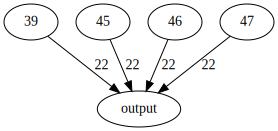

saved checkpoint to checkpoint 0.pkl
patching 3823 edges, keeping 4 edges, 106 remain
patching 3823 edges, keeping 4 edges, 106 remain
baseline score 0.8100000023841858
[3] sized edge sets remaining
got scores tensor([0.7600], device='cuda:0')
splitting 3 edges into two edge sets, as they have score 0.7599999904632568 which has diff 0.050000011920928955 > 0.0001
patching 3823 edges, keeping 4 edges, 106 remain
baseline score 0.8100000023841858
[1, 2] sized edge sets remaining
got scores tensor([0.7700, 0.8200], device='cuda:0')
keeping edge 39 -> 47 (blocks.39.hook_out_proj -> blocks.47.hook_layer_input(position: 22)) with score 0.7700000405311584 which has diff 0.039999961853027344 > 0.0001
patching 2 edges
finished these edge sets
valid score tensor([0.8500], device='cuda:0')


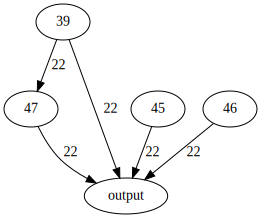

saved checkpoint to checkpoint 1.pkl
patching 3825 edges, keeping 5 edges, 103 remain
patching 3825 edges, keeping 5 edges, 103 remain
baseline score 0.8199999928474426
[3] sized edge sets remaining
got scores tensor([0.7933], device='cuda:0')
splitting 3 edges into two edge sets, as they have score 0.7933333516120911 which has diff 0.026666641235351562 > 0.0001
patching 3825 edges, keeping 5 edges, 103 remain
baseline score 0.8199999928474426
[1, 2] sized edge sets remaining
got scores tensor([0.8200, 0.7933], device='cuda:0')
splitting 2 edges into two edge sets, as they have score 0.7933333516120911 which has diff 0.026666641235351562 > 0.0001
patching 1 edges
patching 3826 edges, keeping 5 edges, 102 remain
baseline score 0.8199999928474426
[1, 1] sized edge sets remaining
got scores tensor([0.7867, 0.8133], device='cuda:0')
keeping edge 39 -> 46 (blocks.39.hook_out_proj -> blocks.46.hook_layer_input(position: 22)) with score 0.7866666913032532 which has diff 0.03333330154418945 > 

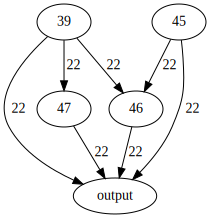

saved checkpoint to checkpoint 2.pkl
patching 3826 edges, keeping 7 edges, 100 remain
patching 3826 edges, keeping 7 edges, 100 remain
baseline score 0.8199999928474426
[4] sized edge sets remaining
got scores tensor([0.8100], device='cuda:0')
splitting 4 edges into two edge sets, as they have score 0.8100000023841858 which has diff 0.009999990463256836 > 0.0001
patching 3826 edges, keeping 7 edges, 100 remain
baseline score 0.8199999928474426
[2, 2] sized edge sets remaining
got scores tensor([0.8167, 0.8100], device='cuda:0')
splitting 2 edges into two edge sets, as they have score 0.8166666626930237 which has diff 0.0033333301544189453 > 0.0001
splitting 2 edges into two edge sets, as they have score 0.8100000023841858 which has diff 0.009999990463256836 > 0.0001
patching 3826 edges, keeping 7 edges, 100 remain
baseline score 0.8199999928474426
[1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8200, 0.8200, 0.8133, 0.8133], device='cuda:0')
keeping edge 39 -> 45 (blocks.39

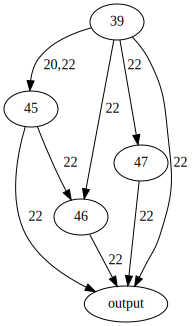

saved checkpoint to checkpoint 3.pkl
patching 3828 edges, keeping 9 edges, 96 remain
patching 3828 edges, keeping 9 edges, 96 remain
baseline score 0.8166666626930237
[41] sized edge sets remaining
got scores tensor([0.0467], device='cuda:0')
splitting 41 edges into two edge sets, as they have score 0.046666666865348816 which has diff 0.7699999809265137 > 0.0001
patching 3828 edges, keeping 9 edges, 96 remain
baseline score 0.8166666626930237
[20, 21] sized edge sets remaining
got scores tensor([0.0967, 0.5667], device='cuda:0')
splitting 20 edges into two edge sets, as they have score 0.09666667133569717 which has diff 0.7199999690055847 > 0.0001
splitting 21 edges into two edge sets, as they have score 0.5666666626930237 which has diff 0.25 > 0.0001
patching 3828 edges, keeping 9 edges, 96 remain
baseline score 0.8166666626930237
[10, 10, 10, 11] sized edge sets remaining
got scores tensor([0.1100, 0.8033, 0.7600, 0.6633], device='cuda:0')
splitting 10 edges into two edge sets, as th

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([0.5600, 0.3933, 0.8167, 0.8033, 0.8167, 0.8167, 0.8167, 0.8167, 0.8167,
        0.8033, 0.8133, 0.8100, 0.7533, 0.7333], device='cuda:0')
splitting 2 edges into two edge sets, as they have score 0.5600000023841858 which has diff 0.25999999046325684 > 0.0001
splitting 3 edges into two edge sets, as they have score 0.3933333456516266 which has diff 0.42666664719581604 > 0.0001
splitting 2 edges into two edge sets, as they have score 0.8166666626930237 which has diff 0.0033333301544189453 > 0.0001
splitting 3 edges into two edge sets, as they have score 0.8033333420753479 which has diff 0.016666650772094727 > 0.0001
splitting 2 edges into two edge sets, as they have score 0.8166666626930237 which has diff 0.0033333301544189453 > 0.0001
splitting 3 edges into two edge sets, as they have score 0.8166666626930237 which has diff 0.0033333301544189453 > 0.0001
splitting 2 edges into two edge sets, as they have score 0.8166666626930237 which has diff 0.0033333301544189453 > 0

  0%|          | 0/7 [00:00<?, ?it/s]

got scores tensor([0.6967, 0.6833, 0.6600, 0.5533, 0.8200, 0.8167, 0.8133, 0.8100, 0.8167,
        0.8200, 0.8133, 0.8233, 0.8167, 0.8200, 0.8200, 0.8167, 0.8167, 0.8200,
        0.8167, 0.8067, 0.8133, 0.8200, 0.8133, 0.8233, 0.8167, 0.7600, 0.7767,
        0.7767], device='cuda:0')
keeping edge 0 -> 39 (blocks.0.hook_out_proj -> blocks.39.hook_layer_input(position: 4)) with score 0.6966666579246521 which has diff 0.12333333492279053 > 0.0001
keeping edge 0 -> 39 (blocks.0.hook_out_proj -> blocks.39.hook_layer_input(position: 6)) with score 0.6833333373069763 which has diff 0.1366666555404663 > 0.0001
keeping edge 0 -> 39 (blocks.0.hook_out_proj -> blocks.39.hook_layer_input(position: 9)) with score 0.6600000262260437 which has diff 0.15999996662139893 > 0.0001
splitting 2 edges into two edge sets, as they have score 0.5533333420753479 which has diff 0.2666666507720947 > 0.0001
keeping edge 7 -> 39 (blocks.7.hook_out_proj -> blocks.39.hook_layer_input(position: 9)) with score 0.816666

  0%|          | 0/5 [00:00<?, ?it/s]

got scores tensor([0.6700, 0.7033, 0.8233, 0.8100, 0.8167, 0.8233, 0.8167, 0.8100, 0.7867,
        0.7800, 0.7933, 0.8067, 0.8167, 0.8233, 0.8200, 0.8233, 0.8167],
       device='cuda:0')
keeping edge 0 -> 39 (blocks.0.hook_out_proj -> blocks.39.hook_layer_input(position: 16)) with score 0.6700000166893005 which has diff 0.1533333659172058 > 0.0001
keeping edge 0 -> 39 (blocks.0.hook_out_proj -> blocks.39.hook_layer_input(position: 18)) with score 0.7033333778381348 which has diff 0.12000000476837158 > 0.0001
keeping edge 16 -> 39 (blocks.16.hook_out_proj -> blocks.39.hook_layer_input(position: 6)) with score 0.8100000023841858 which has diff 0.013333380222320557 > 0.0001
keeping edge 18 -> 39 (blocks.18.hook_out_proj -> blocks.39.hook_layer_input(position: 6)) with score 0.8166666626930237 which has diff 0.006666719913482666 > 0.0001
keeping edge 19 -> 39 (blocks.19.hook_out_proj -> blocks.39.hook_layer_input(position: 9)) with score 0.8166666626930237 which has diff 0.006666719913482

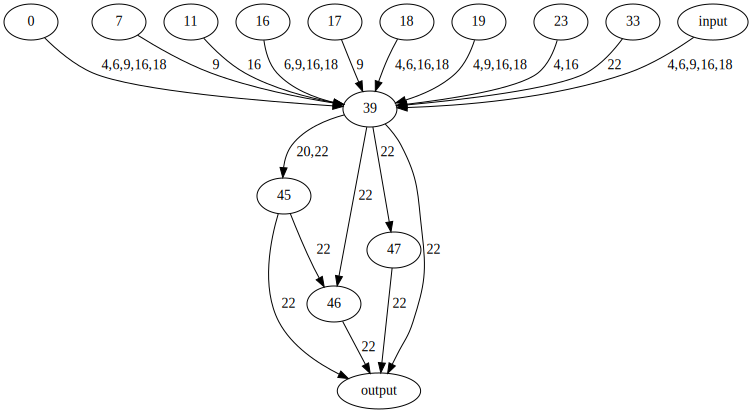

saved checkpoint to checkpoint 4.pkl
patching 3841 edges, keeping 37 edges, 55 remain
patching 3841 edges, keeping 37 edges, 55 remain
baseline score 0.8233333826065063
[17] sized edge sets remaining
got scores tensor([0.7967], device='cuda:0')
splitting 17 edges into two edge sets, as they have score 0.79666668176651 which has diff 0.026666700839996338 > 0.0001
patching 3841 edges, keeping 37 edges, 55 remain
baseline score 0.8233333826065063
[8, 9] sized edge sets remaining
got scores tensor([0.8033, 0.8167], device='cuda:0')
splitting 8 edges into two edge sets, as they have score 0.8033333420753479 which has diff 0.020000040531158447 > 0.0001
splitting 9 edges into two edge sets, as they have score 0.8166666626930237 which has diff 0.006666719913482666 > 0.0001
patching 3841 edges, keeping 37 edges, 55 remain
baseline score 0.8233333826065063
[4, 4, 4, 5] sized edge sets remaining
got scores tensor([0.8033, 0.8133, 0.8233, 0.8167], device='cuda:0')
splitting 4 edges into two edge s

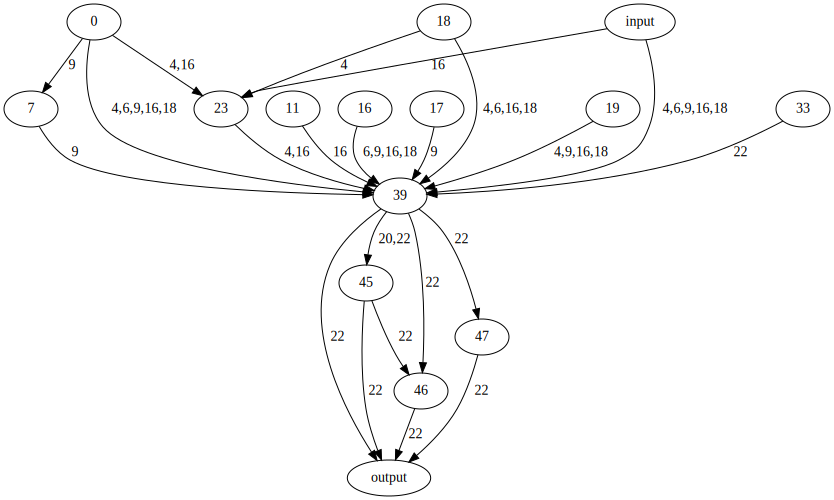

saved checkpoint to checkpoint 5.pkl
patching 3853 edges, keeping 42 edges, 38 remain
patching 3853 edges, keeping 42 edges, 38 remain
baseline score 0.8233333826065063
[10] sized edge sets remaining
got scores tensor([0.7700], device='cuda:0')
splitting 10 edges into two edge sets, as they have score 0.7700000405311584 which has diff 0.0533333420753479 > 0.0001
patching 3853 edges, keeping 42 edges, 38 remain
baseline score 0.8233333826065063
[5, 5] sized edge sets remaining
got scores tensor([0.8067, 0.7800], device='cuda:0')
splitting 5 edges into two edge sets, as they have score 0.8066666722297668 which has diff 0.016666710376739502 > 0.0001
splitting 5 edges into two edge sets, as they have score 0.7800000309944153 which has diff 0.043333351612091064 > 0.0001
patching 3853 edges, keeping 42 edges, 38 remain
baseline score 0.8233333826065063
[2, 3, 2, 3] sized edge sets remaining
got scores tensor([0.8233, 0.8100, 0.7967, 0.8067], device='cuda:0')
splitting 3 edges into two edge s

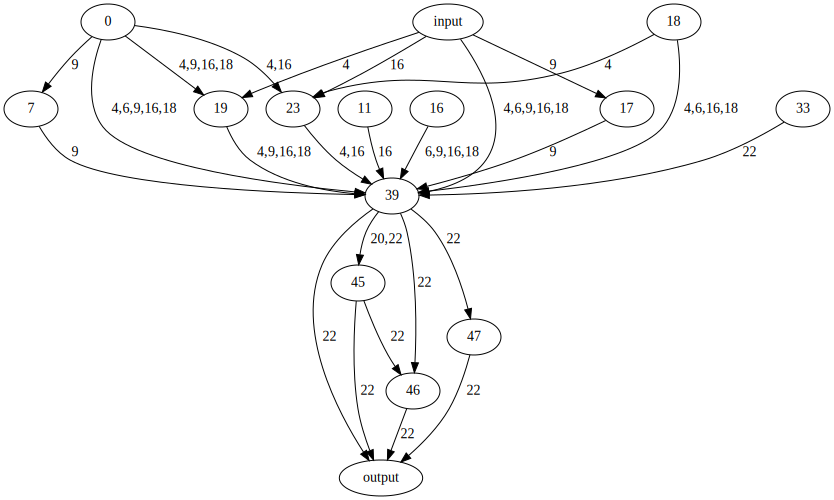

saved checkpoint to checkpoint 6.pkl
patching 3857 edges, keeping 48 edges, 28 remain
patching 3857 edges, keeping 48 edges, 28 remain
baseline score 0.8233333826065063
[18] sized edge sets remaining
got scores tensor([0.7667], device='cuda:0')
splitting 18 edges into two edge sets, as they have score 0.7666667103767395 which has diff 0.056666672229766846 > 0.0001
patching 3857 edges, keeping 48 edges, 28 remain
baseline score 0.8233333826065063
[9, 9] sized edge sets remaining
got scores tensor([0.7867, 0.7933], device='cuda:0')
splitting 9 edges into two edge sets, as they have score 0.7866666913032532 which has diff 0.036666691303253174 > 0.0001
splitting 9 edges into two edge sets, as they have score 0.7933333516120911 which has diff 0.030000030994415283 > 0.0001
patching 3857 edges, keeping 48 edges, 28 remain
baseline score 0.8233333826065063
[4, 5, 4, 5] sized edge sets remaining
got scores tensor([0.7800, 0.8100, 0.8033, 0.8100], device='cuda:0')
splitting 4 edges into two edge

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([0.8067, 0.8100, 0.8167, 0.8167, 0.8233, 0.8200, 0.8167, 0.8200, 0.8200,
        0.8167, 0.8233, 0.8133, 0.8200, 0.8233, 0.8233, 0.8133],
       device='cuda:0')
keeping edge 0 -> 16 (blocks.0.hook_out_proj -> blocks.16.hook_layer_input(position: 6)) with score 0.8066666722297668 which has diff 0.016666710376739502 > 0.0001
keeping edge 0 -> 16 (blocks.0.hook_out_proj -> blocks.16.hook_layer_input(position: 9)) with score 0.8100000023841858 which has diff 0.013333380222320557 > 0.0001
keeping edge 0 -> 16 (blocks.0.hook_out_proj -> blocks.16.hook_layer_input(position: 16)) with score 0.8166666626930237 which has diff 0.006666719913482666 > 0.0001
keeping edge 0 -> 16 (blocks.0.hook_out_proj -> blocks.16.hook_layer_input(position: 18)) with score 0.8166666626930237 which has diff 0.006666719913482666 > 0.0001
keeping edge input -> 16 (hook_embed -> blocks.16.hook_layer_input(position: 6)) with score 0.8199999928474426 which has diff 0.0033333897590637207 > 0.0001
keepi

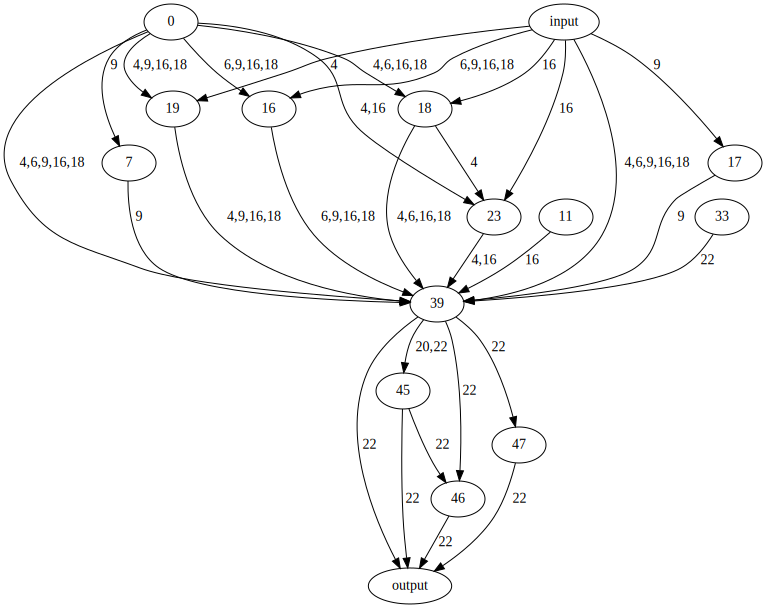

saved checkpoint to checkpoint 7.pkl
patching 3862 edges, keeping 61 edges, 10 remain
patching 3862 edges, keeping 61 edges, 10 remain
baseline score 0.8233333826065063
[5] sized edge sets remaining
got scores tensor([0.8100], device='cuda:0')
splitting 5 edges into two edge sets, as they have score 0.8100000023841858 which has diff 0.013333380222320557 > 0.0001
patching 3862 edges, keeping 61 edges, 10 remain
baseline score 0.8233333826065063
[2, 3] sized edge sets remaining
got scores tensor([0.8167, 0.8200], device='cuda:0')
splitting 2 edges into two edge sets, as they have score 0.8166666626930237 which has diff 0.006666719913482666 > 0.0001
splitting 3 edges into two edge sets, as they have score 0.8199999928474426 which has diff 0.0033333897590637207 > 0.0001
patching 3862 edges, keeping 61 edges, 10 remain
baseline score 0.8233333826065063
[1, 1, 1, 2] sized edge sets remaining
got scores tensor([0.8233, 0.8167, 0.8233, 0.8200], device='cuda:0')
keeping edge 0 -> 11 (blocks.0.h

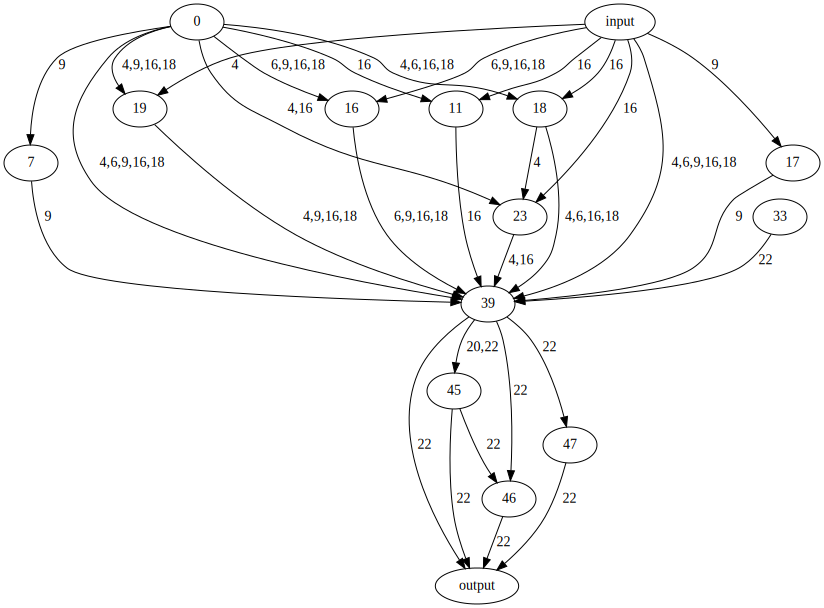

saved checkpoint to checkpoint 8.pkl
patching 3865 edges, keeping 63 edges, 5 remain
patching 3865 edges, keeping 63 edges, 5 remain
baseline score 0.8233333826065063
[5] sized edge sets remaining
got scores tensor([0.0833], device='cuda:0')
splitting 5 edges into two edge sets, as they have score 0.0833333358168602 which has diff 0.7400000691413879 > 0.0001
patching 3865 edges, keeping 63 edges, 5 remain
baseline score 0.8233333826065063
[2, 3] sized edge sets remaining
got scores tensor([0.5400, 0.3667], device='cuda:0')
splitting 2 edges into two edge sets, as they have score 0.5400000214576721 which has diff 0.28333336114883423 > 0.0001
splitting 3 edges into two edge sets, as they have score 0.36666667461395264 which has diff 0.4566667079925537 > 0.0001
patching 3865 edges, keeping 63 edges, 5 remain
baseline score 0.8233333826065063
[1, 1, 1, 2] sized edge sets remaining
got scores tensor([0.6800, 0.6833, 0.6633, 0.5267], device='cuda:0')
keeping edge input -> 0 (hook_embed -> bl

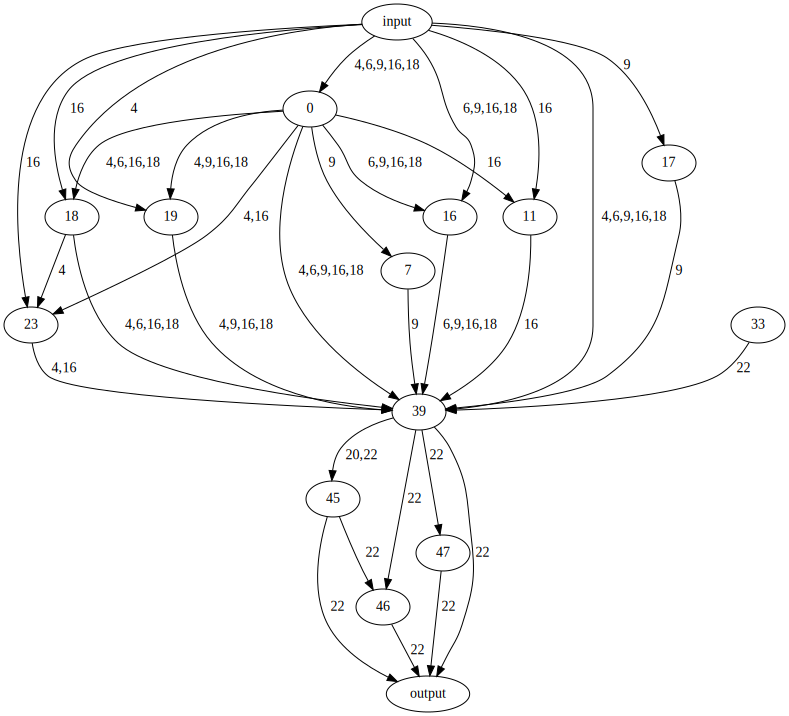

saved checkpoint to checkpoint 9.pkl
pruning node 33 because it doesn't have a path from input -> 33 -> output
final output:


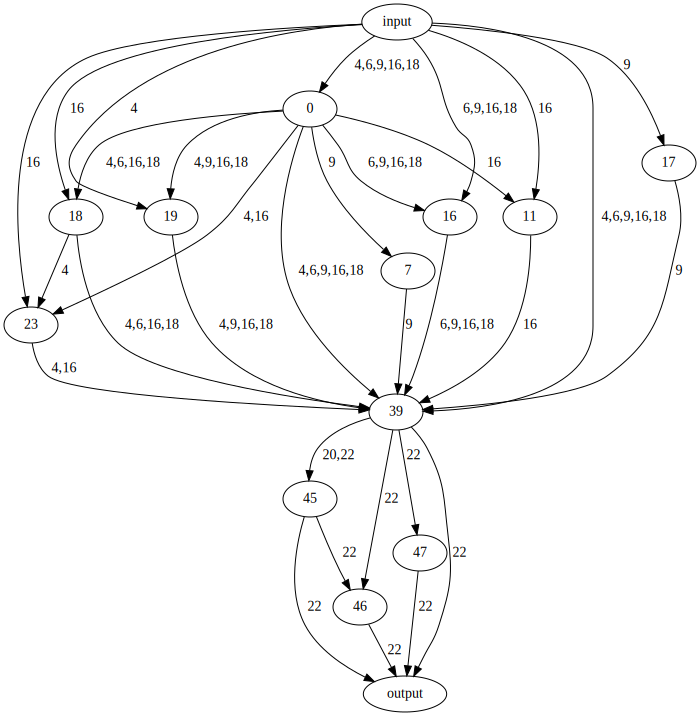

final accuracy 0.8233333826065063


In [54]:
import copy
# this is useful because sometimes if you spam ctrl-c too many times some hooks will stay around
model.remove_all_hook_fns()

# because every pair (i,i+1) is a patching (uncorrupted, corrupted),
# we want things to be symmetric,
# so we will double up our dataset
# by swapping each pair
def repeat_swapped_patch(vec):
    swapped_vecs = []
    for i in range(0, vec.size()[0], 2):
        swapped_vecs += [vec[i+1:i+2], vec[i:i+1]]
    return torch.cat([vec] + swapped_vecs, dim=0)

def eval_acdc(model, data, correct, incorrect, metric, num_edges, constrain_to_answers, **kwargs):
    num_examples = correct.size()[0]
    
    logits = model(data, **kwargs)[:,-1]

    # they come in pairs, uncorrupted, corrupted
    # we patch the first one in the pair, so only measure accuracy on that
    patched_logits = logits[::2]
    corrupted_logits = logits[1::2]
    patched_correct = correct[::2]
    patched_incorect = incorrect[::2]
    
    pad = get_pad_token(tokenizer=model.tokenizer)
    logits[:,pad] = -torch.inf # manually set pad pr to -inf logit because sometimes we need to pad num correct or num incorrect
        
    n_data, n_correct = patched_correct.size()
    n_data, n_incorrect = patched_incorect.size()
    
    # [n_data, n_correct]
    correct_logits = index_into(patched_logits, patched_correct)
    # [n_data, n_incorrect]
    incorrect_logits = index_into(patched_logits, patched_incorect)
    
    if constrain_to_answers:
        # [n_data, n_correct + n_incorrect]
        combined_logits = torch.concatenate([correct_logits, incorrect_logits], dim=1)
        combined_prs = torch.softmax(combined_logits, dim=1)
        biggest = torch.argsort(-combined_prs, dim=1)
        # if biggest pr is in the correct, we are correct, otherwise, we are not
        has_correct = biggest[:,0] < n_correct

        correct_prs, incorrect_prs = combined_prs.split([n_correct, n_incorrect], dim=1)
    else:
        prs = torch.nn.functional.softmax(patched_logits, dim=1)
        # [n_data, n_correct]
        correct_prs = index_into(prs, patched_corect)
        # [n_data, n_incorrect]
        incorrect_prs = index_into(prs, patched_incorect)
        # [n_data, 1]
        top_tokens = torch.topk(patched_logits, 1, dim=1).indices
        # [n_data, n_correct]
        is_correct = top_tokens == patched_corect
        # [n_data]
        has_correct = torch.any(is_correct, dim=1)

    metric_results = torch.zeros([num_edges], device=device)
    batch_size = n_data//num_edges
    for i, batch_start in enumerate(range(0, n_data, batch_size)):
        batch_end = batch_start + batch_size
        metric_results[i] = metric(
            patched_logits=patched_logits[batch_start:batch_end],
            corrupted_logits=corrupted_logits[batch_start:batch_end],
            correct_logits=correct_logits[batch_start:batch_end],
            incorrect_logits=incorrect_logits[batch_start:batch_end],
            correct_prs=correct_prs[batch_start:batch_end],
            incorrect_prs=incorrect_prs[batch_start:batch_end],
            top_is_correct=has_correct[batch_start:batch_end],
        )
    return metric_results

def accuracy_metric(
    patched_logits,
    corrupted_logits,
    correct_logits,
    incorrect_logits,
    correct_prs,
    incorrect_prs,
    top_is_correct):
    return torch.sum(top_is_correct)/top_is_correct.size()[0]

# we want the subnetwork that "uses" the information we patch away
# thus we start with the last layer
#   find the positions that, when we patch there, normalized logit diff is above a threshold
#     we could either:
#       run every one seperately and pick those that are past a thresh
#         misses redundant circuits that only show up when you run both
#       test every pair of positions, and pick those that are past a thresh
#         expensive and probably over-fires:
#            if A is uses, then all A->B will also fire
#                this can be addressed by seeing if B increases it at all?
#                But if they are both dependencies then removing either should just kill the circuit
#       realistically, there are no i,j dependencies within a specific layer (probably?) so it's safe to start
#         with just grabbing everything past a thresh
#    okay so that gives us one layer
#      now we want to add more nodes to our graph
#      maybe a good start is just getting all the nodes, we can worry about connections later


# there's the edge trick
# where if we have A->C->E (and also some indirect path A->B->C, and some other A->D->E)
# then we want to ablate away the A->C edge
# we do this by running everything like we would with no patching,
# except that C receives inputs from A as if it was patched
# (however, B still receives inputs from A as if it was not patched, this is "trying to piece out the direct connection without other variable B")

# that's the idea, how do we implement it?
# each term adds stuff to the residual stream
# call 
# a_uncorrupted = output of A (no patching) to the residual stream
# a_corrupted = output of A (with patching) to the residual stream
# and call
# c_input = residual stream input to C (with no patching)
# we can just do
# c_input = c_input - a_uncorrupted + a_corrupted
# because everything adds to the residual stream this just makes sense

# simple version:
# 1. Find the layers that, when we patch, light up
# 2. For each layer from 1, find the components that, when we patch, light up
# 3. For each component from 2, find the positions that, when we patch, light up
#            but different patchings have different positions?
#              probably we want steps 1 and 2 to run over all patchings, but step 3 to output per each patching
#                    might also just be useful to run this seperately for each patching tbh
# 
# more complex version:
# 1. Start with last layer:
#        for each edge (other layer -> last layer), try patching
#            build a graph with that

# edge subnetwork probing better than edge acdc also see Attribution Patching Outperforms Automated Circuit Discovery (EAC)

THRESH = 0.0001
ROLLBACK_THRESH = 0.004
debug = False
BATCH_SIZE = 4 # how many multiples of the dataset to process at the same time
DO_ATTRIBUTION_PATCHING = False # if True, will run much faster at the cost of being less accurate (attribution patching does a linear approximation)
#limited_layers = [0, 8, 9, 11, 12, 14, 15, 18, 20, 21, 24, 25, 26, 27, 28, 33, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
#limited_layers = [0, 7, 10, 11, 16, 17, 18, 19, 23, 24, 25, 28, 30, 31, 33, 39, 44, 45, 46, 47]
limited_layers = [0, 7, 10, 11, 16, 17, 18, 19, 23, 24, 25, 28, 33, 39, 45, 46, 47]
#limited_layers = list(range(model.cfg.n_layers))
model_kwargs = {
    'fast_ssm': True,
    'fast_conv': True,
    'only_use_these_layers': limited_layers,
}
pbatched_data = repeat_swapped_patch(batched_data)
pbatched_correct = repeat_swapped_patch(batched_correct)
pbatched_incorrect = repeat_swapped_patch(batched_incorrect)
vpbatched_data = repeat_swapped_patch(vbatched_data)
vpbatched_correct = repeat_swapped_patch(vbatched_correct)
vpbatched_incorrect = repeat_swapped_patch(vbatched_incorrect)
data_size = pbatched_data.size()[0]
B, L = pbatched_data.size()

# there are edges from:
# hook_embed -> every layer hook_layer_input
# every layer hook_out_proj -> every (later) layer hook_layer_input
# hook_embed and every layer hook_out_proj -> resid_post of final layer

# maybe it is less principled, but i think it could prune less edges if it pruned in a different order
# right now it prunes until it hits thresh and then straddles it, and random variations leave the rest to either be thrown out or not



edge_hook_names = []
last_layer = max(limited_layers)



if type(model) is HookedMamba:
    INPUT_HOOK = f'hook_embed'
    OUTPUT_HOOK = f'blocks.{last_layer}.hook_resid_post'
    
    INPUT_NODE = 'input'
    OUTPUT_NODE = 'output'
    
    positions = list(range(L))
    # you can use this if you don't want positional nodes
    #positions = [None]
    
    ## Setup edges for ACDC

    
    for l in positions:
        edge_hook_names.append((
                {"hook": INPUT_HOOK},
                {"hook": OUTPUT_HOOK, "position": l},
        ))
    
    for i in limited_layers:
        for l in positions:
            edge_hook_names.append((
                    {"hook": INPUT_HOOK},
                    {"hook": f"blocks.{i}.hook_layer_input", "position": l},
            ))
            for j in limited_layers:
                    if i < j:
                        edge_hook_names.append((
                            {"hook": f"blocks.{i}.hook_out_proj"},
                            {"hook": f"blocks.{j}.hook_layer_input", "position": l},
                        ))
            # the resid post on the last layer is simply the output resid of the entire model
            edge_hook_names.append((
                    {"hook": f"blocks.{i}.hook_out_proj"},
                    {"hook": OUTPUT_HOOK, "position": l},
            ))
    
    ## Setup nodes for ACDC
    nodes = {}
    nodes[INPUT_NODE] = [INPUT_HOOK]
    for i in limited_layers:
        nodes[str(i)] = [f"blocks.{i}.hook_layer_input", f"blocks.{i}.hook_out_proj"]
    nodes[OUTPUT_NODE] = [OUTPUT_HOOK]
elif type(model) is HookedTransformer:
    
    INPUT_HOOK = f'hook_embed'
    OUTPUT_HOOK = f'blocks.{last_layer}.hook_resid_post'
    
    INPUT_NODE = 'embed'
    OUTPUT_NODE = 'output'

    # we have a node for:
    # [embed]
    # [layer] x [q,k,v] x [head]
    # [layer output]
    # [final hook_resid_post]

    # and edges from
    # [embed] -> [layer] x [q,k,v] x [head]
    # [embed] -> [final hook_resid_post]
    # [head attn output] -> 
    # [layer output] -> [layer] x [q,k,v] x [head]
    # [layer output] -> [final hook_resid_post]
    # there's also an implicit edge (doesn't do patching, just represents info transfer) between
    '''
    for head in range(model.cfg.n_heads):
        for i in limited_layers:
            for output_hook in ['hook_q_input', 'hook_k_input', 'hook_v_input']:
                edge_hook_names.append((
                        {"hook": INPUT_HOOK},
                        {"hook": f"blocks.{i}.{output_hook}", "head": head},
                        edge_output_patching_hook
                ))
                for j in limited_layers:
                    if i < j:
                        edge_hook_names.append((
                            {"hook": f"blocks.{i}.hook_mlp_out"},
                            {"hook": f"blocks.{j}.{output_hook}", "head": head},
                            edge_output_patching_hook
                        ))
                # the resid post on the last layer is simply the output resid of the entire model
                edge_hook_names.append((
                        {"hook": f"blocks.{i}.hook_mlp_out"},
                        {"hook": OUTPUT_HOOK, "head": head},
                ))
    ## Setup nodes for ACDC
    nodes = {}
    nodes[INPUT_NODE] = [INPUT_HOOK]
    for i in limited_layers:
        for output_hook in ['q', 'k', 'v']:
            for head in range(model.cfg.n_heads):
            nodes[f'{i}.{output_hook}.{head}'] = [
                {"hook": f"blocks.{i}.hook_{output_hook}_input",
                 "head": head},
                {"hook": f"blocks.{i}.hook_mlp_out"]
    nodes[OUTPUT_NODE] = [OUTPUT_HOOK]
    '''
    
global storage
storage = {}
def edge_input_storage_hook(
    x,
    hook: HookPoint,
):
    global storage
    storage[hook.name] = x
    return x

global grad_storage
grad_storage = {}
def edge_input_grad_storage_hook(
    x,
    hook: HookPoint,
):
    global grad_storage
    grad_storage[hook.name] = x
    # for some reason bwd hooks don't like it when you return values, so we don't


# if we want to do attribution patching
# goal is to predict the metric given any patch
#                                                [B,L]   [B,L,D]  edge 
# we can see (patched) metric as some function M(input,   diff , (i,j) )
# where input is clean input passed into the model (fixed for all patchings), and
# diff is the patch value applied at the given edge
# (for example, for edge (i,j),
#          [B,L,D]           [B,L,D]         [B,L,D]               [B,L,D]
#       layer_j_inputs = layer_j_inputs - layer_i_outputs + corrupted_layer_i_outputs
# )
# in this case, diff = -layer_i_outputs + corrupted_layer_i_outputs
# we want to do a taylor approximation of M in terms of the diff parameter, at some position diff_0
# this is
# -------------[B]--------------        -------------[B]-------------    ------[B,L,D]-----   -------------[B,L,D]----------------
#     [B,L,V]   [B,L,D]  edge               [B,L,V]   [B,L,D]  edge       [B,L,D]   [B,L,D]                      [B,L,V]   [B,L,D]
# M(   input  ,  diff , (i,j)  ) approx M(  input  ,  diff_0, (i,j) ) + (  diff  -  diff_0) @ layer_inputs.grad(  input,   diff_0 )
# where
# layer_inputs.grad(...) means the gradient of the activation we are patching (with respect to the metric value)
# As specified the dimensions don't actually line up for the @ at the end, I think we're supposed to do
# [B,L,D] @ [B,L,D]
# is actually
# [B,1,L*D] @ [B,L*D,1]
# which gives
# [B,1,1] as an output which can be flattened to
# [B]
# another way to write that is
# --------------------[B]-----------------
# ---------------[B,L]----------
# -----[B,L,D]-------
# ([B,L,D] * [B,L,D]).sum(dim=2).sum(dim=1)
# (element wise product, the sum along the two dimensions)
# but now that we have those individual terms, this actually gives us some interpretation for how much each element of the
# [B,L,D]
# sized matrix contributes to our metric!                              
# one final detail, we will pick
# [B,L,D]  [B,L,D]
# diff_0 = 0 vector
# this means that, where before we have
# (for edge (i,j),
#       diff = -layer_i_outputs + corrupted_layer_i_outputs
# 
#       so
#     
#          [B,L,D]           [B,L,D]     [B,L,D]
#       layer_j_inputs = layer_j_inputs + diff
#       
#       i.e.
#
#          [B,L,D]           [B,L,D]            [B,L,D]                [B,L,D]
#       layer_j_inputs = layer_j_inputs + - layer_i_outputs + corrupted_layer_i_outputs
#  
# )
# if we set diff = 0 vector, this gives us
#     
# (for edge (i,j),
#         [B,L,D]           [B,L,D]     [B,L,D]
#       layer_j_inputs = layer_j_inputs + 0
# )
# 
# this is simply running a forward pass with no patching!
# in practice, because we are continuing to add more and more edges to the pile of stuff being patched,
# instead of doing no patching, we will do "baseline" patching
# okay so consider this again:
# M(  input  ,  diff_0, (i,j) ) + (  diff  -  diff_0) @ layer_inputs.grad(  input,   diff_0 )
# all these three are fixed and we only need to compute them once:
# M(  input  ,  diff_0, (i,j) )
# diff_0
# layer_inputs.grad(  input,   diff_0 )
# now consider
# diff
# in regular patching, diff = -layer_i_outputs + corrupted_layer_i_outputs
# -layer_i_outputs is fixed and we only need to compute it once
# corrupted_layer_i_outputs also only requires a single forward pass


def edge_output_patching_hook(
    x,
    hook: HookPoint,
    input_hook: str,
    batch_start: int,
    batch_end: int,
    position: int = None,
):
    global storage
    x_uncorrupted = storage[input_hook][batch_start:batch_end:2]
    x_corrupted = storage[input_hook][batch_start+1:batch_end+1:2]
    if position is None: # if position not specified, apply to all positions
        x[batch_start:batch_end:2] = x[batch_start:batch_end:2] - x_uncorrupted + x_corrupted
    else:
        x[batch_start:batch_end:2,position] = x[batch_start:batch_end:2,position] - x_uncorrupted[:,position] + x_corrupted[:,position]
    return x

@dataclass
class Edge:
    input_hook: str
    output_hook: str
    input_node: str
    output_node: str
    input_hook_params: Dict = field(default_factory=lambda: {})
    output_hook_params: Dict = field(default_factory=lambda: {})
    patching: bool = False
    checked: bool = False
    score_when_patched: Float = False

    def extract_params(self, hook):
        hook_name = hook['hook']
        del hook['hook']
        hook_params = hook
        return hook_name, hook_params
    
    def label(self):
        label = []
        for k,v in sorted(list(self.input_hook_params.items())) + sorted(list(self.output_hook_params.items())):
            if not v is None:
                label.append(str(v))
        return ",".join(label)
    
    def __post_init__(self):
        # this allows for hooks to be dicts or strings
        self.input_hook, self.input_hook_params = self.extract_params(self.input_hook)
        self.output_hook, self.output_hook_params = self.extract_params(self.output_hook)

    def get_attribution_patching_hooks(self):
        fwd_input_storage_hook = (self.input_hook, partial(edge_input_storage_hook, **self.input_hook_params))
        bwd_input_storage_hook = (self.input_hook, partial(edge_input_grad_storage_hook, **self.input_hook_params))
        return [fwd_input_storage_hook], [bwd_input_storage_hook]
    
    def get_hooks(self, batch_start, batch_end):
        input_storage_hook = (self.input_hook, partial(edge_input_storage_hook, **self.input_hook_params))
        output_patching_hook = (self.output_hook, partial(edge_output_patching_hook,
                                                          input_hook=self.input_hook,
                                                          batch_start=batch_start,
                                                          batch_end=batch_end,
                                                         **self.output_hook_params))
        return [input_storage_hook, output_patching_hook]

    def __str__(self):
        input_params_str = ", ".join([f'{k}: {v}' for (k,v) in sorted(list(self.input_hook_params.items()))])
        output_params_str = ", ".join([f'{k}: {v}' for (k,v) in sorted(list(self.output_hook_params.items()))])
        if input_params_str != "": input_params_str = f"({input_params_str})"
        if output_params_str != "": output_params_str = f"({output_params_str})"
        
        return f"{self.input_node} -> {self.output_node} ({self.input_hook}{input_params_str} -> {self.output_hook}{output_params_str})"

@dataclass
class Node:
    name: str
    incoming_edges: List[Edge] = field(default_factory=lambda: [])
    outgoing_edges: List[Edge] = field(default_factory=lambda: [])

# make a lookup from hook to node name 
hook_to_node_name = {}
for node_name, node_hooks in nodes.items():
    for hook in node_hooks:
        hook_to_node_name[hook] = node_name
for input_hook, output_hook in edge_hook_names:
    if not input_hook['hook'] in hook_to_node_name:
        raise ValueError(f"hook {input_hook} does not have a corresponding node")
    if not output_hook['hook'] in hook_to_node_name:
        raise ValueError(f"hook {output_hook} does not have a corresponding node")

# make all the edges

all_node_names = set()
edges = []
for (input_hook, output_hook) in edge_hook_names:
    input_node, output_node = hook_to_node_name[input_hook['hook']], hook_to_node_name[output_hook['hook']]
    edges.append(Edge(input_hook=input_hook, output_hook=output_hook, input_node=input_node, output_node=output_node))
    all_node_names.add(input_node)
    all_node_names.add(output_node)

# construct the graph
all_nodes = dict([(name, Node(name=name)) for name in sorted(list(all_node_names))])
for edge in edges:
    all_nodes[edge.input_node].outgoing_edges.append(edge)
    all_nodes[edge.output_node].incoming_edges.append(edge)



# returns edges that should be considered next for pruning by acdc
def get_edges_to_check(nodes):
    for node_name, node in sorted(list(all_nodes.items())):
        # if we have checked all our outgoing edges (or we have none), we are safe to expand incoming edges
        all_outgoing_checked = all([outgoing_edge.checked for outgoing_edge in node.outgoing_edges])
        if all_outgoing_checked:
            for edge in node.incoming_edges:
                if not edge.checked:
                    yield edge



# restore from edge based run
'''
with open("backup_items_edge.pkl", "rb") as f:
    [backup_edges, backup_nodes] = cloudpickle.load(f)
    for edge in backup_edges:
        current_edges = []
        for other_edge in edges:
            if other_edge.input_hook == edge.input_hook and other_edge.output_hook == edge.output_hook:
                current_edges.append(other_edge)
        if len(current_edges) == 0:
            print("could not find edge", edge)
        else:
            # carry over anything that is patching
            if edge.patching:
                for other_edge in current_edges:
                    other_edge.patching = True
                    other_edge.checked = True
'''
# restore from checkpoint
'''
with open("output_edge_positions_final_v2.pkl", "rb") as f:
    [backup_edges, backup_nodes] = cloudpickle.load(f)
    edges, all_nodes = backup_edges, backup_nodes
    for edge in edges:
        edge.checked = edge.patching
'''
with open("output_edge_positions_final_v4.pkl", "rb") as f:
    [backup_edges, backup_nodes] = cloudpickle.load(f)
    for edge in backup_edges:
        current_edge = None
        for other_edge in edges:
            if other_edge.input_hook == edge.input_hook and other_edge.output_hook == edge.output_hook and other_edge.input_hook_params == edge.input_hook_params and other_edge.output_hook_params == edge.output_hook_params:
                current_edge = other_edge
                break
        if current_edge is None:
            print("could not find edge", edge)
        else:                
            # carry over anything that is patching
            if edge.patching:
                current_edge.patching = True
                current_edge.checked = True

'''
with open("backup_items_mamba_edge.pkl", "rb") as f:
    [backup_edges, backup_nodes] = cloudpickle.load(f)
    for edge in backup_edges:
        current_edge = None
        for other_edge in edges:
            if other_edge.input_hook == edge.input_hook and other_edge.output_hook == edge.output_hook and other_edge.input_hook_params == edge.input_hook_params and other_edge.output_hook_params == edge.output_hook_params:
                current_edge = other_edge
                break
        if current_edge is None:
            print("could not find edge", edge)
        else:                
            # carry over anything that is patching
            if edge.patching:
                current_edge.patching = True
                current_edge.checked = True
'''

def get_nx_graph(edges):
    import networkx as nx
    G = nx.DiGraph()
    labeldict = defaultdict(lambda: set())
    for edge in edges:
        if edge.checked and not edge.patching:
            G.add_edge(edge.input_node, edge.output_node, label=edge.label())
    return G

def draw_nx_graph(nodes, edges):
    import matplotlib.pyplot as plt
    G = get_nx_graph(edges=edges)
    nx.draw_networkx(G, with_labels=True, font_size=8)
    plt.show()

# [0,1,2,4,5,6,8] -> "0-2,4-6,8"
def condense_positions(positions):
    is_visited = [False for _ in range(L)]
    for p in positions:
        is_visited[p] = True

    ranges = []
    earliest = min(positions)
    start_pos = earliest
    started_range = True
    for pos in range(earliest+1, L):
        if not is_visited[pos] and started_range:
            ranges.append((start_pos, pos-1))
            started_range = False
        elif is_visited[pos] and not started_range:
            start_pos = pos
            started_range = True
    if started_range:
        ranges.append((start_pos, L-1))
    out_strs = []
    for (start_pos, end_pos) in ranges:
        if start_pos == end_pos:
            out_strs.append(str(start_pos))
        else:
            out_strs.append(str(start_pos) + "-" + str(end_pos))
    out_str = ",".join(out_strs)
    return out_str

def get_graphviz_graph(edges):
    import graphviz
    dot = graphviz.Digraph('result')
    node_connections = defaultdict(lambda: [])
    for edge in edges:
        if edge.checked and not edge.patching:
            if len(edge.label()) > 0:
                node_connections[(edge.input_node, edge.output_node)].append(int(edge.label()))
            else:
                dot.edge(edge.input_node, edge.output_node)
                
    for (input_node, output_node), positions in node_connections.items():
        positions = sorted(list(positions))
        dot.edge(input_node, output_node, label=condense_positions(positions))
    return dot

def draw_graphviz_graph(edges):
    from IPython.display import display
    display(get_graphviz_graph(edges=edges))


def get_currently_patched_edge_hooks(edges):
    currently_patched_edge_hooks = []
    for edge in edges:
        if edge.patching:
            currently_patched_edge_hooks += edge.get_hooks(batch_start=0, batch_end=len(edges_to_check)*data_size) # if it's too big it'll just grab everything which is what we want
    return currently_patched_edge_hooks

def get_baseline_score(edges):
    currently_patched_edge_hooks = get_currently_patched_edge_hooks(edges)
    return eval_acdc(
        model=wrap_run_with_hooks(model=model, fwd_hooks=currently_patched_edge_hooks, **model_kwargs),
        data=pbatched_data,
        correct=pbatched_correct,
        incorrect=pbatched_incorrect,
        metric=accuracy_metric,
        num_edges=1,
        constrain_to_answers=constrain_to_answers)[0].item()
         

uncorrupted_inputs = pbatched_data[::2]
uncorrupted_correct = pbatched_correct[::2]
uncorrupted_incorrect = pbatched_incorrect[::2]

corrupted_inputs = pbatched_data[1::2]
corrupted_correct = pbatched_correct[1::2]
corrupted_incorrect = pbatched_incorrect[1::2]

iters = 0
while len(list(get_edges_to_check(nodes=all_nodes))) > 0:

    # get edges that are next to check (because they don't have any edges after them that haven't been checked)
    edges_to_check = list(get_edges_to_check(nodes=all_nodes))

    def print_stats(edges):
        # get hooks for currently patched edges
        num_patching, num_keeping = 0, 0
        for edge in edges:
            if edge.patching:
                num_patching += 1
            elif edge.checked:
                num_keeping += 1
        print(f"patching {num_patching} edges, keeping {num_keeping} edges, {len(edges)-num_patching-num_keeping} remain")

    print_stats(edges)
    out_scores = torch.zeros([len(edges_to_check)], device=model.cfg.device)
    # a less precise but much faster version
    # todo: attribution patching, then "double check" any kept edges using regular stuff?
    if DO_ATTRIBUTION_PATCHING:

        
        caching_fwd_hooks, caching_bwd_hooks = [], []

        # baseline, all the existing edges we are patching
        for edge in edges:
            if edge.patching:
                caching_fwd_hooks += edge.get_hooks(batch_start=0, batch_end=len(edges_to_check)*data_size) # if it's too big it'll just grab everything which is what we want
        
        # run a forward pass (every other element in our data is the corrupted data, so this also does a forward pass for corrupted)
        torch.set_grad_enabled(False)
        # get baseline metric
        baseline_acc = eval_acdc(
            model=wrap_run_with_hooks(model=model, fwd_hooks=caching_fwd_hooks, **model_kwargs),
            data=pbatched_data,
            correct=pbatched_correct,
            incorrect=pbatched_incorrect,
            metric=accuracy_metric,
            num_edges=1,
            constrain_to_answers=constrain_to_answers)[0].item()

        print("accuracy", baseline_acc)
        #if len(caching_fwd_hooks) > 0: break
        # cache results for any edges we are checking
        for edge in edges_to_check:
            if not edge.patching:
                fwd, bwd = edge.get_attribution_patching_hooks()
                caching_fwd_hooks += fwd
                caching_bwd_hooks += bwd
        
        # cleanup stuff from past runs
        storage = {}
        grad_storage = {}
        corrupted_storage = {}
        # remove existing grads
        for name, param in model.named_parameters():
            param.grad = None
        torch.cuda.empty_cache()
        
        # we need to manually add hooks since bwd hooks are called outside run_with_hooks
        # add fwd hooks
        model.reset_hooks()
        for fwd_hook_name, fwd_hook in caching_fwd_hooks:
            model.add_hook(name=fwd_hook_name, hook=fwd_hook, dir="fwd")

        # only need the forward hooks for corrupted pass
        torch.set_grad_enabled(True)
        corrupted_logits = model(corrupted_inputs, **model_kwargs)[:,-1]
        corrupted_storage = storage
        storage = {} # reset storage for uncorrupted pass
        
        # now add the backward hooks for uncorrupted pass
        for bwd_hook_name, bwd_hook in caching_bwd_hooks:
            model.add_hook(name=bwd_hook_name, hook=bwd_hook, dir="bwd")

        # forward pass on uncorrupted
        uncorrupted_logits = model(uncorrupted_inputs, **model_kwargs)[:,-1]

        
        # compute metric
        def get_logit_diff(logits, correct, incorrect):
            n_data, n_correct   = correct.size()
            n_data, n_incorrect = incorrect.size()
            
            # [n_data, n_correct]
            correct_logits = index_into(logits, correct)
            # [n_data, n_incorrect]
            incorrect_logits = index_into(logits, incorrect)
            # [n_data, n_correct + n_incorrect]
            #combined_logits = torch.concatenate([correct_logits, incorrect_logits], dim=1)
            #correct_logits, incorrect_logits = combined_logits.split([n_correct, n_incorrect], dim=1)
            diff = correct_logits.sum(dim=1) - incorrect_logits.sum(dim=1)
            return diff


        def ioi_metric(logits, uncorrupted_baseline, corrupted_baseline, correct, incorrect):
            min_val = corrupted_baseline
            max_val = uncorrupted_baseline
            return (get_logit_diff(logits=logits, correct=correct, incorrect=incorrect)-min_val)/(max_val-min_val)

        def smooth_accuracy(logits, correct, incorrect):
            n_data, n_correct   = correct.size()
            n_data, n_incorrect = incorrect.size()
            # [n_data, n_correct]
            correct_logits = index_into(logits, correct)
            # [n_data, n_incorrect]
            incorrect_logits = index_into(logits, incorrect)
            combined_logits = torch.concatenate([correct_logits, incorrect_logits], dim=1)
            combined_prs = torch.softmax(combined_logits, dim=1)
            combined_prs_extreme = torch.softmax(combined_logits*10000, dim=1)
            correct_prs, incorrect_prs = combined_prs.split([n_correct, n_incorrect], dim=1)
            correct_prs_extreme, incorrect_prs_extreme = combined_prs_extreme.split([n_correct, n_incorrect], dim=1)
            # this will be from 0 to 1
            total_correct_pr = correct_prs_extreme.sum(dim=1)
            # we want something that has
            # stuff < 0.5 -> 0
            # stuff > 0.5 -> 1
            # this is just sigmoid if we shift so 0.5 is at zero
            smooth_acc = total_correct_pr
            # actually that's not right
            # consider correct=[0.4], incorrect=[0.2,0.2,0.2]
            # that scored correctly, while our metric would say its wrong
            # 
            
            biggest = torch.argsort(-correct_prs, dim=1)
            # if biggest pr is in the correct, we are correct, otherwise, we are not
            has_correct = biggest[:,0] < n_correct
            #print("smooth acc", smooth_acc)
            #print("correct", has_correct)
            return smooth_acc.sum()/n_data
        
        #uncorrupted_diff = get_logit_diff(uncorrupted_logits, correct=uncorrupted_correct, incorrect=uncorrupted_incorrect)
        #corrupted_diff = get_logit_diff(corrupted_logits, correct=uncorrupted_correct, incorrect=uncorrupted_incorrect)
        
        #uncorrupted_metric = ioi_metric(logits=uncorrupted_logits, uncorrupted_baseline=uncorrupted_diff, corrupted_baseline=corrupted_diff, correct=uncorrupted_correct, incorrect=uncorrupted_incorrect)
        #corrupted_metric = ioi_metric(logits=corrupted_logits, uncorrupted_baseline=uncorrupted_diff, corrupted_baseline=corrupted_diff, correct=uncorrupted_correct, incorrect=uncorrupted_incorrect)
        baseline_score = smooth_accuracy(logits=uncorrupted_logits, correct=uncorrupted_correct, incorrect=uncorrupted_incorrect)
        print(f"baseline acc {baseline_score}")
        '''this doesn't seem to carry signal very well back
        combined_prs = torch.softmax(combined_logits, dim=1)
        correct_prs, incorrect_prs = combined_prs.split([n_correct, n_incorrect], dim=1)
        
        baseline_score = correct_prs.sum(dim=1).mean()
        '''
        ''' sadly not differentiable
        biggest = torch.argmax(-combined_logits, dim=1)
        n_data, n_correct = uncorrupted_correct.size()
        # if biggest pr is in the correct, we are correct, otherwise, we are not
        has_correct = biggest[:] < n_correct
        baseline_score = has_correct.sum()/float(uncorrupted_logits.size()[0])
        '''
        # run a backward pass on that data
        baseline_score.backward()
        '''
        baseline_score = eval_acdc(
            model=model,
            data=pbatched_data,
            correct=pbatched_correct,
            incorrect=pbatched_incorrect,
            metric=accuracy_metric,
            num_edges=1,
            constrain_to_answers=constrain_to_answers,
            only_use_these_layers=limited_layers,
            **model_kwargs)[0]
        '''
        model.reset_hooks()
        
        # remove grads now that we are done
        for param in model.parameters():
            param.grad = None
        torch.cuda.empty_cache()
        
        attributions = torch.zeros([len(edges)], device=model.cfg.device)
        for i, edge in enumerate(edges_to_check):
            if edge.patching: # ignore edges we are patching
                attributions[i] = -torch.inf
                continue
            uncorrupted_input = storage[edge.input_hook]
            corrupted_input = corrupted_storage[edge.input_hook]
            uncorrupted_grad = grad_storage[edge.input_hook]
            
            if 'position' in edge.output_hook_params and not edge.output_hook_params['position'] is None:
                position = edge.output_hook_params['position']
                uncorrupted_input = uncorrupted_input[:,position]
                corrupted_input = corrupted_input[:,position]
                uncorrupted_grad = uncorrupted_grad[:,position]
            
            # [B,L,D]         [B,L,D]            [B,L,D]
            patch_diff = -uncorrupted_input + corrupted_input
            # [B,L,D]       [B,L,D]     [B,L,D]
            attribution = patch_diff * uncorrupted_grad
            result_attribution = attribution.sum()
            # we should add baseline_score if we want to do proper taylor expansion
            # however all we care about is the difference from baseline and current, so we can just store the attributions directly
            #print(f"edge {edge} has score {result} with diff {result_score}")
            attributions[i] = result_attribution
            out_scores[i] = result_attribution

        # our attribution is added to metric to get result metric
        # thus we want to remove edge with highest attribution
        #top_inds = torch.argsort(-attributions)
        #print(f"removing: {top_inds[]}")
        '''
        for i in top_inds[:-NUM_TO_KEEP]:
            #print(attributions[i])
            #print(edges[i])
            edges[i].patching = True
        for edge in edges:
            edge.checked = True
        '''
        
    # a more exact version that is slower
    else:
        edge_sets_to_process = [edges_to_check]
        edge_sets_to_patch = []
        edge_sets_to_keep = []
        potential_rollback = []
        while len(edge_sets_to_process) > 0 or len(potential_rollback) > 0:
            
            print_stats(edges)
            baseline_score = get_baseline_score(edges)
            
            print(f"baseline score {baseline_score}")
            print(f"{[len(e) for e in edge_sets_to_process]} sized edge sets remaining")
            
            torch.set_grad_enabled(False)
            edge_sets_scores = torch.zeros([len(edge_sets_to_process)], device=model.cfg.device)
            batches = range(0, len(edge_sets_to_process), BATCH_SIZE)
            if len(batches) > 2:
                batches = tqdm(list(batches))
            for batch_start in batches:
                # clean up 
                for k in list(storage.keys()):
                    del storage[k]
                torch.cuda.empty_cache()
                
                batch_end = min(batch_start+BATCH_SIZE, len(edge_sets_to_process))
                batch_size = batch_end-batch_start
                
                # stack data for each edge
                def stack_data_for_each_edge(data, n_edges):
                    return torch.cat([data]*n_edges, dim=0)
                
                pbatched_data_edges = stack_data_for_each_edge(pbatched_data, n_edges=batch_size)
                pbatched_correct_edges = stack_data_for_each_edge(pbatched_correct, n_edges=batch_size)
                pbatched_incorrect_edges = stack_data_for_each_edge(pbatched_incorrect, n_edges=batch_size)
                
                stacked_data_size = pbatched_data_edges.size()[0]
        
                batch_edge_sets = edge_sets_to_process[batch_start:batch_end]
                
                # add hooks for new edges we are testing
                hooks = get_currently_patched_edge_hooks(edges)
                for i, edge_set in enumerate(batch_edge_sets):
                    batch_data_start = i*data_size
                    batch_data_end = batch_data_start+data_size
                    for patching_edge in edge_set:
                        hooks += patching_edge.get_hooks(batch_start=batch_data_start, batch_end=batch_data_end)
        
                # get scores
                scores = eval_acdc(
                    model=wrap_run_with_hooks(model=model, fwd_hooks=hooks, **model_kwargs),
                    data=pbatched_data_edges,
                    correct=pbatched_correct_edges,
                    incorrect=pbatched_incorrect_edges,
                    metric=accuracy_metric,
                    num_edges=batch_size,
                    constrain_to_answers=constrain_to_answers)
        
                edge_sets_scores[batch_start:batch_end] = scores
            print("got scores", edge_sets_scores)
            new_edge_sets_to_process = []
            potential_rollback = []
            edge_sets_to_patch = []
            for score, edge_set in zip(edge_sets_scores, edge_sets_to_process):
                score_lost_by_edge_set = baseline_score - score
                # if all those edges are less than thresh, we can patch them all
                if score_lost_by_edge_set <= THRESH:
                    edge_sets_to_patch.append((score, score_lost_by_edge_set, edge_set))
                # otherwise, we need to split it apart
                else:
                    # if it's a single edge, we keep it
                    if len(edge_set) == 1:
                        print(f"keeping edge {edge_set[0]} with score {score} which has diff {score_lost_by_edge_set} > {THRESH}")
                        for edge in edge_set:
                            edge.patching = False
                            edge.checked = True
                            edge.score_when_patched = score_lost_by_edge_set
                    # otherwise, split into two edge sets
                    else:
                        print(f"splitting {len(edge_set)} edges into two edge sets, as they have score {score} which has diff {score_lost_by_edge_set} > {THRESH}")
                        new_edge_sets_to_process.append(edge_set[:len(edge_set)//2])
                        new_edge_sets_to_process.append(edge_set[len(edge_set)//2:])

            # rollback, sometimes even though individually they cause no problem, patching them at same time causes a problem
            # this looks to see if that happened, if so, we need to find the smallest set that patching together doesn't cause a problem
            # we just do a greedy thing and consider half, then a fourth, then eigth, etc.
            if len(edge_sets_to_patch) > 0:
                added_patching = False
                # if we rollback we keep the first one we patched, make this the most promising
                edge_sets_to_patch.sort(key=lambda x: x[1])
                
                for score, score_lost_by_edge_set, edge_set in edge_sets_to_patch:
                    for edge in edge_set:
                        edge.patching = True
                        edge.checked = True
                prev_baseline = baseline_score
                baseline_score = get_baseline_score(edges)
                metric_lost = prev_baseline - baseline_score
                pivot = len(edge_sets_to_patch)
                if metric_lost > ROLLBACK_THRESH:
                    print(f"lost {metric_lost} when patching edge sets of size {[len(es) for (_,_,es) in edge_sets_to_patch]} finding rollback pivot")
                    pivot = pivot//2

                    while pivot > 0:
                        for i, (score, score_lost_by_edge_set, edge_set) in enumerate(edge_sets_to_patch):
                            patching = i <= pivot
                            for edge in edge_set:
                                edge.patching = patching
                                edge.checked = patching
                        baseline_score = get_baseline_score(edges)
                        metric_lost = prev_baseline - baseline_score
                        if metric_lost > ROLLBACK_THRESH:
                            print(f"lost too much ({metric_lost}) when patching 0-{pivot} only (out of {len(edge_sets_to_patch)} total), rolling back more")
                            pivot = pivot//2
                        else:
                            print(f"rollback succeeded (lost {metric_lost}) when patching 0-{pivot} only (out of {len(edge_sets_to_patch)} total)")
                            break
                    
                for i, (score, score_lost_by_edge_set, edge_set) in enumerate(edge_sets_to_patch):
                        patching = i <= pivot
                        for edge in edge_set:
                            edge.patching = patching
                            edge.checked = patching
                        if patching:
                            print(f"patching {len(edge_set)} edges")
                            if debug:
                                for edge in edge_set:
                                    print(f"patching edge {edge}")
                        else:
                            # these edge sets failed, add them back to the pile
                            new_edge_sets_to_process.append(edge_set)
                
            edge_sets_to_process = new_edge_sets_to_process

        print("finished these edge sets")
        for edge_set in edge_sets_to_keep:
            for edge in edge_set:
                edge.patching = False
                edge.checked = True

    hooks = get_currently_patched_edge_hooks(edges)
    valid_score = eval_acdc(
                    model=wrap_run_with_hooks(model=model, fwd_hooks=hooks, **model_kwargs),
                    data=vpbatched_data,
                    correct=vpbatched_correct,
                    incorrect=vpbatched_incorrect,
                    metric=accuracy_metric,
                    num_edges=1,
                    constrain_to_answers=constrain_to_answers)
    print(f"valid score {valid_score}")
    draw_graphviz_graph(edges=edges)
    ckpt_path = f"checkpoint {iters}.pkl"
    with open(ckpt_path, "wb") as f:
        cloudpickle.dump([edges, all_nodes], f)
        print(f"saved checkpoint to {ckpt_path}")
    iters += 1

def prune_nodes(input_node, output_node, nodes, edges):
    '''
    prunes nodes that don't have a path from input_node -> them -> output_node
    '''
    import networkx as nx
    while True:
        G = get_nx_graph(edges=edges)
        nodes_to_prune = []
        for node in G.nodes():
            try:
                to_input = nx.shortest_path(G, source=input_node, target=node)
                to_output = nx.shortest_path(G, source=node, target=output_node)
            except nx.NetworkXNoPath:
                nodes_to_prune.append(node)
            except nx.NodeNotFound:
                raise ValueError(f"Final graph does not have {input_node} and {output_node}")
        for node in nodes_to_prune:
            print(f"pruning node {node} because it doesn't have a path from {input_node} -> {node} -> {output_node}")
            for edge in list(nodes[node].outgoing_edges) + list(nodes[node].incoming_edges):
                edge.checked = True
                edge.patching = True
        if len(nodes_to_prune) == 0:
            break

prune_nodes(input_node=INPUT_NODE, output_node=OUTPUT_NODE, nodes=all_nodes, edges=edges)

print("final output:")

draw_graphviz_graph(edges=edges)

patching_hooks = []

# baseline, all the existing edges we are patching
for edge in edges:
    if edge.patching:
        patching_hooks += edge.get_hooks(batch_start=0, batch_end=len(edges_to_check)*data_size) # if it's too big it'll just grab everything which is what we want

baseline_acc = eval_acdc(
            model=wrap_run_with_hooks(model=model, fwd_hooks=patching_hooks, **model_kwargs),
            data=pbatched_data,
            correct=pbatched_correct,
            incorrect=pbatched_incorrect,
            metric=accuracy_metric,
            num_edges=1,
            constrain_to_answers=constrain_to_answers)[0].item()

print("final accuracy", baseline_acc)

In [78]:
# what about: find all the patchings for position 0, then we can cache the intermediate results for position 1, etc.
# it would substantially speed things up as there's no recurrence
# well not exactly, we still need to do the forward pass
# so zero would be the slowest
# and it would get faster as you go later and later
# also there is no need to investigate patches before the first token that varies, todo fix that
hooks = get_currently_patched_edge_hooks(edges)
print(len(edges))
tpbatched_data = repeat_swapped_patch(tbatched_data)
tpbatched_correct = repeat_swapped_patch(tbatched_correct)
tpbatched_incorrect = repeat_swapped_patch(tbatched_incorrect)

global storage
storage = {}
limited_layers = [0, 7, 10, 11, 16, 17, 18, 19, 23, 24, 25, 28, 33, 39, 45, 46, 47]
#limited_layers = list(range(model.cfg.n_layers))
model_kwargs = {
    'fast_ssm': True,
    'fast_conv': True,
    'only_use_these_layers': limited_layers,
}
#10, 25, 30, 31, 44

valid_acc = eval_acdc(
            model=wrap_run_with_hooks(model=model, fwd_hooks=hooks, **model_kwargs),
            data=vpbatched_data,
            correct=vpbatched_correct,
            incorrect=vpbatched_incorrect,
            metric=accuracy_metric,
            num_edges=1,
            constrain_to_answers=constrain_to_answers)[0].item()
print(f"valid metric {valid_acc}")

test_acc = eval_acdc(
            model=wrap_run_with_hooks(model=model, fwd_hooks=hooks, **model_kwargs),
            data=tpbatched_data,
            correct=tpbatched_correct,
            incorrect=tpbatched_incorrect,
            metric=accuracy_metric,
            num_edges=1,
            constrain_to_answers=constrain_to_answers)[0].item()
print(f"test metric {valid_acc}")

3933
valid metric 0.8333333730697632
test metric 0.8333333730697632


10 is disconnected
24 is disconnected
25 is disconnected
28 is disconnected
33 is disconnected
subgraph has 67 edges out of 3933 edges
<|endoftext|>_0 L_1 ately_2 ,_3  Kate_4 ,_5  Chelsea_6 ,_7  and_8  Pam_9  had_10  fun_11  at_12  the_13  house_14 ._15  Chelsea_16  and_17  Pam_18  gave_19  a_20  necklace_21  to_22


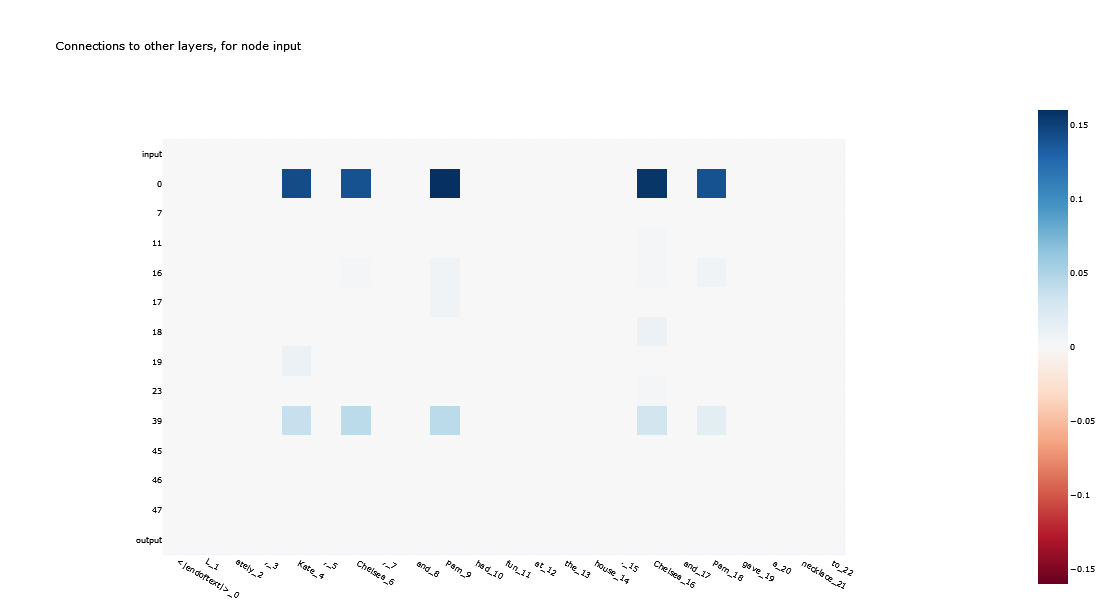

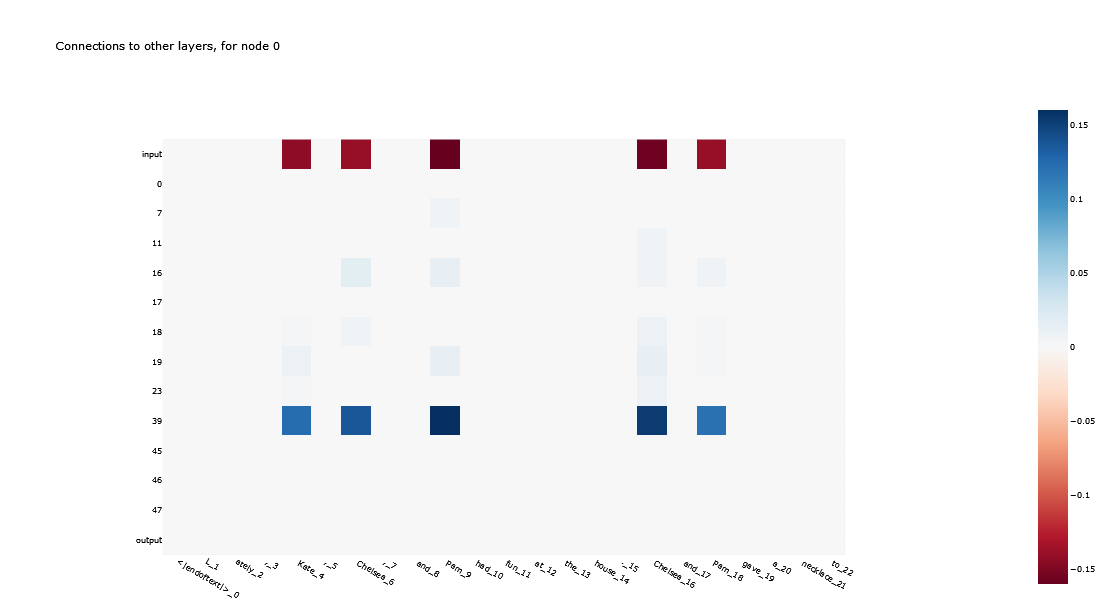

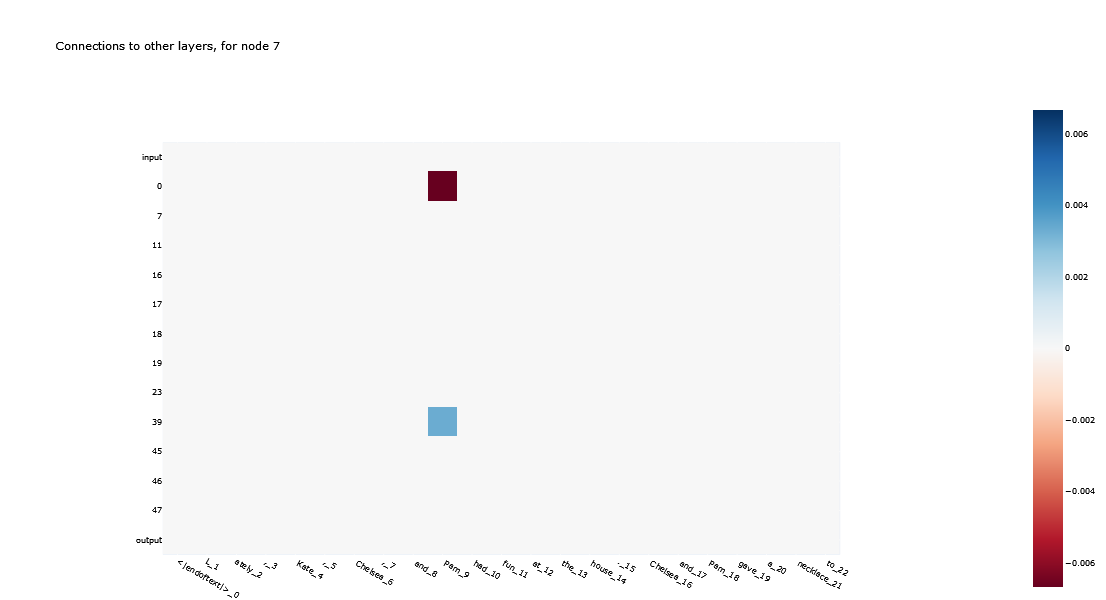

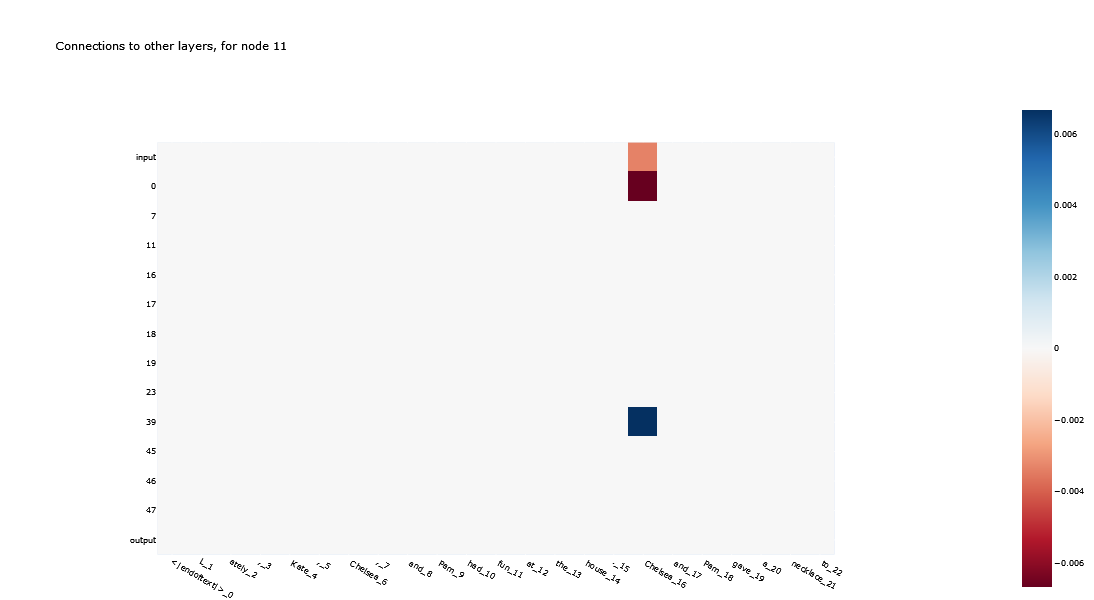

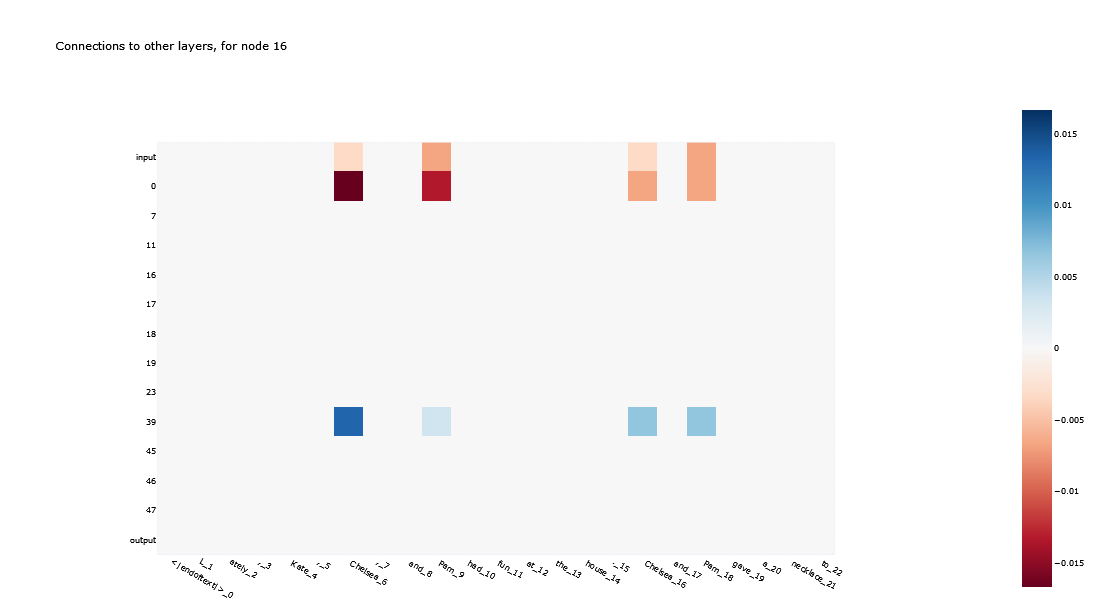

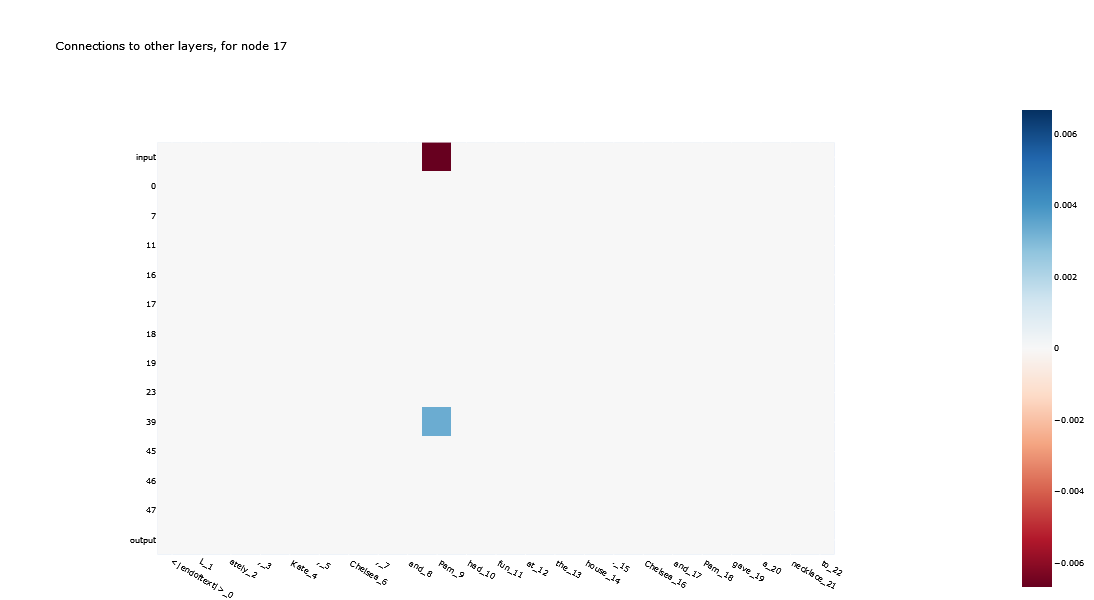

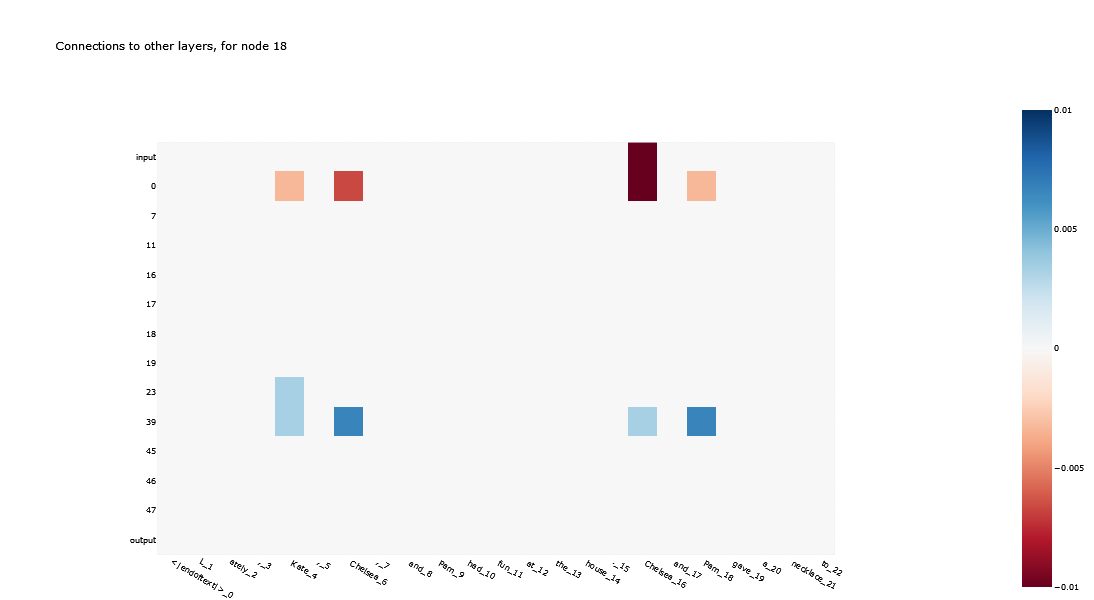

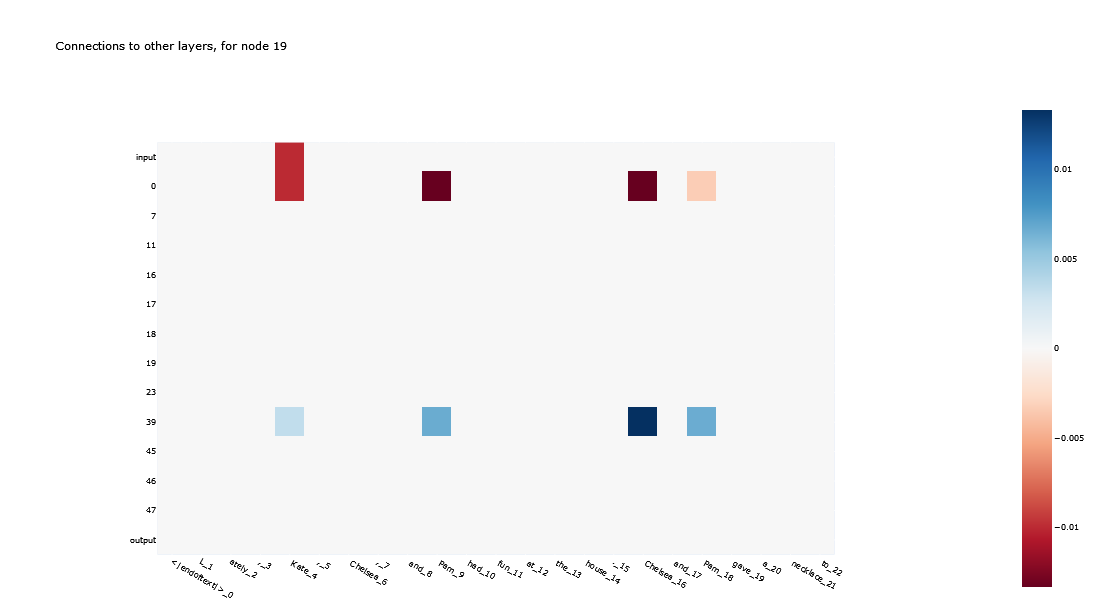

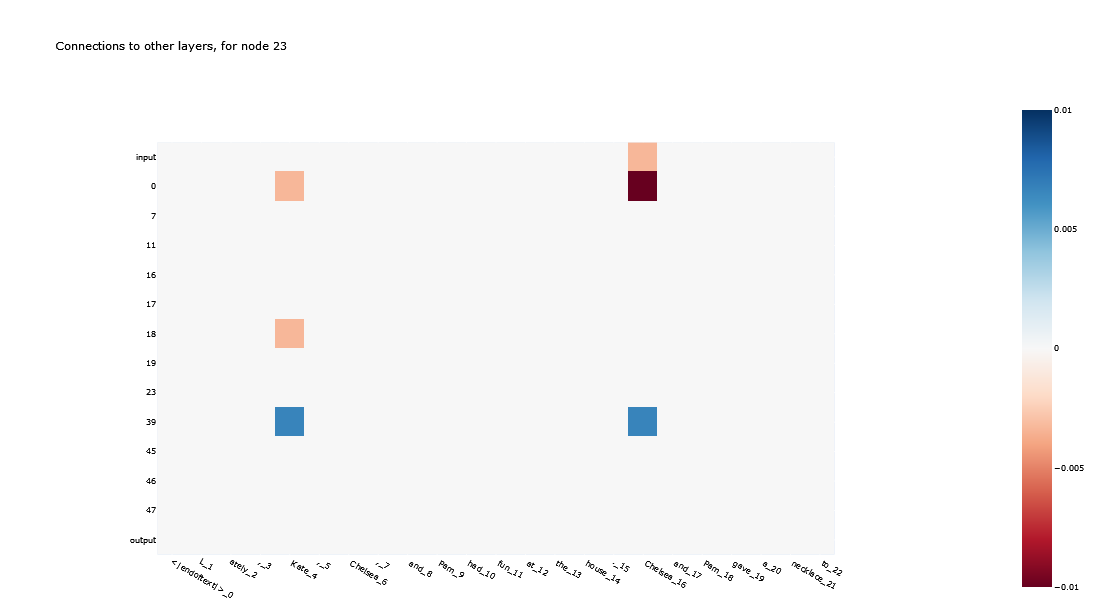

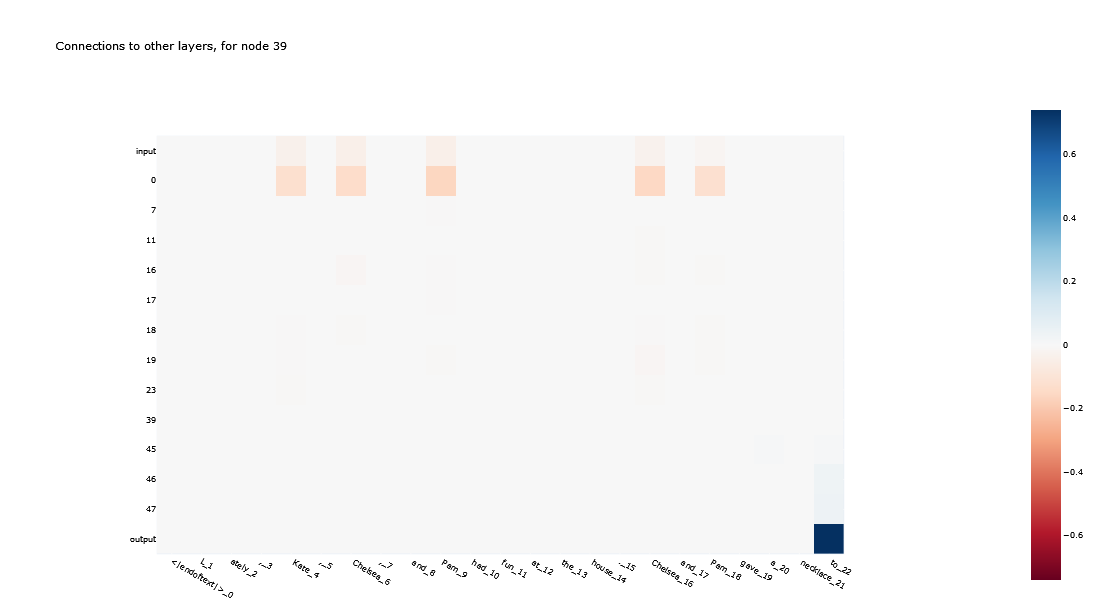

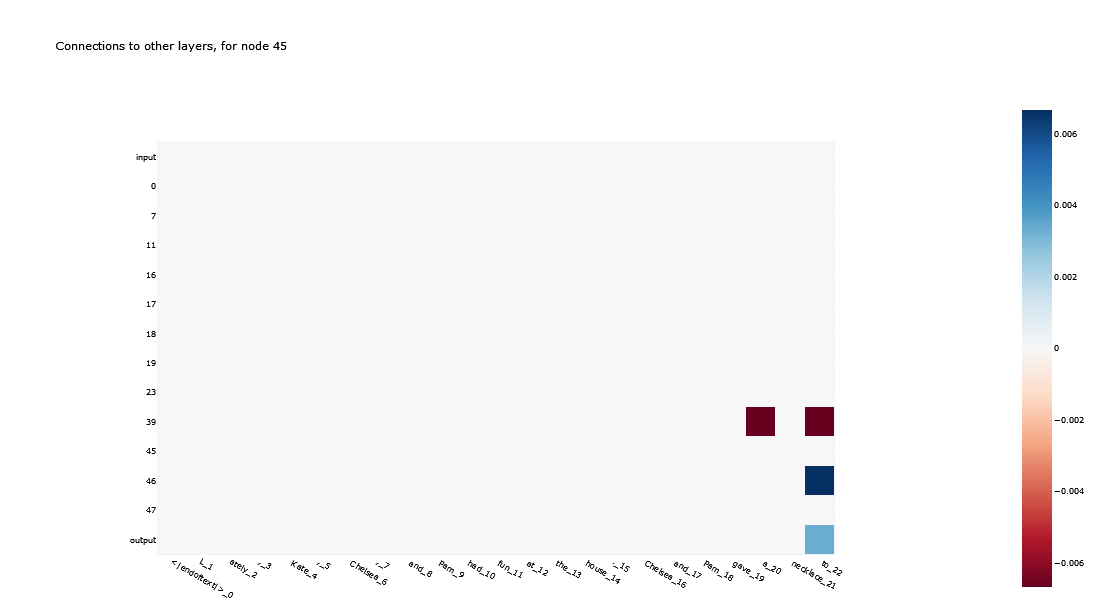

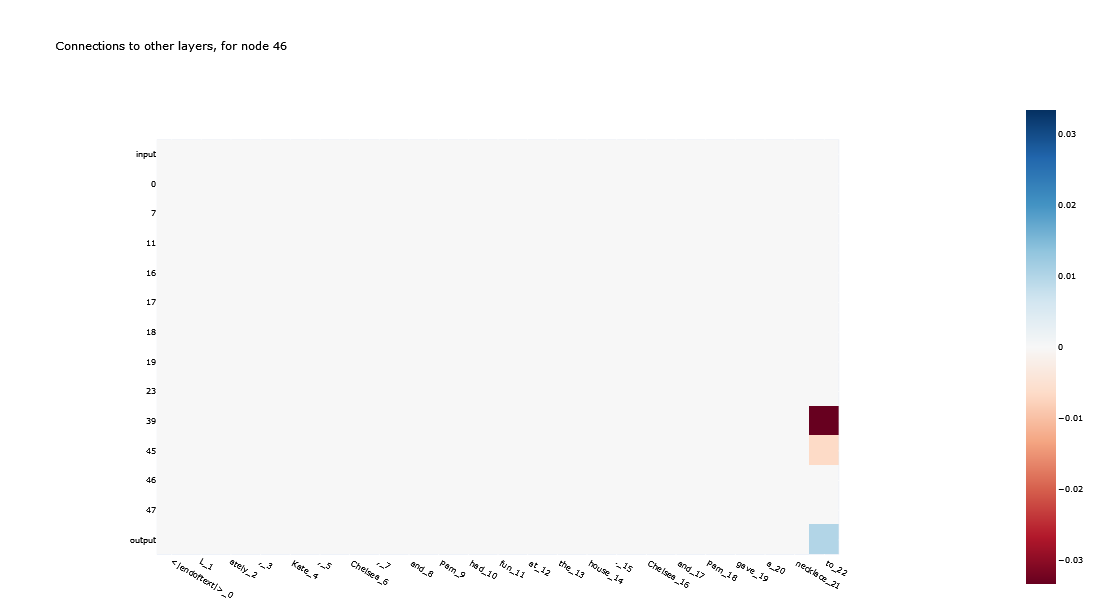

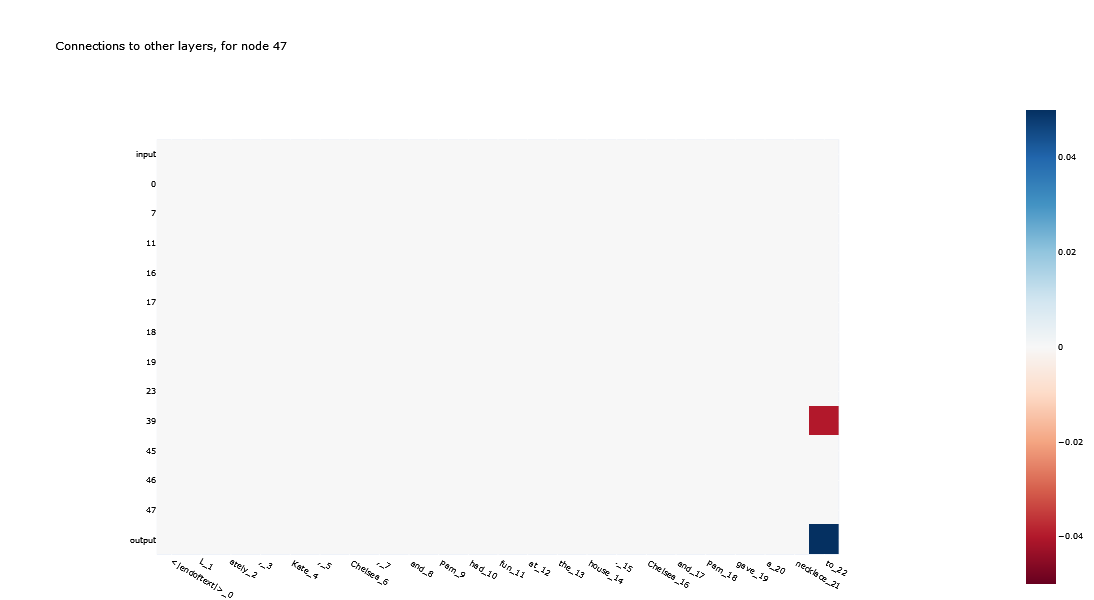

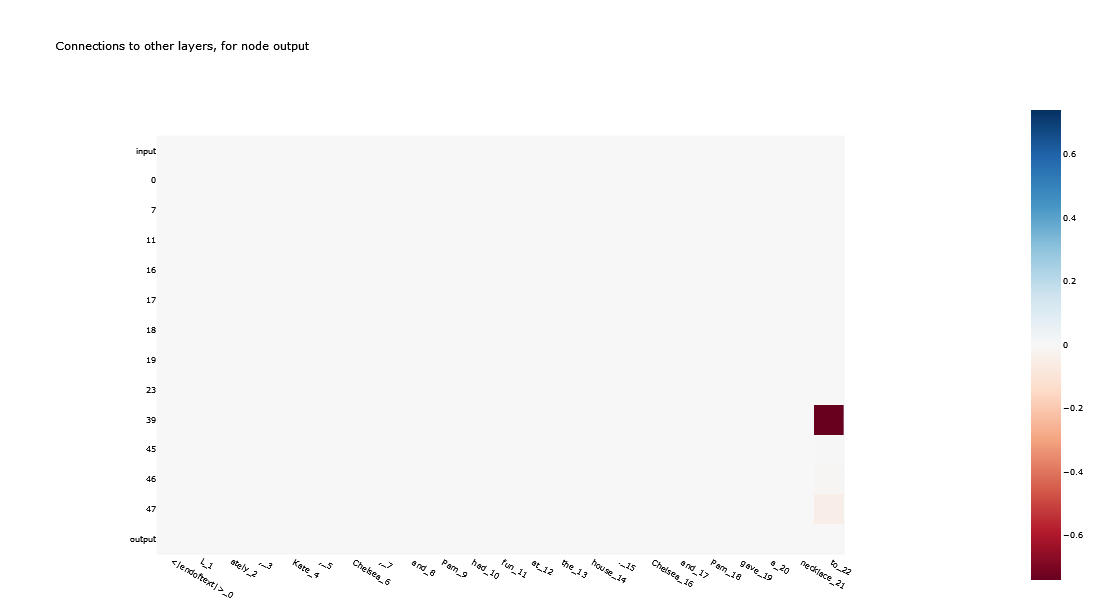

In [101]:
nodes = list(all_nodes.items())

## test for disconnected nodes (ignoring them makes visi less cluttered)
disconnected_nodes = defaultdict(lambda: True)
for edge in edges:
    if not edge.patching:
        disconnected_nodes[edge.input_node] = False
        disconnected_nodes[edge.output_node] = False

ignoring_nodes = []

for node_name, node in nodes:
    if disconnected_nodes[node_name]:
        print(f"{node_name} is disconnected")
        ignoring_nodes.append(node_name)

nodes = [(node_name, node) for (node_name, node) in nodes if not node_name in ignoring_nodes]


# make various mappings that make gathering data easier
layers = [int(node_name) for node_name, node in nodes if not node_name in [INPUT_NODE, OUTPUT_NODE]]
layers.sort()
layer_to_ind = dict([(layer,i+1) for (i,layer) in enumerate(layers)])

def to_index(name):
    if name in [INPUT_NODE, OUTPUT_NODE]:
        return {INPUT_NODE: 0, OUTPUT_NODE: len(nodes)-1}[name]
    else:
        return layer_to_ind[int(name)]

node_name_to_index = dict([(node_name, to_index(node_name)) for node_name, node in nodes])
node_index_to_name = dict([(to_index(node_name), node_name) for node_name, node in nodes])
adjacency_matrix = torch.zeros([len(nodes), len(nodes), L])
num_edges = 0
total_edges = 0
for edge in edges:
    total_edges += 1
    if not edge.patching:
        num_edges += 1
        position = edge.output_hook_params['position']
        adjacency_matrix[node_name_to_index[edge.input_node], node_name_to_index[edge.output_node],position] = edge.score_when_patched
        adjacency_matrix[node_name_to_index[edge.output_node], node_name_to_index[edge.input_node],position] = -edge.score_when_patched

print(f"subgraph has {num_edges} edges out of {total_edges} edges")

ANNOTATION_FONT_SIZE = 7
def add_annotation(fig, annotation):
    for i, line in enumerate(annotation.split("\n")):
        fig.add_annotation(dict(font=dict(color='black',size=ANNOTATION_FONT_SIZE),
                            x=0,
                            y=1.0,
                            showarrow=False,
                            text=line,
                            textangle=0,
                            xanchor='left',
                            yanchor='bottom',
                            xref="paper",
                            yref="paper"))


str_tokens = model.to_str_tokens(batched_data[0])
token_labels = []
for index, token in enumerate(str_tokens):
    token_labels.append(f"{token}_{index}")

labels = [node_index_to_name[i] for i in range(len(nodes))]

print(" ".join(token_labels))
# 10, 25, 
name_map = {4: 'n1', 6: 'n2', 9: 'n3', 16: 'n4', 18: 'n5'}
'''
labels = [node_index_to_name[i] for i in range(len(nodes))]
print(labels)
for l in range(L):
    fig = imshow(adjacency_matrix[:,:,l], x=labels, y=labels, title=f'Adjacency matrix for IOI circuit, at position {l}', fix_size=True, font_size=8, show=False)
    add_annotation(fig, " ".join(token_labels))
    fig.show()
'''
for i in range(len(nodes)):
    fig = imshow(adjacency_matrix[i,:,:], x=token_labels, y=labels, title=f'Connections to other layers, for node {node_index_to_name[i]}', fix_size=True, font_size=8, show=False)
    #add_annotation(fig, " ".join(token_labels))
    fig.show()

In [ ]:
# todo: get each edge strength (how much it affects accuracy if removed)

# do they decrease in similar amount for train and test set?

# notes:
# 0 takes in all names
# 7 and 17 only look at the n3
# 11 only looks at n4 
# 16 looks at n2,n3,n4,n5 (all except n1)
# 18 looks at 
# 19 takes in name_1, name_3, name_4, name_5


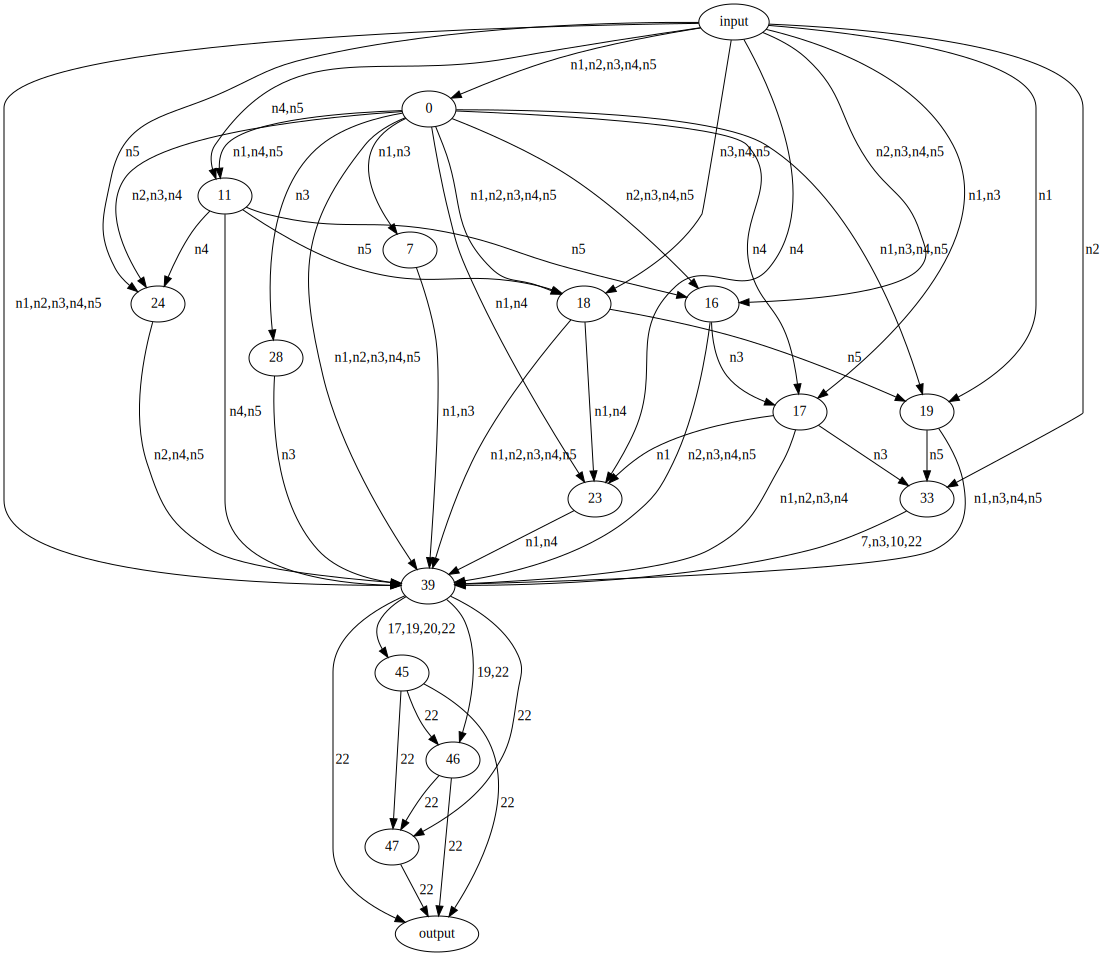

/home/dev/mamba_interp/out_dot.png

In [88]:
# sudo apt-get update
# sudo apt-get install graphviz xdg-utils

# step 1: do layer pruning
# step 2: do edge based patching to find the edge subset
# step 3: do positional edge based patching


def get_graphviz_graph(edges):
    import graphviz
    dot = graphviz.Digraph('result')
    node_connections = defaultdict(lambda: [])
    for edge in edges:
        if edge.checked and not edge.patching:
            if len(edge.label()) > 0:
                node_connections[(edge.input_node, edge.output_node)].append(int(edge.label()))
            else:
                dot.edge(edge.input_node, edge.output_node)
    name_map = {4: 'n1', 6: 'n2', 9: 'n3', 16: 'n4', 18: 'n5'}
    for (input_node, output_node), positions in node_connections.items():
        positions = sorted(list(positions))
        converted_positions = [name_map[int(p)] if int(p) in name_map else str(p) for p in positions]

        dot.edge(input_node, output_node, label=",".join(converted_positions))
    return dot
import tempfile
from PIL import Image
draw_graphviz_graph(edges=edges)
import networkx as nx
G = get_graphviz_graph(edges=edges)
f_path = "out_dot"
G.render(f_path, format='png') 
from IPython.display import FileLink, display
display(FileLink(f_path + ".png"))

In [56]:

global edges
global all_nodes
import cloudpickle
with open("output_edge_positions_final_v5_pruned.pkl", "wb") as f:
    cloudpickle.dump([edges, all_nodes], f)

In [100]:
with open("output_edge_positions_final_v5_pruned.pkl", "rb") as f:
    [edges, all_nodes] = cloudpickle.load(f)

## Probing

In [104]:
from sklearn.linear_model import LinearRegression
import numpy as np
# we want to predict the name from the representation
# there are two ways to do this:
# 1. Predict the probability of a rep being a name (output logits for each name)
# 2. Output the name embedding
# we'll start with the second one because it is more general, if that doesn't work we can try the first one


# we're basically doing a tuned lens sorta? idk
# lets start with not batched

# okay so say we are trying to output the name embedding
# on layer i, that could mean:
#    predict emb after it's projected into E space (which is after norm, but before conv)
#    predict emb after conv
#    predict emb after conv and silu
#    predict emb from hidden state or some other internal rep
# the point is that we train this linear map for some specific thing, then how well it performs suggests how well that thing encodes our data,
# so we can try it for lots of intermediate stuff
# some of the maps won't work, that's ok




# make sure we have no overlap
joined_data = torch.cat([batched_data, vbatched_data, tbatched_data], dim=0)
torch.sort(joined_data, dim=0)
unique = torch.unique(joined_data, dim=0)
torch.manual_seed(27)
# shuffle data
unique = unique[torch.randperm(unique.size()[0])]
B = unique.size()[0]//3
# split into train valid and test
data, vdata, tdata = unique[:B], unique[B:2*B], unique[2*B:3*B]



BATCH_SIZE=3000

B,L = data.size()

# find all token positions that differ in the data (these are the things we want to predict)
positions_that_vary = {}
for i in range(L):
    unique_values = torch.unique(unique[:,i], dim=0)
    if unique_values.size()[0] > 1:
        positions_that_vary[i] = unique_values

# for each position that varies, for each other position, fit a linear model

global probing_dataset_X
probing_dataset_X = []
def dataset_gathering_hook(
    x: Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    position: int
):
    global probing_dataset_X
    probing_dataset_X.append(x[:,position,:].cpu())
    return x

output_accuracies = torch.zeros([len(positions_that_vary), model.cfg.n_layers, L])
for position_i, (position, values) in enumerate(positions_that_vary.items()):
    # debug ouptuts
    values = sorted(list(values))
    
    print(f"position {position} has the following values:")
    for tok in values:
        print(f"  tok {tok} {repr(model.tokenizer.decode([tok.item()]))}")

    value_to_class = {}
    for i, tok in enumerate(values):
        value_to_class[tok.item()] = i
        
    # make dataset
    
    def get_linear_classification_X(activations, layer, position_x):
        return activations[f'blocks.{layer}.hook_layer_input'][:,position_x].detach().cpu().numpy()

    def get_linear_classification_Y(input_data, position_y):
        B = input_data.size()[0]
        Y = np.zeros([B,len(values)])
        Y = model.embedding.weight[input_data[:,position_y]]
        return Y.detach().cpu().numpy()
        Y[:] = -1 # predict a vector with -1 for incorrect class and 1 for correct class
        for i in range(B):
            value = input_data[i,position_y].item()
            Y[i,value_to_class[value]] = 1
        return Y
    
    names_filter = [f'blocks.{layer}.hook_layer_input' for layer in range(model.cfg.n_layers)]
    logits, activations = model.run_with_cache(data[:500], names_filter=names_filter)
    vlogits, vactivations = model.run_with_cache(vdata[:500], names_filter=names_filter)
    
    Y = get_linear_classification_Y(input_data=data[:500], position_y=position)
    vY = get_linear_classification_Y(input_data=vdata[:500], position_y=position)
    
    for layer in tqdm(list(range(model.cfg.n_layers))):
        for other_position in range(L):
            X = get_linear_classification_X(activations=activations, layer=layer, position_x=other_position)
            linear_model = LinearRegression()
            linear_model.fit(X, Y)
            vX = get_linear_classification_X(activations=vactivations, layer=layer, position_x=other_position)
            pY = linear_model.predict(vX)
            predicted_inds = np.argmax(pY, axis=1)
            actual_inds = np.argmax(vY, axis=1)
            acc = np.sum(predicted_inds==actual_inds)/float(predicted_inds.shape[0])
            #print(f"position {position} layer {layer} other position {other_position} acc {acc}")
            output_accuracies[position_i, layer, other_position] = acc

print(f"these token positions vary their value: {positions_that_vary}")




position 4 has the following values:
  tok 2552 ' May'
  tok 3419 ' Ag'
  tok 6039 ' Cam'
  tok 6086 ' George'
  tok 6393 ' Mary'
  tok 7903 ' Max'
  tok 8652 ' Lee'
  tok 8939 ' Pet'
  tok 10497 ' Asia'
  tok 10734 ' Ray'
  tok 16700 ' Dallas'
  tok 18966 ' Grace'
  tok 20047 ' Vin'
  tok 20428 ' Kate'
  tok 21638 ' Terry'
  tok 22169 ' Beth'
  tok 22707 ' Lisa'
  tok 22825 ' Barry'
  tok 24504 ' Emily'
  tok 25063 ' Bren'
  tok 25635 ' Ruth'
  tok 25975 ' Emma'
  tok 26525 ' Ada'
  tok 26642 ' Martha'
  tok 27145 ' Tommy'
  tok 27504 ' Sandy'
  tok 27741 ' Florence'
  tok 27773 ' Blake'
  tok 27955 ' Faith'
  tok 28585 ' Blair'
  tok 28642 ' Ana'
  tok 28710 ' Dale'
  tok 28962 ' Raf'
  tok 29051 ' Quinn'
  tok 29489 ' Jessica'
  tok 29804 ' Angela'
  tok 30014 ' Berry'
  tok 31316 ' Ellen'
  tok 31479 ' Liz'
  tok 31662 ' Mead'
  tok 32867 ' Else'
  tok 32874 ' Kerry'
  tok 33534 ' Bea'
  tok 33811 ' Amanda'
  tok 34221 ' Elli'
  tok 34327 ' Maggie'
  tok 35084 ' Silva'
  tok 35099 

  0%|          | 0/48 [00:00<?, ?it/s]

position 6 has the following values:
  tok 3419 ' Ag'
  tok 3689 ' Min'
  tok 3978 ' June'
  tok 6086 ' George'
  tok 6393 ' Mary'
  tok 6416 ' Christian'
  tok 7758 ' Florida'
  tok 8652 ' Lee'
  tok 8831 ' Ira'
  tok 8969 ' Tim'
  tok 10734 ' Ray'
  tok 12447 ' Rose'
  tok 14943 ' Kelly'
  tok 15458 ' Sarah'
  tok 15784 ' Row'
  tok 16286 ' Morgan'
  tok 17361 ' Sydney'
  tok 19051 ' Lane'
  tok 20145 ' Margaret'
  tok 20222 ' Susan'
  tok 20882 ' Danny'
  tok 21438 ' Charlotte'
  tok 22463 ' Robin'
  tok 22825 ' Barry'
  tok 23425 ' Catherine'
  tok 23801 ' Honor'
  tok 23961 ' Kay'
  tok 24465 ' Gill'
  tok 24707 ' Bobby'
  tok 25080 ' Bird'
  tok 25579 ' Chelsea'
  tok 25635 ' Ruth'
  tok 27145 ' Tommy'
  tok 27504 ' Sandy'
  tok 27741 ' Florence'
  tok 27773 ' Blake'
  tok 27936 ' Cris'
  tok 28084 ' Pam'
  tok 28518 ' Hannah'
  tok 28962 ' Raf'
  tok 29778 ' Joan'
  tok 30680 ' Meta'
  tok 31316 ' Ellen'
  tok 31529 ' Loren'
  tok 32252 ' Casey'
  tok 32577 ' Sally'
  tok 33245 

  0%|          | 0/48 [00:00<?, ?it/s]

KeyboardInterrupt: 

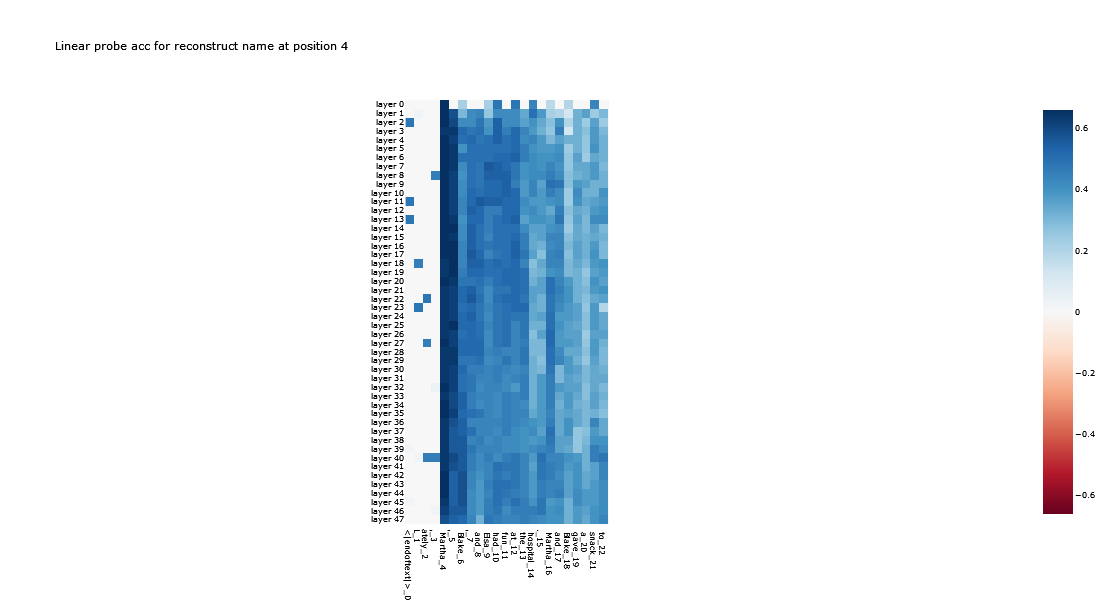

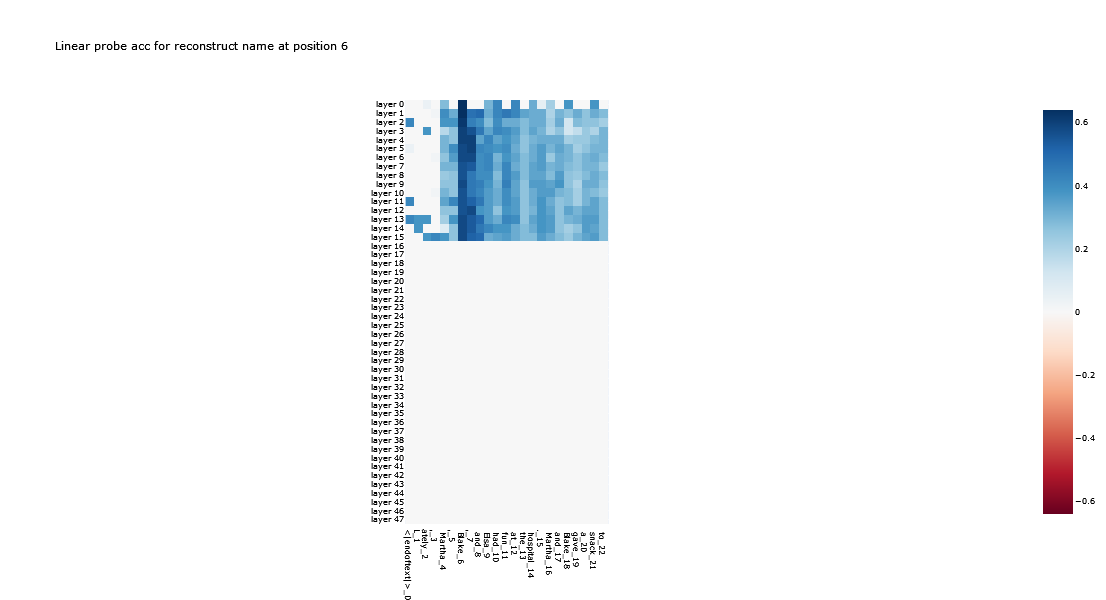

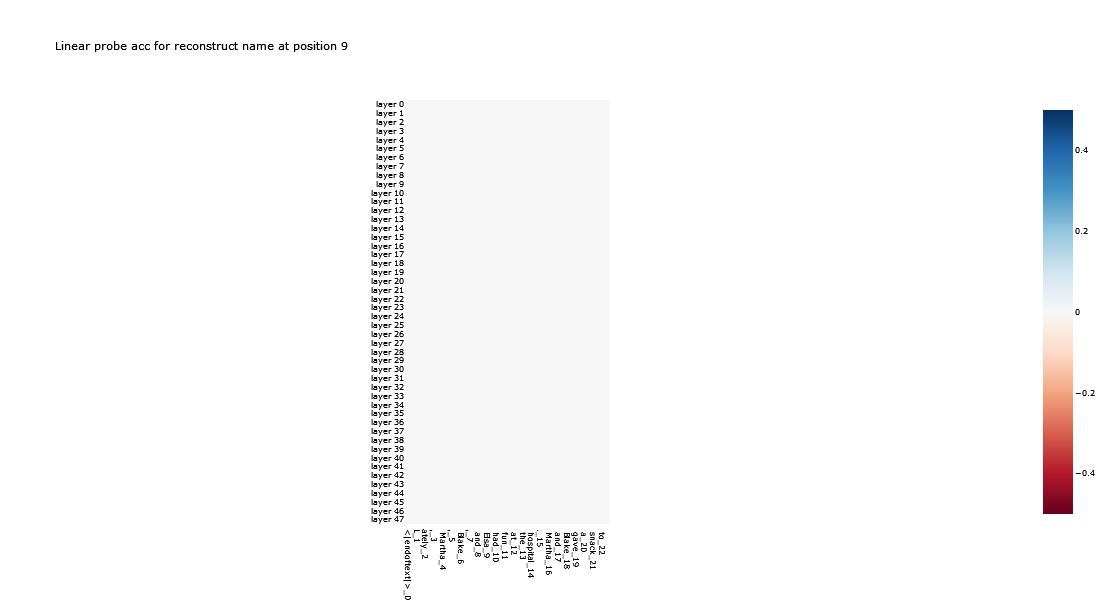

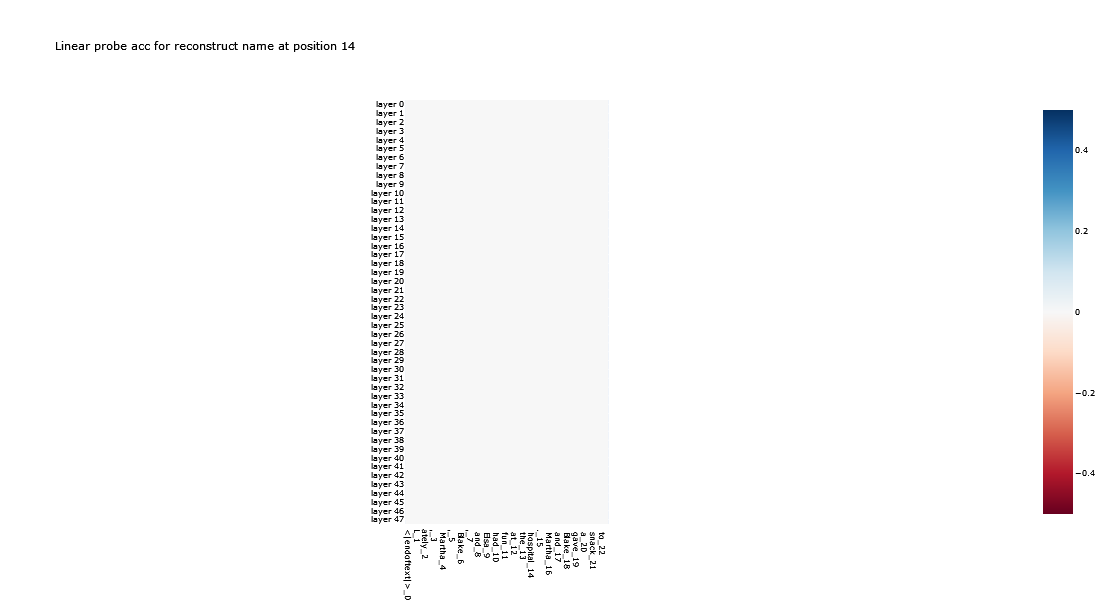

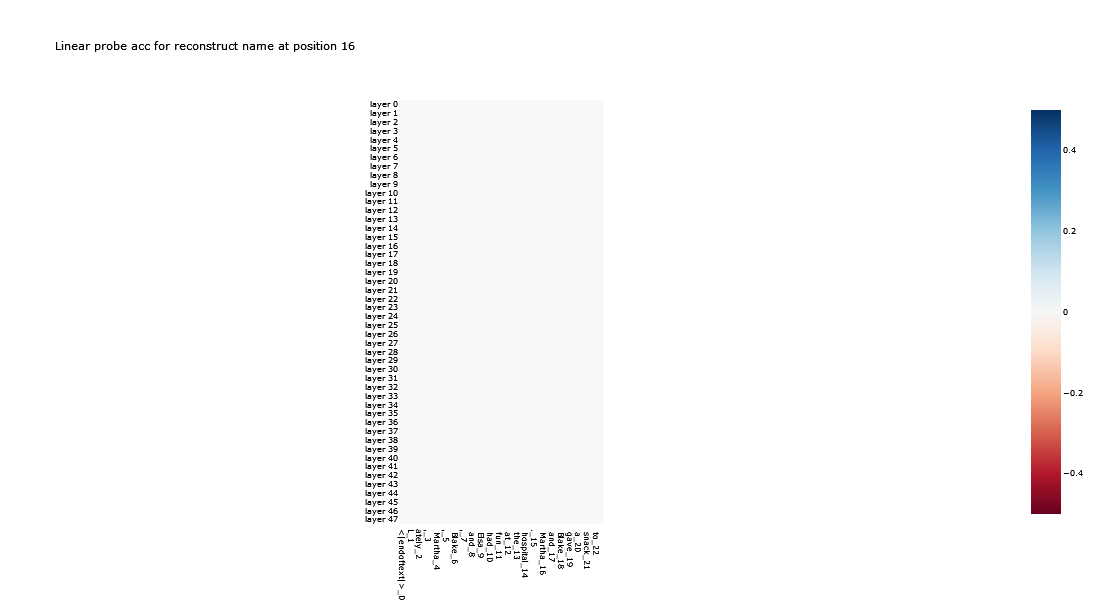

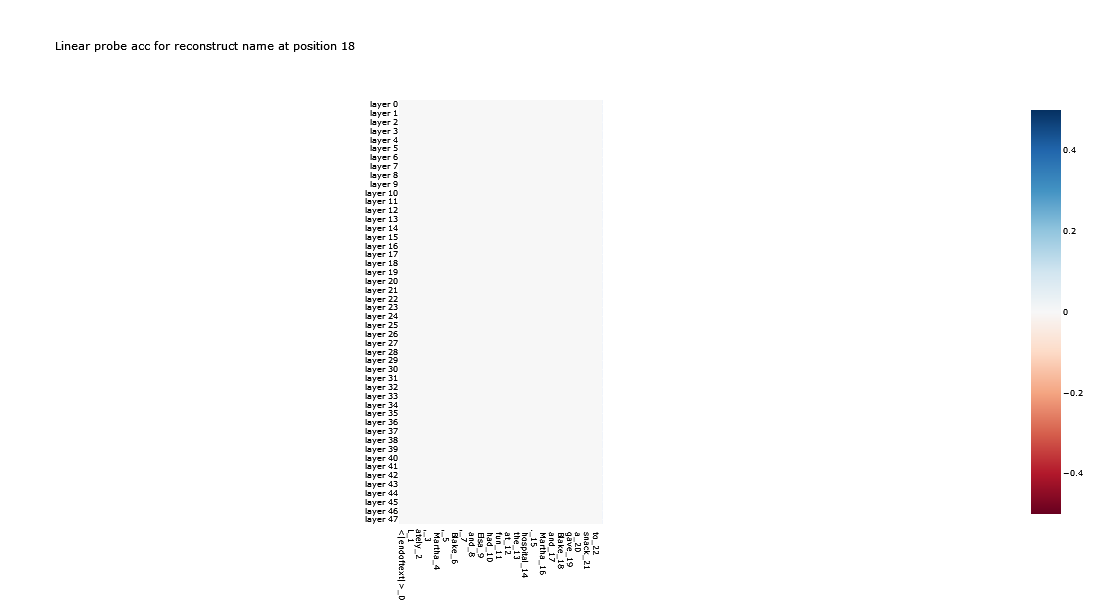

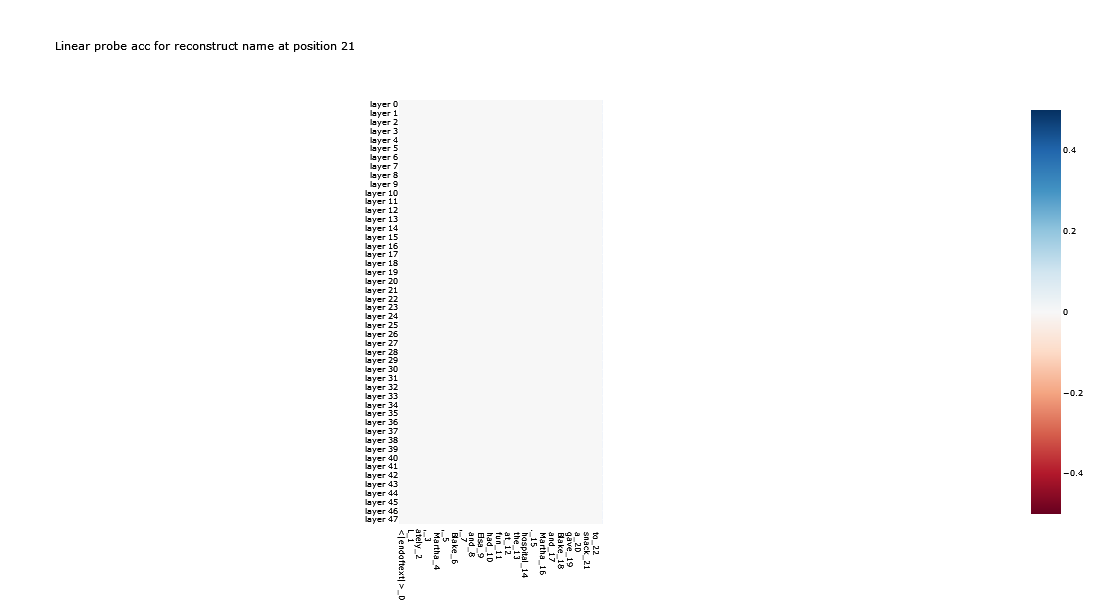

In [105]:

for position_i, (position, values) in enumerate(positions_that_vary.items()):
    # make token labels that describe the patch
    str_tokens = model.to_str_tokens(data[0])
    token_labels = []
    for index, token in enumerate(str_tokens):
        token_labels.append(f"{token}_{index}")
    
    imshow(output_accuracies[position_i], x=token_labels, y=[f'layer {layer}' for layer in range(model.cfg.n_layers)], title=f'Linear probe acc for reconstruct name at position {position}', fix_size=True, font_size=8)

In [96]:
unique.size()

torch.Size([22059, 23])

In [26]:
%%javascript

window.scroll_flag = true
window.scroll_exit = false
window.scroll_delay = 100

$(".output_scroll").each(function() {
    $(this)[0].scrollTop = $(this)[0].scrollHeight;
});

function callScrollToBottom() {
    setTimeout(scrollToBottom, window.scroll_delay);
}

function scrollToBottom() {
    if (window.scroll_exit) {
        return;
    }
    if (!window.scroll_flag) {
        callScrollToBottom();
        return;
    };
    
    $(".output_scroll").each(function() {
        if (!$(this).attr('scroll_checkbox')){
            window.scroll_flag = true;
            $(this).attr('scroll_checkbox',true);
            var div = document.createElement('div');
            var checkbox = document.createElement('input');
            checkbox.type = "checkbox";
            checkbox.onclick = function(){window.scroll_flag = checkbox.checked}
            checkbox.checked = "checked"
            div.append("Auto-Scroll-To-Bottom: ");
            div.append(checkbox);
            $(this).parent().before(div);
        }
        
        $(this)[0].scrollTop = $(this)[0].scrollHeight;
    });
    callScrollToBottom();
}
scrollToBottom();

<IPython.core.display.Javascript object>

In [7]:
print(model.cfg.normalization_type )

LNPre


In [98]:

BATCH_SIZE = 1000

# todo: double up things but swapped, so it's symmetric
def patch_layer_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
) -> Float[torch.Tensor, "B E N"]:
    # patch in corrupted (they come in pairs)
    for i in range(0, h.size()[0], 2):
        h[i] = h[i+1]
    return h

#limited_layer_set = [0, 7, 10, 11, 14, 15, 16, 17, 19, 23, 25, 27, 28, 33, 34, 39, 45, 46, 47]

limited_layers = [0, 7, 10, 11, 16, 17, 18, 19, 23, 24, 25, 28, 33, 39, 45, 46, 47]
B,L = batched_data.size()

def wrap_patch_specific_layers(model, layers_to_patch, **kwargs):
    hooks = []
    for layer in layers_to_patch:
        hooks.append((f"blocks.{layer}.hook_conv", patch_layer_hook))
        for l in range(L):
            hooks.append((f"blocks.{layer}.hook_h.{l}", patch_layer_hook))
    
    def wrapper(input):
        return model.run_with_hooks(input, fwd_hooks=hooks, **kwargs)
    wrapper.tokenizer = model.tokenizer
    wrapper.cfg = model.cfg
    return wrapper

print(f"constraining output to answers? {constrain_to_answers}")

print(f"num layers {model.cfg.n_layers}")

        
pbatched_data = repeat_swapped_patch(batched_data)
pbatched_correct = repeat_swapped_patch(batched_correct)
pbatched_incorrect = repeat_swapped_patch(batched_incorrect)
vpbatched_data = repeat_swapped_patch(vbatched_data)
vpbatched_correct = repeat_swapped_patch(vbatched_correct)
vpbatched_incorrect = repeat_swapped_patch(vbatched_incorrect)


history = []
history_stats = []
layers_to_patch = []

while len(layers_to_patch) < model.cfg.n_layers:
    remaining_layers = copy.deepcopy(limited_layers)
    for layer in layers_to_patch:
        remaining_layers.remove(layer)
    print("layers not patched", remaining_layers)
    print("layers patched", layers_to_patch)
    correct, incorrect, acc = eval(
                                    wrap_patch_specific_layers(model=model, layers_to_patch=layers_to_patch, fast_ssm=False, fast_conv=False,
                                                              only_use_these_layers=limited_layers),
                                    vpbatched_data, vpbatched_correct, vpbatched_incorrect,
                                    constrain_to_answers=constrain_to_answers,
                                    batch_size=BATCH_SIZE,
                                    patch=True)
    print(f"correct{relative_str}pr {correct} incorrect{relative_str}pr {incorrect} accuracy {acc}")
    history_stats.append((correct, incorrect, acc))
    
    out_acc = torch.zeros([len(remaining_layers)], device=model.cfg.device)
    out_prs_correct = torch.zeros([len(remaining_layers)], device=model.cfg.device)
    out_prs_incorrect = torch.zeros([len(remaining_layers)], device=model.cfg.device)
        
    for i, start_layer in tqdm(list(enumerate(remaining_layers))):
        #layers = list(range(start_layer, end_layer+1))
        patching_layers = layers_to_patch + [start_layer]
        
        correct, incorrect, acc = eval(
                                    wrap_patch_specific_layers(model=model, layers_to_patch=patching_layers, fast_ssm=False, fast_conv=False,
                                                              only_use_these_layers=limited_layers),
                                    pbatched_data, pbatched_correct, pbatched_incorrect,
                                    constrain_to_answers=constrain_to_answers,
                                    batch_size=BATCH_SIZE,
                                    patch=True)
        out_prs_correct[i] = correct
        out_prs_incorrect[i] = incorrect
        out_acc[i] = acc

    print(out_acc)
    best_layer_to_patch = remaining_layers[torch.argsort(-out_acc)[0]]
    print("patching layer", best_layer_to_patch, f"with acc {out_acc[remaining_layers.index(best_layer_to_patch)]}")
    layers_to_patch.append(best_layer_to_patch)

history_stats = torch.tensor(history_stats)

constraining output to answers? True
num layers 48
layers not patched [0, 7, 10, 11, 16, 17, 18, 19, 23, 24, 25, 28, 33, 39, 45, 46, 47]
layers patched []
correct relative pr 0.9239857792854309 incorrect relative pr 0.0760142132639885 accuracy 0.94


  0%|          | 0/17 [00:00<?, ?it/s]

tensor([0.8800, 0.8800, 0.8800, 0.8800, 0.8800, 0.8800, 0.8800, 0.9000, 0.8800,
        0.8800, 0.8400, 0.8800, 0.8800, 0.0400, 0.8600, 0.8800, 0.8400],
       device='cuda:0')
patching layer 19 with acc 0.8999999761581421
layers not patched [0, 7, 10, 11, 16, 17, 18, 23, 24, 25, 28, 33, 39, 45, 46, 47]
layers patched [19]
correct relative pr 0.9243126511573792 incorrect relative pr 0.07568734884262085 accuracy 0.94


  0%|          | 0/16 [00:00<?, ?it/s]

tensor([0.8800, 0.8800, 0.9000, 0.8800, 0.9000, 0.8600, 0.9000, 0.8800, 0.8800,
        0.9000, 0.8800, 0.8800, 0.0400, 0.8600, 0.8800, 0.8400],
       device='cuda:0')
patching layer 18 with acc 0.8999999761581421
layers not patched [0, 7, 10, 11, 16, 17, 23, 24, 25, 28, 33, 39, 45, 46, 47]
layers patched [19, 18]
correct relative pr 0.9059450626373291 incorrect relative pr 0.0940549224615097 accuracy 0.92


  0%|          | 0/15 [00:00<?, ?it/s]

tensor([0.9000, 0.8800, 0.9000, 0.8800, 0.8800, 0.8800, 0.8800, 0.8800, 0.9200,
        0.8800, 0.8800, 0.0400, 0.9200, 0.9000, 0.8600], device='cuda:0')
patching layer 25 with acc 0.9200000166893005
layers not patched [0, 7, 10, 11, 16, 17, 23, 24, 28, 33, 39, 45, 46, 47]
layers patched [19, 18, 25]
correct relative pr 0.8984599113464355 incorrect relative pr 0.10154010355472565 accuracy 0.92


  0%|          | 0/14 [00:00<?, ?it/s]

tensor([0.9200, 0.9200, 0.9200, 0.9000, 0.9200, 0.8800, 0.9000, 0.9200, 0.8800,
        0.9000, 0.0400, 0.9400, 0.9200, 0.8600], device='cuda:0')
patching layer 45 with acc 0.9399999976158142
layers not patched [0, 7, 10, 11, 16, 17, 23, 24, 28, 33, 39, 46, 47]
layers patched [19, 18, 25, 45]
correct relative pr 0.9360000491142273 incorrect relative pr 0.0639999657869339 accuracy 0.96


  0%|          | 0/13 [00:00<?, ?it/s]

tensor([0.9400, 0.9400, 0.9400, 0.9200, 0.9400, 0.9200, 0.9200, 0.9400, 0.9000,
        0.9400, 0.0400, 0.9200, 0.8800], device='cuda:0')
patching layer 0 with acc 0.9399999976158142
layers not patched [7, 10, 11, 16, 17, 23, 24, 28, 33, 39, 46, 47]
layers patched [19, 18, 25, 45, 0]
correct relative pr 0.9320068359375 incorrect relative pr 0.06799319386482239 accuracy 0.92


  0%|          | 0/12 [00:00<?, ?it/s]

tensor([0.9200, 0.9000, 0.9200, 0.9200, 0.9200, 0.9200, 0.9200, 0.9000, 0.9000,
        0.0400, 0.9200, 0.8800], device='cuda:0')
patching layer 11 with acc 0.9200000166893005
layers not patched [7, 10, 16, 17, 23, 24, 28, 33, 39, 46, 47]
layers patched [19, 18, 25, 45, 0, 11]
correct relative pr 0.9235168099403381 incorrect relative pr 0.07648316025733948 accuracy 0.92


  0%|          | 0/11 [00:00<?, ?it/s]

tensor([0.9200, 0.9200, 0.9000, 0.9200, 0.9200, 0.9200, 0.8800, 0.9200, 0.0400,
        0.9000, 0.8600], device='cuda:0')
patching layer 10 with acc 0.9200000166893005
layers not patched [7, 16, 17, 23, 24, 28, 33, 39, 46, 47]
layers patched [19, 18, 25, 45, 0, 11, 10]
correct relative pr 0.9077736735343933 incorrect relative pr 0.09222633391618729 accuracy 0.9


  0%|          | 0/10 [00:00<?, ?it/s]

tensor([0.9000, 0.8800, 0.9000, 0.9200, 0.9200, 0.8600, 0.8800, 0.0400, 0.9000,
        0.8800], device='cuda:0')
patching layer 24 with acc 0.9200000166893005
layers not patched [7, 16, 17, 23, 28, 33, 39, 46, 47]
layers patched [19, 18, 25, 45, 0, 11, 10, 24]
correct relative pr 0.9067704677581787 incorrect relative pr 0.0932295173406601 accuracy 0.9


  0%|          | 0/9 [00:00<?, ?it/s]

tensor([0.9000, 0.9000, 0.9000, 0.9200, 0.8800, 0.8800, 0.0400, 0.9200, 0.8600],
       device='cuda:0')
patching layer 46 with acc 0.9200000166893005
layers not patched [7, 16, 17, 23, 28, 33, 39, 47]
layers patched [19, 18, 25, 45, 0, 11, 10, 24, 46]
correct relative pr 0.9311526417732239 incorrect relative pr 0.06884738802909851 accuracy 0.92


  0%|          | 0/8 [00:00<?, ?it/s]

tensor([0.8800, 0.8800, 0.9000, 0.9000, 0.8600, 0.8800, 0.0400, 0.8800],
       device='cuda:0')
patching layer 17 with acc 0.8999999761581421
layers not patched [7, 16, 23, 28, 33, 39, 47]
layers patched [19, 18, 25, 45, 0, 11, 10, 24, 46, 17]
correct relative pr 0.917256772518158 incorrect relative pr 0.08274327218532562 accuracy 0.92


  0%|          | 0/7 [00:00<?, ?it/s]

tensor([0.9000, 0.8800, 0.8800, 0.8600, 0.8800, 0.0400, 0.8800],
       device='cuda:0')
patching layer 7 with acc 0.8999999761581421
layers not patched [16, 23, 28, 33, 39, 47]
layers patched [19, 18, 25, 45, 0, 11, 10, 24, 46, 17, 7]
correct relative pr 0.9080572128295898 incorrect relative pr 0.09194272756576538 accuracy 0.9


  0%|          | 0/6 [00:00<?, ?it/s]

tensor([0.8800, 0.9000, 0.8600, 0.8600, 0.0400, 0.9000], device='cuda:0')
patching layer 47 with acc 0.8999999761581421
layers not patched [16, 23, 28, 33, 39]
layers patched [19, 18, 25, 45, 0, 11, 10, 24, 46, 17, 7, 47]
correct relative pr 0.9453569650650024 incorrect relative pr 0.05464300885796547 accuracy 0.96


  0%|          | 0/5 [00:00<?, ?it/s]

tensor([0.8600, 0.8800, 0.8600, 0.8200, 0.0400], device='cuda:0')
patching layer 23 with acc 0.8799999952316284
layers not patched [16, 28, 33, 39]
layers patched [19, 18, 25, 45, 0, 11, 10, 24, 46, 17, 7, 47, 23]
correct relative pr 0.9512714743614197 incorrect relative pr 0.04872850328683853 accuracy 0.96


  0%|          | 0/4 [00:00<?, ?it/s]

tensor([0.8600, 0.8600, 0.8400, 0.0400], device='cuda:0')
patching layer 28 with acc 0.8600000143051147
layers not patched [16, 33, 39]
layers patched [19, 18, 25, 45, 0, 11, 10, 24, 46, 17, 7, 47, 23, 28]
correct relative pr 0.9378954768180847 incorrect relative pr 0.06210450083017349 accuracy 0.94


  0%|          | 0/3 [00:00<?, ?it/s]

tensor([0.8400, 0.8200, 0.0400], device='cuda:0')
patching layer 16 with acc 0.8399999737739563
layers not patched [33, 39]
layers patched [19, 18, 25, 45, 0, 11, 10, 24, 46, 17, 7, 47, 23, 28, 16]
correct relative pr 0.9456326365470886 incorrect relative pr 0.054367389529943466 accuracy 0.96


  0%|          | 0/2 [00:00<?, ?it/s]

tensor([0.8200, 0.0400], device='cuda:0')
patching layer 33 with acc 0.8199999928474426
layers not patched [39]
layers patched [19, 18, 25, 45, 0, 11, 10, 24, 46, 17, 7, 47, 23, 28, 16, 33]
correct relative pr 0.9346215128898621 incorrect relative pr 0.06537847220897675 accuracy 0.94


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([0.0400], device='cuda:0')
patching layer 39 with acc 0.03999999910593033
layers not patched []
layers patched [19, 18, 25, 45, 0, 11, 10, 24, 46, 17, 7, 47, 23, 28, 16, 33, 39]
correct relative pr 0.018655776977539062 incorrect relative pr 0.9813442230224609 accuracy 0.0


0it [00:00, ?it/s]

tensor([], device='cuda:0')


IndexError: index 0 is out of bounds for dimension 0 with size 0